In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from netCDF4 import Dataset, num2date, date2num
from dask.distributed import Client
import xarray as xr
import fenics as fe
import yaml
import time as time_py
import logging
import os
import importlib
import pdb
import scipy as sp

In [8]:
import letkf_forecasting.letkf_io as letkf_io
import letkf_forecasting.letkf_forecasting as lf
import letkf_forecasting.random_functions as rf
import letkf_forecasting.tmh_plot as tp
import letkf_forecasting.advection
import letkf_forecasting.optical_flow
import letkf_forecasting.assimilation as assimilation
import letkf_forecasting.assimilation_accessories as aa
import letkf_forecasting.analyse_results as ar

In [9]:
%matplotlib inline

# Paper plots

In [71]:
year = 2014


# # for 4/15
# month = 4
# day = 15
# hour = 20
# minute = 15

# for 5/29
month = 5
day = 29
hour = 19 
minute = 30

# # for 4/26
# month = 4
# day = 26
# hour = 20
# minute = 0

time_str = f'{year:04}-{month:02}-{day:02} {hour:02}:{minute:02}:00'

In [72]:
truth = xr.open_dataset(
    f'/a2/uaren/travis/data/{year:04}/{month:02}/{day:02}/data.nc')
truth = truth['ci']
truth = letkf_io.add_crop_attributes(truth)
truth_full = truth.copy()
truth = ar.return_error_domain(truth)

In [73]:
truth = truth.load()

In [74]:
base_folder = '/a2/uaren/travis/'
optimization_folder = None
run = 'owp_opt'

In [75]:
full_day = letkf_io.return_day(year,
                               month,
                               day,
                               run,
                               base_folder,
                               optimization_folder)

In [76]:
full_day = full_day.sel(time=time_str)

In [77]:
full_day = letkf_io.add_crop_attributes(full_day)
full_day = full_day.load()
full_day_ed = ar.return_error_domain(full_day)

/home/travis/miniconda3/envs/letkf/lib/python3.6/site-packages/dask/core.py:306: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif type_arg is type(key) and arg == key:


In [78]:
fd_mean = ar.return_ens_mean(full_day)

In [79]:
fd_mean_30 = ar.return_horizon(fd_mean, 30)

In [80]:
fd_ed_mean = ar.return_ens_mean(full_day_ed)

In [81]:
fore30 = ar.return_horizon(fd_ed_mean, 30)

In [82]:
full30 = ar.return_horizon(full_day_ed, 30)

In [83]:
wrf = letkf_io.return_day(year,
                          month,
                          day,
                          'wrf_no_div',
                          base_folder)
wrf = wrf.sel(time=time_str)

In [84]:
wrf = wrf.load()

/home/travis/miniconda3/envs/letkf/lib/python3.6/site-packages/dask/core.py:306: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif type_arg is type(key) and arg == key:


In [85]:
wrf = letkf_io.add_crop_attributes(wrf)
wrf_ed = ar.return_error_domain(wrf)

In [86]:
wrf_ed_mean = ar.return_ens_mean(wrf_ed)

In [87]:
wrf30 = ar.return_horizon(wrf_ed_mean, 30)

In [88]:
wrf_full_30 = ar.return_horizon(wrf, 30)
wrf_full_30 = wrf_full_30.sel(ensemble_number=0)

In [89]:
opt_flow = letkf_io.return_day(year,
                          month,
                          day,
                          'opt_flow',
                          base_folder)
opt_flow = opt_flow.sel(time=time_str)

In [90]:
opt_flow = opt_flow.load()

/home/travis/miniconda3/envs/letkf/lib/python3.6/site-packages/dask/core.py:306: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif type_arg is type(key) and arg == key:


In [91]:
opt_flow = letkf_io.add_crop_attributes(opt_flow)
opt_flow_ed = ar.return_error_domain(opt_flow)

In [92]:
opt_flow_ed_mean = ar.return_ens_mean(opt_flow_ed)

In [93]:
opt_flow_30 = ar.return_horizon(opt_flow_ed_mean, 30)

In [94]:
opt_flow_full_30 = ar.return_horizon(opt_flow, 30)
opt_flow_full_30 = opt_flow_full_30.sel(ensemble_number=0)

In [95]:
truth_full = truth_full.sel(south_north=wrf.south_north,
                            west_east=wrf.west_east)

In [96]:
from matplotlib import colors

In [97]:
def return_edges(x):
    dx = x[1] - x[0]
    x = x - dx/2
    x = np.append(x, [x[-1] + dx])
    return x

In [98]:
CI = xr.open_dataset(
    f'/a2/uaren/travis/data/{year:04}/{month:02}/{day:02}/data.nc')
CI = CI['ci']

In [99]:
x_ci = CI.west_east.values
y_ci = CI.south_north.values
x_ci = return_edges(x_ci)
y_ci = return_edges(y_ci)
x_center = x_ci.mean()
y_center = y_ci.mean()
x_ci -= x_center
y_ci -= y_center

x_ed = full_day_ed.west_east.values
y_ed = full_day_ed.south_north.values
x_ed = return_edges(x_ed)
y_ed = return_edges(y_ed)
x_ed -= x_center
y_ed -= y_center       

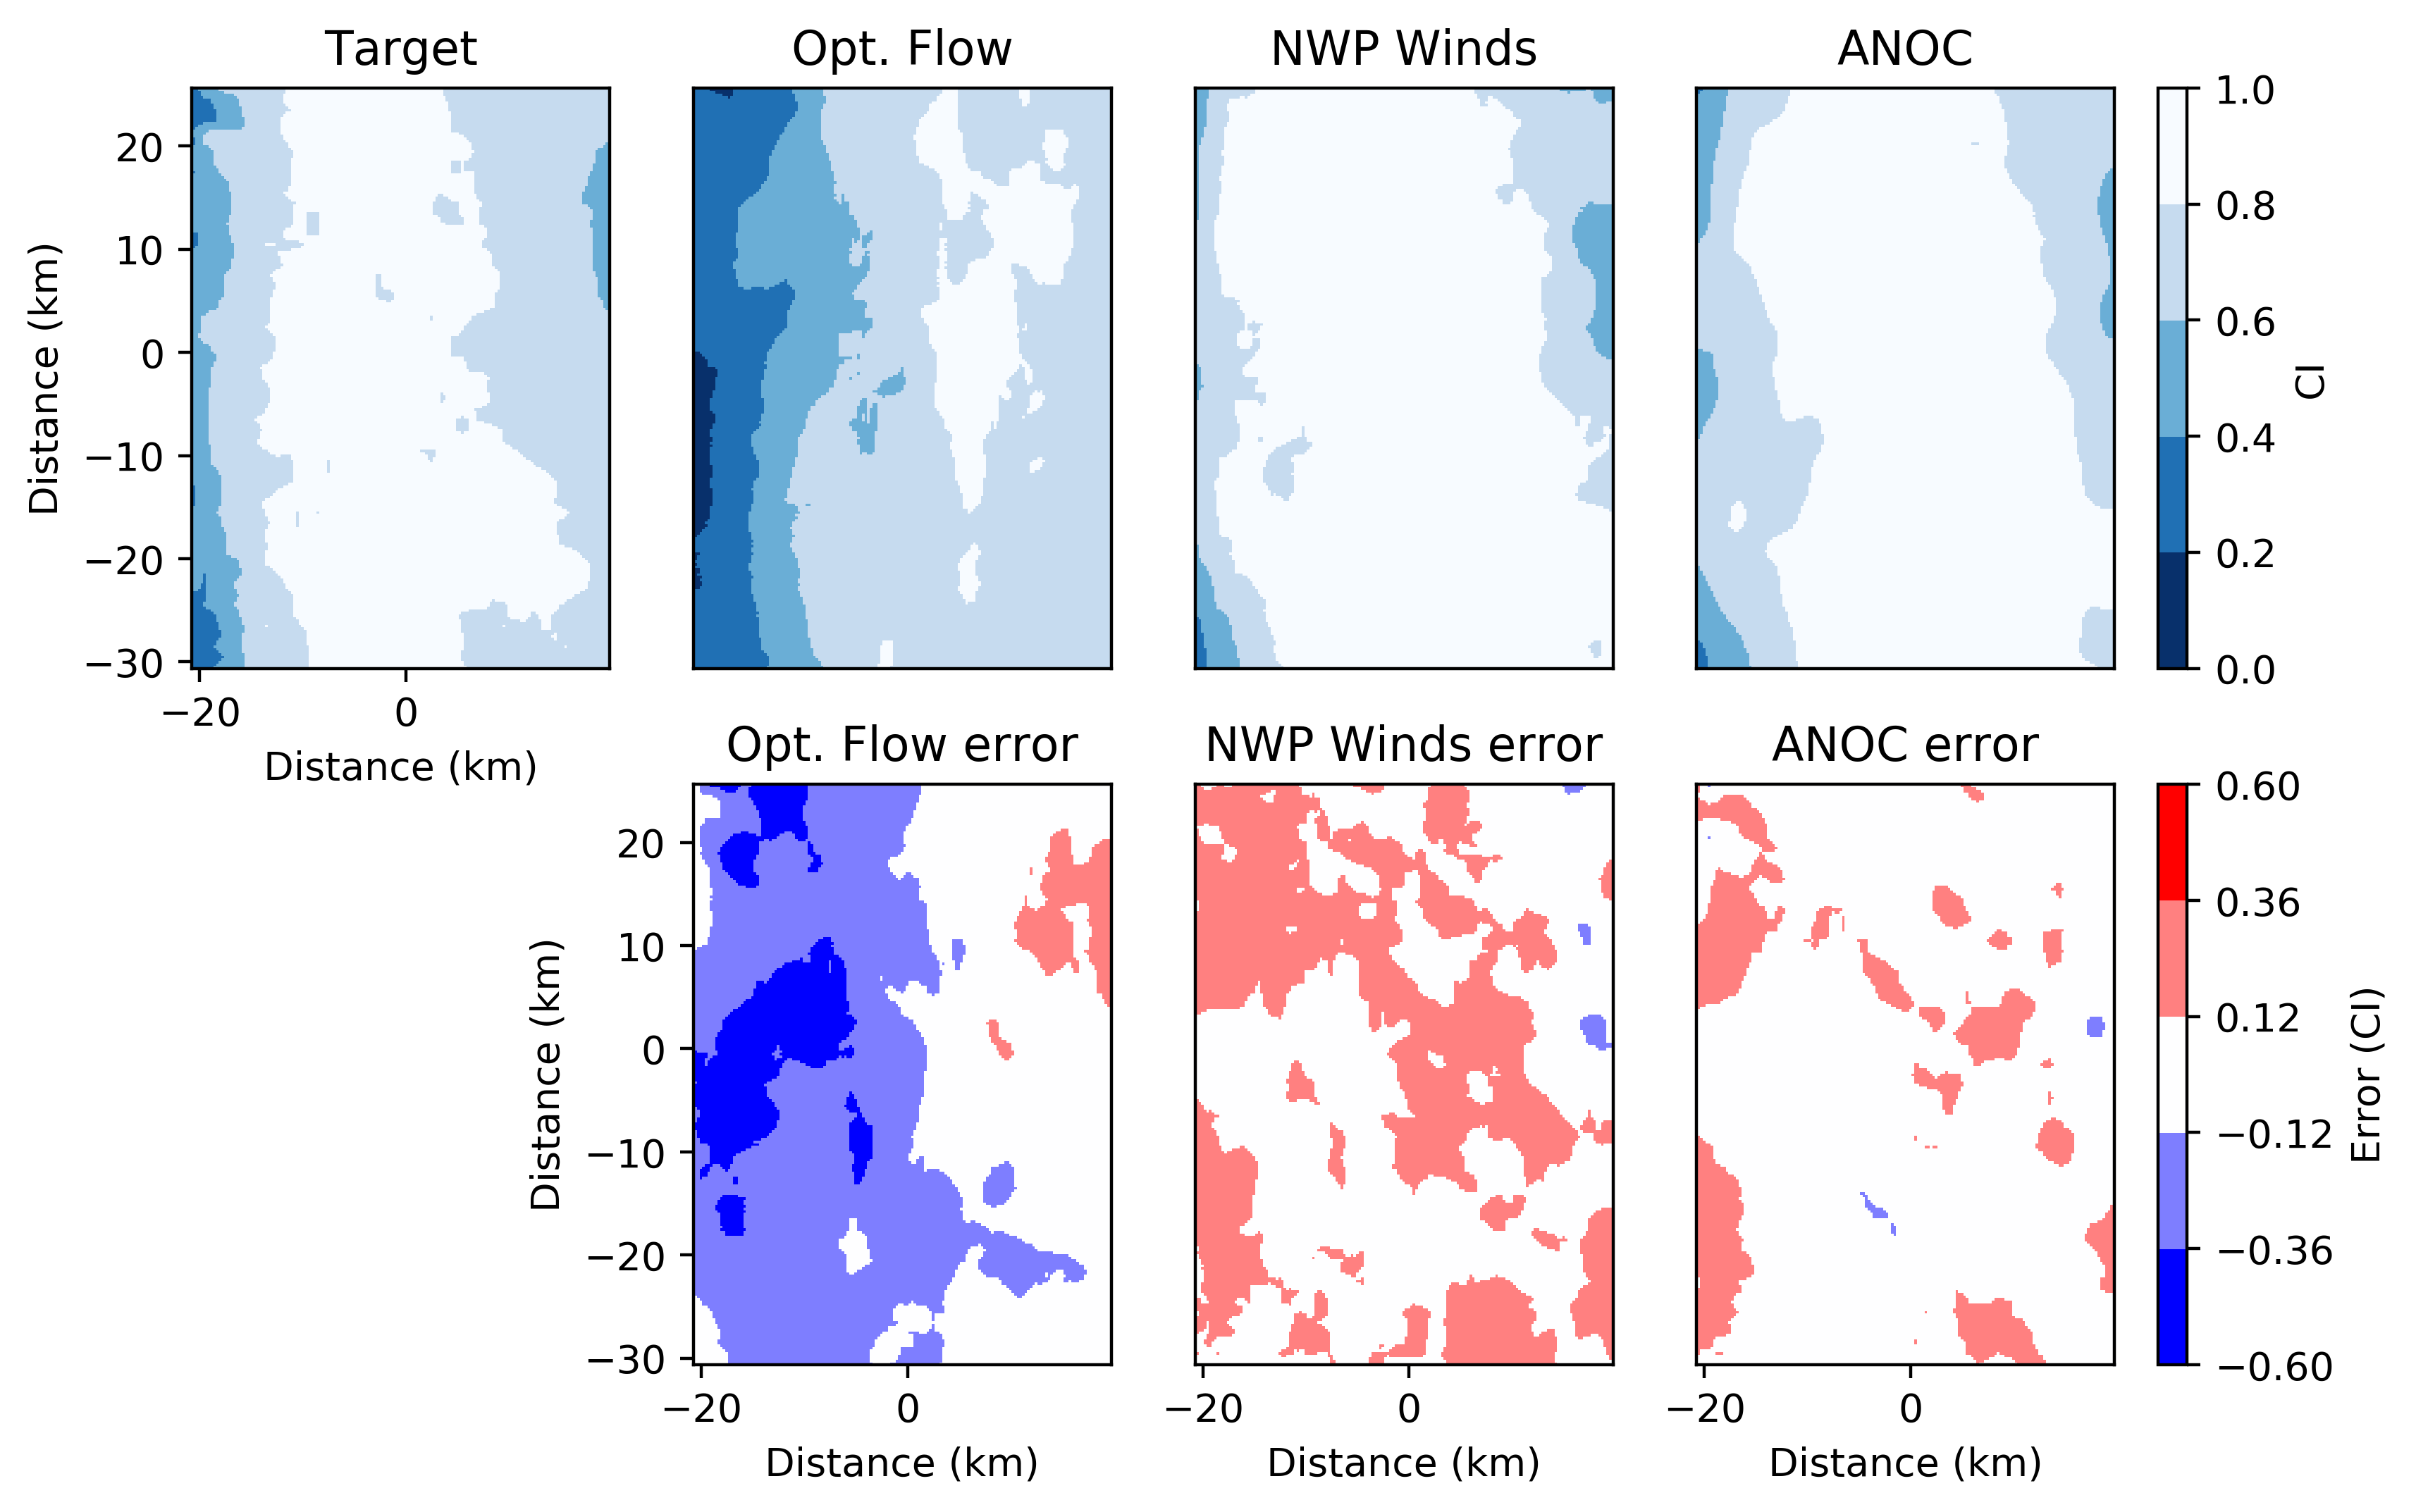

In [100]:
figsize = plt.figaspect(.6)* 1.5
fraction = 0.10
pad = 0.02
nc_ci = 6
nc_er = 6
dpi = 400

t = fore30.time.values[0]

fig, ax = plt.subplots(nrows=2, ncols=4,
                       sharex=False, sharey=False,
                       figsize=figsize, dpi=dpi)

boundaries = np.linspace(0, 1, nc_ci)
ci_norm = colors.BoundaryNorm(boundaries=boundaries, ncolors=256)

error_assim = (fore30['ci'].sel(time=t).clip(0, 1) - truth.sel(time=t).clip(0, 1))
error_wrf = (wrf30['ci'].sel(time=t).clip(0, 1) - truth.sel(time=t).clip(0, 1))
error_of = (opt_flow_30['ci'].sel(time=t).clip(0, 1) - truth.sel(time=t).clip(0, 1))
e_vmax = np.max([np.abs(error_assim).max(),
                 np.abs(error_wrf).max(),
                 np.abs(error_of).max()])
e_vmax = np.ceil(e_vmax * 10)/10

boundaries = np.linspace(-e_vmax, e_vmax, nc_er)
er_norm = colors.BoundaryNorm(boundaries=boundaries, ncolors=256)


# Truth

ax[0, 0].pcolormesh(x_ed, y_ed, truth.sel(time=t).values, cmap='Blues_r',
                    norm=ci_norm)
#                     vmin=0, vmax=1)
ax[0, 0].axis('equal')
ax[0, 0].set_title('Target')
ax[0, 0].set_xlabel('Distance (km)')
ax[0, 0].set_ylabel('Distance (km)')

ax[1, 0].axis('off')


# Opt flow
ax[0, 1].pcolormesh(x_ed, y_ed, opt_flow_30['ci'].sel(time=t).values,
                    cmap='Blues_r',
                    norm=ci_norm)
#                     vmin=0, vmax=1)
ax[0, 1].axis('equal')
ax[0, 1].set_title('Opt. Flow')
ax[0, 1].get_xaxis().set_visible(False)
ax[0, 1].get_yaxis().set_visible(False)


ax[1, 1].pcolormesh(x_ed, y_ed, error_of.values, cmap='bwr',
# ax[1, 1].pcolormesh(np.abs(error_of.values), cmap='bwr',
                    norm=er_norm)
#                     vmin=-e_vmax, vmax=e_vmax)
ax[1, 1].axis('equal')
ax[1, 1].set_title('Opt. Flow error')
ax[1, 1].set_xlabel('Distance (km)')
ax[1, 1].set_ylabel('Distance (km)')


# WRF
ax[0, 2].pcolormesh(x_ed, y_ed, wrf30['ci'].sel(time=t).values,
                    cmap='Blues_r',
                    norm=ci_norm)
#                     vmin=0, vmax=1)
ax[0, 2].axis('equal')
ax[0, 2].set_title('NWP Winds')
ax[0, 2].get_xaxis().set_visible(False)
ax[0, 2].get_yaxis().set_visible(False)


ax[1, 2].pcolormesh(x_ed, y_ed, error_wrf.values, cmap='bwr',
# ax[1, 2].pcolormesh(np.abs(error_wrf.values), cmap='bwr',
                    norm=er_norm)
#                     vmin=-e_vmax, vmax=e_vmax)
ax[1, 2].axis('equal')
ax[1, 2].set_title('NWP Winds error')
ax[1, 2].set_xlabel('Distance (km)')
ax[1, 2].get_yaxis().set_visible(False)



# BACON
im0 = ax[0, 3].pcolormesh(x_ed, y_ed, fore30['ci'].sel(time=t).values,
                    cmap='Blues_r',
                    norm=ci_norm)
#                     vmin=0, vmax=1)
# plt.colorbar(im, ax=ax[0, 3])
ax[0, 3].axis('equal')
ax[0, 3].set_title('ANOC')
ax[0, 3].get_xaxis().set_visible(False)
ax[0, 3].get_yaxis().set_visible(False)


im1 = ax[1, 3].pcolormesh(x_ed, y_ed, error_assim.values, cmap='bwr',
# im1 = ax[1, 3].pcolormesh(np.abs(error_assim.values), cmap='bwr',
                    norm=er_norm)
#                     vmin=-e_vmax, vmax=e_vmax)
# plt.colorbar(im, ax=ax[1, 3])
ax[1, 3].axis('equal')
ax[1, 3].set_title('ANOC error')
ax[1, 3].set_xlabel('Distance (km)')
ax[1, 3].get_yaxis().set_visible(False)


# colorbars
plt.colorbar(im0, ax=ax[0, :].ravel(),
             fraction=fraction, pad=pad, label='CI')
plt.colorbar(im1, ax=ax[1, :].ravel(),
             fraction=fraction, pad=pad, label='Error (CI)')

In [ ]:
figsize = plt.figaspect(.6)* 1.5
fraction = 0.10
pad = 0.02
nc_ci = 6
nc_er = 6
dpi = 300

t = fore30.time.values[0]

fig, ax = plt.subplots(nrows=2, ncols=4,
                       sharex=False, sharey=False,
                       figsize=figsize, dpi=dpi)

boundaries = np.linspace(0, 1, nc_ci)
ci_norm = colors.BoundaryNorm(boundaries=boundaries, ncolors=256)

error_assim = (fore30['ci'].sel(time=t).clip(0, 1) - truth.sel(time=t).clip(0, 1))
error_wrf = (wrf30['ci'].sel(time=t).clip(0, 1) - truth.sel(time=t).clip(0, 1))
error_of = (opt_flow_30['ci'].sel(time=t).clip(0, 1) - truth.sel(time=t).clip(0, 1))
e_vmax = np.max([np.abs(error_assim).max(),
                 np.abs(error_wrf).max(),
                 np.abs(error_of).max()])
e_vmax = np.ceil(e_vmax * 10)/10

boundaries = np.linspace(-e_vmax, e_vmax, nc_er)
er_norm = colors.BoundaryNorm(boundaries=boundaries, ncolors=256)


# Truth

ax[0, 0].pcolormesh(x_ed, y_ed, truth.sel(time=t).values, cmap='Blues_r',
                    norm=ci_norm)
#                     vmin=0, vmax=1)
ax[0, 0].axis('equal')
ax[0, 0].set_title('Target')
ax[0, 0].set_xlabel('Distance (km)')
ax[0, 0].set_ylabel('Distance (km)')

ax[1, 0].axis('off')


# Opt flow
ax[0, 1].pcolormesh(x_ed, y_ed, opt_flow_30['ci'].sel(time=t).values,
                    cmap='Blues_r',
                    norm=ci_norm)
#                     vmin=0, vmax=1)
ax[0, 1].axis('equal')
ax[0, 1].set_title('Opt. Flow')
ax[0, 1].get_xaxis().set_visible(False)
ax[0, 1].get_yaxis().set_visible(False)


ax[1, 1].pcolormesh(x_ed, y_ed, error_of.values, cmap='bwr',
# ax[1, 1].pcolormesh(np.abs(error_of.values), cmap='bwr',
                    norm=er_norm)
#                     vmin=-e_vmax, vmax=e_vmax)
ax[1, 1].axis('equal')
ax[1, 1].set_title('Opt. Flow Error')
ax[1, 1].set_xlabel('Distance (km)')
ax[1, 1].set_ylabel('Distance (km)')


# WRF
ax[0, 2].pcolormesh(x_ed, y_ed, wrf30['ci'].sel(time=t).values,
                    cmap='Blues_r',
                    norm=ci_norm)
#                     vmin=0, vmax=1)
ax[0, 2].axis('equal')
ax[0, 2].set_title('WRF')
ax[0, 2].get_xaxis().set_visible(False)
ax[0, 2].get_yaxis().set_visible(False)


ax[1, 2].pcolormesh(x_ed, y_ed, error_wrf.values, cmap='bwr',
# ax[1, 2].pcolormesh(np.abs(error_wrf.values), cmap='bwr',
                    norm=er_norm)
#                     vmin=-e_vmax, vmax=e_vmax)
ax[1, 2].axis('equal')
ax[1, 2].set_title('WRF Error')
ax[1, 2].set_xlabel('Distance (km)')
ax[1, 2].get_yaxis().set_visible(False)



# BACON
im0 = ax[0, 3].pcolormesh(x_ed, y_ed, fore30['ci'].sel(time=t).values,
                    cmap='Blues_r',
                    norm=ci_norm)
#                     vmin=0, vmax=1)
# plt.colorbar(im, ax=ax[0, 3])
ax[0, 3].axis('equal')
ax[0, 3].set_title('BACON')
ax[0, 3].get_xaxis().set_visible(False)
ax[0, 3].get_yaxis().set_visible(False)


im1 = ax[1, 3].pcolormesh(x_ed, y_ed, error_assim.values, cmap='bwr',
# im1 = ax[1, 3].pcolormesh(np.abs(error_assim.values), cmap='bwr',
                    norm=er_norm)
#                     vmin=-e_vmax, vmax=e_vmax)
# plt.colorbar(im, ax=ax[1, 3])
ax[1, 3].axis('equal')
ax[1, 3].set_title('BACON Error')
ax[1, 3].set_xlabel('Distance (km)')
ax[1, 3].get_yaxis().set_visible(False)


# colorbars
plt.colorbar(im0, ax=ax[0, :].ravel(),
             fraction=fraction, pad=pad, label='CI')
plt.colorbar(im1, ax=ax[1, :].ravel(),
             fraction=fraction, pad=pad, label='Error (CI)')

In [ ]:
figsize = plt.figaspect(.6)* 1.5
fraction = 0.10
pad = 0.02
nc_ci = 8
nc_er = 8
dpi = 300

t = fore30.time.values[0]

fig, ax = plt.subplots(nrows=2, ncols=4,
                       sharex=False, sharey=False,
                       figsize=figsize, dpi=dpi)

boundaries = np.linspace(0, 1, nc_ci)
ci_norm = colors.BoundaryNorm(boundaries=boundaries, ncolors=256)

error_assim = (fore30['ci'].sel(time=t).clip(0, 1) - truth.sel(time=t).clip(0, 1))
error_wrf = (wrf30['ci'].sel(time=t).clip(0, 1) - truth.sel(time=t).clip(0, 1))
error_of = (opt_flow_30['ci'].sel(time=t).clip(0, 1) - truth.sel(time=t).clip(0, 1))
e_vmax = np.max([np.abs(error_assim).max(),
                 np.abs(error_wrf).max(),
                 np.abs(error_of).max()])
e_vmax = np.ceil(e_vmax * 10)/10

boundaries = np.linspace(-e_vmax, e_vmax, nc_er)
er_norm = colors.BoundaryNorm(boundaries=boundaries, ncolors=256)


# Truth

ax[0, 0].pcolormesh(x_ed, y_ed, truth.sel(time=t).values, cmap='Blues_r',
                    norm=ci_norm)
#                     vmin=0, vmax=1)
ax[0, 0].axis('equal')
ax[0, 0].set_title('Target')
ax[0, 0].set_xlabel('Distance (km)')
ax[0, 0].set_ylabel('Distance (km)')

ax[1, 0].axis('off')


# Opt flow
ax[0, 1].pcolormesh(x_ed, y_ed, opt_flow_30['ci'].sel(time=t).values,
                    cmap='Blues_r',
                    norm=ci_norm)
#                     vmin=0, vmax=1)
ax[0, 1].axis('equal')
ax[0, 1].set_title('Opt. Flow')
ax[0, 1].get_xaxis().set_visible(False)
ax[0, 1].get_yaxis().set_visible(False)


ax[1, 1].pcolormesh(x_ed, y_ed, error_of.values, cmap='bwr',
# ax[1, 1].pcolormesh(np.abs(error_of.values), cmap='bwr',
                    norm=er_norm)
#                     vmin=-e_vmax, vmax=e_vmax)
ax[1, 1].axis('equal')
ax[1, 1].set_title('Opt. Flow Error')
ax[1, 1].set_xlabel('Distance (km)')
ax[1, 1].set_ylabel('Distance (km)')


# WRF
ax[0, 2].pcolormesh(x_ed, y_ed, wrf30['ci'].sel(time=t).values,
                    cmap='Blues_r',
                    norm=ci_norm)
#                     vmin=0, vmax=1)
ax[0, 2].axis('equal')
ax[0, 2].set_title('WRF')
ax[0, 2].get_xaxis().set_visible(False)
ax[0, 2].get_yaxis().set_visible(False)


ax[1, 2].pcolormesh(x_ed, y_ed, error_wrf.values, cmap='bwr',
# ax[1, 2].pcolormesh(np.abs(error_wrf.values), cmap='bwr',
                    norm=er_norm)
#                     vmin=-e_vmax, vmax=e_vmax)
ax[1, 2].axis('equal')
ax[1, 2].set_title('WRF Error')
ax[1, 2].set_xlabel('Distance (km)')
ax[1, 2].get_yaxis().set_visible(False)



# BACON
im0 = ax[0, 3].pcolormesh(x_ed, y_ed, fore30['ci'].sel(time=t).values,
                    cmap='Blues_r',
                    norm=ci_norm)
#                     vmin=0, vmax=1)
# plt.colorbar(im, ax=ax[0, 3])
ax[0, 3].axis('equal')
ax[0, 3].set_title('BACON')
ax[0, 3].get_xaxis().set_visible(False)
ax[0, 3].get_yaxis().set_visible(False)


im1 = ax[1, 3].pcolormesh(x_ed, y_ed, error_assim.values, cmap='bwr',
# im1 = ax[1, 3].pcolormesh(np.abs(error_assim.values), cmap='bwr',
                    norm=er_norm)
#                     vmin=-e_vmax, vmax=e_vmax)
# plt.colorbar(im, ax=ax[1, 3])
ax[1, 3].axis('equal')
ax[1, 3].set_title('BACON Error')
ax[1, 3].set_xlabel('Distance (km)')
ax[1, 3].get_yaxis().set_visible(False)


# colorbars
plt.colorbar(im0, ax=ax[0, :].ravel(),
             fraction=fraction, pad=pad, label='CI')
plt.colorbar(im1, ax=ax[1, :].ravel(),
             fraction=fraction, pad=pad, label='Error (CI)')

In [ ]:
figsize = plt.figaspect(.6)* 1.5
fraction = 0.10
pad = 0.02
nc_ci = 6
nc_er = 6
dpi = 300

t = fore30.time.values[0]

fig, ax = plt.subplots(nrows=2, ncols=4,
                       sharex=False, sharey=False,
                       figsize=figsize, dpi=dpi)

boundaries = np.linspace(0, 1, nc_ci)
ci_norm = colors.BoundaryNorm(boundaries=boundaries, ncolors=256)

error_assim = (fore30['ci'].sel(time=t).clip(0, 1) - truth.sel(time=t).clip(0, 1))
error_wrf = (wrf30['ci'].sel(time=t).clip(0, 1) - truth.sel(time=t).clip(0, 1))
error_of = (opt_flow_30['ci'].sel(time=t).clip(0, 1) - truth.sel(time=t).clip(0, 1))
e_vmax = np.max([np.abs(error_assim).max(),
                 np.abs(error_wrf).max(),
                 np.abs(error_of).max()])
e_vmax = np.ceil(e_vmax * 10)/10

boundaries = np.linspace(-e_vmax, e_vmax, nc_er)
er_norm = colors.BoundaryNorm(boundaries=boundaries, ncolors=256)


# Truth

ax[0, 0].pcolormesh(x_ed, y_ed, truth.sel(time=t).values, cmap='Blues_r',
                    norm=ci_norm)
#                     vmin=0, vmax=1)
ax[0, 0].axis('equal')
ax[0, 0].set_title('Target')
ax[0, 0].set_xlabel('Distance (km)')
ax[0, 0].set_ylabel('Distance (km)')

ax[1, 0].axis('off')


# Opt flow
ax[0, 1].pcolormesh(x_ed, y_ed, opt_flow_30['ci'].sel(time=t).values,
                    cmap='Blues_r',
                    norm=ci_norm)
#                     vmin=0, vmax=1)
ax[0, 1].axis('equal')
ax[0, 1].set_title('Opt. Flow')
ax[0, 1].get_xaxis().set_visible(False)
ax[0, 1].get_yaxis().set_visible(False)


ax[1, 1].pcolormesh(x_ed, y_ed, error_of.values, cmap='bwr',
# ax[1, 1].pcolormesh(np.abs(error_of.values), cmap='bwr',
                    norm=er_norm)
#                     vmin=-e_vmax, vmax=e_vmax)
ax[1, 1].axis('equal')
ax[1, 1].set_title('Opt. Flow Error')
ax[1, 1].set_xlabel('Distance (km)')
ax[1, 1].set_ylabel('Distance (km)')


# WRF
ax[0, 2].pcolormesh(x_ed, y_ed, wrf30['ci'].sel(time=t).values,
                    cmap='Blues_r',
                    norm=ci_norm)
#                     vmin=0, vmax=1)
ax[0, 2].axis('equal')
ax[0, 2].set_title('WRF')
ax[0, 2].get_xaxis().set_visible(False)
ax[0, 2].get_yaxis().set_visible(False)


ax[1, 2].pcolormesh(x_ed, y_ed, error_wrf.values, cmap='bwr',
# ax[1, 2].pcolormesh(np.abs(error_wrf.values), cmap='bwr',
                    norm=er_norm)
#                     vmin=-e_vmax, vmax=e_vmax)
ax[1, 2].axis('equal')
ax[1, 2].set_title('WRF Error')
ax[1, 2].set_xlabel('Distance (km)')
ax[1, 2].get_yaxis().set_visible(False)



# BACON
im0 = ax[0, 3].pcolormesh(x_ed, y_ed, fore30['ci'].sel(time=t).values,
                    cmap='Blues_r',
                    norm=ci_norm)
#                     vmin=0, vmax=1)
# plt.colorbar(im, ax=ax[0, 3])
ax[0, 3].axis('equal')
ax[0, 3].set_title('BACON')
ax[0, 3].get_xaxis().set_visible(False)
ax[0, 3].get_yaxis().set_visible(False)


im1 = ax[1, 3].pcolormesh(x_ed, y_ed, error_assim.values, cmap='bwr',
# im1 = ax[1, 3].pcolormesh(np.abs(error_assim.values), cmap='bwr',
                    norm=er_norm)
#                     vmin=-e_vmax, vmax=e_vmax)
# plt.colorbar(im, ax=ax[1, 3])
ax[1, 3].axis('equal')
ax[1, 3].set_title('BACON Error')
ax[1, 3].set_xlabel('Distance (km)')
ax[1, 3].get_yaxis().set_visible(False)


# colorbars
plt.colorbar(im0, ax=ax[0, :].ravel(),
             fraction=fraction, pad=pad, label='CI')
plt.colorbar(im1, ax=ax[1, :].ravel(),
             fraction=fraction, pad=pad, label='Error (CI)')

In [ ]:
figsize = plt.figaspect(.6)* 1.5
fraction = 0.10
pad = 0.02
nc_ci = 8
nc_er = 8
dpi = 300

t = fore30.time.values[0]

fig, ax = plt.subplots(nrows=2, ncols=4,
                       sharex=False, sharey=False,
                       figsize=figsize, dpi=dpi)

boundaries = np.linspace(0, 1, nc_ci)
ci_norm = colors.BoundaryNorm(boundaries=boundaries, ncolors=256)

error_assim = (fore30['ci'].sel(time=t).clip(0, 1) - truth.sel(time=t).clip(0, 1))
error_wrf = (wrf30['ci'].sel(time=t).clip(0, 1) - truth.sel(time=t).clip(0, 1))
error_of = (opt_flow_30['ci'].sel(time=t).clip(0, 1) - truth.sel(time=t).clip(0, 1))
e_vmax = np.max([np.abs(error_assim).max(),
                 np.abs(error_wrf).max(),
                 np.abs(error_of).max()])
e_vmax = np.ceil(e_vmax * 10)/10

boundaries = np.linspace(-e_vmax, e_vmax, nc_er)
er_norm = colors.BoundaryNorm(boundaries=boundaries, ncolors=256)


# Truth

ax[0, 0].pcolormesh(x_ed, y_ed, truth.sel(time=t).values, cmap='Blues_r',
                    norm=ci_norm)
#                     vmin=0, vmax=1)
ax[0, 0].axis('equal')
ax[0, 0].set_title('Target')
ax[0, 0].set_xlabel('Distance (km)')
ax[0, 0].set_ylabel('Distance (km)')

ax[1, 0].axis('off')


# Opt flow
ax[0, 1].pcolormesh(x_ed, y_ed, opt_flow_30['ci'].sel(time=t).values,
                    cmap='Blues_r',
                    norm=ci_norm)
#                     vmin=0, vmax=1)
ax[0, 1].axis('equal')
ax[0, 1].set_title('Opt. Flow')
ax[0, 1].get_xaxis().set_visible(False)
ax[0, 1].get_yaxis().set_visible(False)


ax[1, 1].pcolormesh(x_ed, y_ed, error_of.values, cmap='bwr',
# ax[1, 1].pcolormesh(np.abs(error_of.values), cmap='bwr',
                    norm=er_norm)
#                     vmin=-e_vmax, vmax=e_vmax)
ax[1, 1].axis('equal')
ax[1, 1].set_title('Opt. Flow Error')
ax[1, 1].set_xlabel('Distance (km)')
ax[1, 1].set_ylabel('Distance (km)')


# WRF
ax[0, 2].pcolormesh(x_ed, y_ed, wrf30['ci'].sel(time=t).values,
                    cmap='Blues_r',
                    norm=ci_norm)
#                     vmin=0, vmax=1)
ax[0, 2].axis('equal')
ax[0, 2].set_title('WRF')
ax[0, 2].get_xaxis().set_visible(False)
ax[0, 2].get_yaxis().set_visible(False)


ax[1, 2].pcolormesh(x_ed, y_ed, error_wrf.values, cmap='bwr',
# ax[1, 2].pcolormesh(np.abs(error_wrf.values), cmap='bwr',
                    norm=er_norm)
#                     vmin=-e_vmax, vmax=e_vmax)
ax[1, 2].axis('equal')
ax[1, 2].set_title('WRF Error')
ax[1, 2].set_xlabel('Distance (km)')
ax[1, 2].get_yaxis().set_visible(False)



# BACON
im0 = ax[0, 3].pcolormesh(x_ed, y_ed, fore30['ci'].sel(time=t).values,
                    cmap='Blues_r',
                    norm=ci_norm)
#                     vmin=0, vmax=1)
# plt.colorbar(im, ax=ax[0, 3])
ax[0, 3].axis('equal')
ax[0, 3].set_title('BACON')
ax[0, 3].get_xaxis().set_visible(False)
ax[0, 3].get_yaxis().set_visible(False)


im1 = ax[1, 3].pcolormesh(x_ed, y_ed, error_assim.values, cmap='bwr',
# im1 = ax[1, 3].pcolormesh(np.abs(error_assim.values), cmap='bwr',
                    norm=er_norm)
#                     vmin=-e_vmax, vmax=e_vmax)
# plt.colorbar(im, ax=ax[1, 3])
ax[1, 3].axis('equal')
ax[1, 3].set_title('BACON Error')
ax[1, 3].set_xlabel('Distance (km)')
ax[1, 3].get_yaxis().set_visible(False)


# colorbars
plt.colorbar(im0, ax=ax[0, :].ravel(),
             fraction=fraction, pad=pad, label='CI')
plt.colorbar(im1, ax=ax[1, :].ravel(),
             fraction=fraction, pad=pad, label='Error (CI)')

In [ ]:
figsize = plt.figaspect(.6)* 1.5
fraction = 0.10
pad = 0.02
nc_ci = 6
nc_er = 6
dpi = 300

t = fore30.time.values[0]

fig, ax = plt.subplots(nrows=2, ncols=4,
                       sharex=False, sharey=False,
                       figsize=figsize, dpi=dpi)

boundaries = np.linspace(0, 1, nc_ci)
ci_norm = colors.BoundaryNorm(boundaries=boundaries, ncolors=256)

error_assim = (fore30['ci'].sel(time=t).clip(0, 1) - truth.sel(time=t).clip(0, 1))
error_wrf = (wrf30['ci'].sel(time=t).clip(0, 1) - truth.sel(time=t).clip(0, 1))
error_of = (opt_flow_30['ci'].sel(time=t).clip(0, 1) - truth.sel(time=t).clip(0, 1))
e_vmax = np.max([np.abs(error_assim).max(),
                 np.abs(error_wrf).max(),
                 np.abs(error_of).max()])
e_vmax = np.ceil(e_vmax * 10)/10

boundaries = np.linspace(-e_vmax, e_vmax, nc_er)
er_norm = colors.BoundaryNorm(boundaries=boundaries, ncolors=256)


# Truth

ax[0, 0].pcolormesh(x_ed, y_ed, truth.sel(time=t).values, cmap='Blues_r',
                    norm=ci_norm)
#                     vmin=0, vmax=1)
ax[0, 0].axis('equal')
ax[0, 0].set_title('Target')
ax[0, 0].set_xlabel('Distance (km)')
ax[0, 0].set_ylabel('Distance (km)')

ax[1, 0].axis('off')


# Opt flow
ax[0, 1].pcolormesh(x_ed, y_ed, opt_flow_30['ci'].sel(time=t).values,
                    cmap='Blues_r',
                    norm=ci_norm)
#                     vmin=0, vmax=1)
ax[0, 1].axis('equal')
ax[0, 1].set_title('Opt. Flow')
ax[0, 1].get_xaxis().set_visible(False)
ax[0, 1].get_yaxis().set_visible(False)


ax[1, 1].pcolormesh(x_ed, y_ed, error_of.values, cmap='bwr',
# ax[1, 1].pcolormesh(np.abs(error_of.values), cmap='bwr',
                    norm=er_norm)
#                     vmin=-e_vmax, vmax=e_vmax)
ax[1, 1].axis('equal')
ax[1, 1].set_title('Opt. Flow Error')
ax[1, 1].set_xlabel('Distance (km)')
ax[1, 1].set_ylabel('Distance (km)')


# WRF
ax[0, 2].pcolormesh(x_ed, y_ed, wrf30['ci'].sel(time=t).values,
                    cmap='Blues_r',
                    norm=ci_norm)
#                     vmin=0, vmax=1)
ax[0, 2].axis('equal')
ax[0, 2].set_title('WRF')
ax[0, 2].get_xaxis().set_visible(False)
ax[0, 2].get_yaxis().set_visible(False)


ax[1, 2].pcolormesh(x_ed, y_ed, error_wrf.values, cmap='bwr',
# ax[1, 2].pcolormesh(np.abs(error_wrf.values), cmap='bwr',
                    norm=er_norm)
#                     vmin=-e_vmax, vmax=e_vmax)
ax[1, 2].axis('equal')
ax[1, 2].set_title('WRF Error')
ax[1, 2].set_xlabel('Distance (km)')
ax[1, 2].get_yaxis().set_visible(False)



# BACON
im0 = ax[0, 3].pcolormesh(x_ed, y_ed, fore30['ci'].sel(time=t).values,
                    cmap='Blues_r',
                    norm=ci_norm)
#                     vmin=0, vmax=1)
# plt.colorbar(im, ax=ax[0, 3])
ax[0, 3].axis('equal')
ax[0, 3].set_title('BACON')
ax[0, 3].get_xaxis().set_visible(False)
ax[0, 3].get_yaxis().set_visible(False)


im1 = ax[1, 3].pcolormesh(x_ed, y_ed, error_assim.values, cmap='bwr',
# im1 = ax[1, 3].pcolormesh(np.abs(error_assim.values), cmap='bwr',
                    norm=er_norm)
#                     vmin=-e_vmax, vmax=e_vmax)
# plt.colorbar(im, ax=ax[1, 3])
ax[1, 3].axis('equal')
ax[1, 3].set_title('BACON Error')
ax[1, 3].set_xlabel('Distance (km)')
ax[1, 3].get_yaxis().set_visible(False)


# colorbars
plt.colorbar(im0, ax=ax[0, :].ravel(),
             fraction=fraction, pad=pad, label='CI')
plt.colorbar(im1, ax=ax[1, :].ravel(),
             fraction=fraction, pad=pad, label='Error (CI)')

In [ ]:
figsize = plt.figaspect(.65)* 1.5
figsize = plt.figaspect(.6)* 1.5
fraction = 0.10
pad = 0.02
nc = 6

fig, ax = plt.subplots(nrows=2, ncols=4,
                       sharex=False, sharey=False, figsize=figsize)

boundaries = np.linspace(0, 1, nc)
ci_norm = colors.BoundaryNorm(boundaries=boundaries, ncolors=256)

error_assim = (fore30['ci'].sel(time=t) - truth.sel(time=t))
error_wrf = (wrf30['ci'].sel(time=t) - truth.sel(time=t))
error_of = (opt_flow_30['ci'].sel(time=t) - truth.sel(time=t))
e_vmax = np.max([np.abs(error_assim).max(),
                 np.abs(error_wrf).max(),
                 np.abs(error_of).max()])
e_vmax = np.ceil(e_vmax * 10)/10

boundaries = np.linspace(-e_vmax, e_vmax, nc)
er_norm = colors.BoundaryNorm(boundaries=boundaries, ncolors=256)


# Truth

ax[0, 0].pcolormesh(truth.sel(time=t).values, cmap='Blues_r',
                    norm=ci_norm)
#                     vmin=0, vmax=1)
ax[0, 0].axis('equal')
ax[0, 0].set_title('Target')
ax[0, 0].set_xlabel('Distance (km)')
ax[0, 0].set_ylabel('Distance (km)')

ax[1, 0].axis('off')


# Opt flow
ax[0, 1].pcolormesh(opt_flow_30['ci'].sel(time=t).values,
                    cmap='Blues_r',
                    norm=ci_norm)
#                     vmin=0, vmax=1)
ax[0, 1].axis('equal')
ax[0, 1].set_title('Opt. Flow')
ax[0, 1].get_xaxis().set_visible(False)
ax[0, 1].get_yaxis().set_visible(False)


ax[1, 1].pcolormesh(error_of.values, cmap='bwr',
                    norm=er_norm)
#                     vmin=-e_vmax, vmax=e_vmax)
ax[1, 1].axis('equal')
ax[1, 1].set_title('Opt. Flow Error')
ax[1, 1].set_xlabel('Distance (km)')
ax[1, 1].set_ylabel('Distance (km)')


# WRF
ax[0, 2].pcolormesh(wrf30['ci'].sel(time=t).values,
                    cmap='Blues_r',
                    norm=ci_norm)
#                     vmin=0, vmax=1)
ax[0, 2].axis('equal')
ax[0, 2].set_title('WRF')
ax[0, 2].get_xaxis().set_visible(False)
ax[0, 2].get_yaxis().set_visible(False)


ax[1, 2].pcolormesh(error_wrf.values, cmap='bwr',
                    norm=er_norm)
#                     vmin=-e_vmax, vmax=e_vmax)
ax[1, 2].axis('equal')
ax[1, 2].set_title('WRF Error')
ax[1, 2].set_xlabel('Distance (km)')
ax[1, 2].get_yaxis().set_visible(False)



# BACON
im0 = ax[0, 3].pcolormesh(fore30['ci'].sel(time=t).values,
                    cmap='Blues_r',
                    norm=ci_norm)
#                     vmin=0, vmax=1)
# plt.colorbar(im, ax=ax[0, 3])
ax[0, 3].axis('equal')
ax[0, 3].set_title('BACON')
ax[0, 3].get_xaxis().set_visible(False)
ax[0, 3].get_yaxis().set_visible(False)


im1 = ax[1, 3].pcolormesh(error_assim.values, cmap='bwr',
                    norm=er_norm)
#                     vmin=-e_vmax, vmax=e_vmax)
# plt.colorbar(im, ax=ax[1, 3])
ax[1, 3].axis('equal')
ax[1, 3].set_title('BACON Error')
ax[1, 3].set_xlabel('Distance (km)')
ax[1, 3].get_yaxis().set_visible(False)


# colorbars
plt.colorbar(im0, ax=ax[0, :].ravel(),
             fraction=fraction, pad=pad)
plt.colorbar(im1, ax=ax[1, :].ravel(),
             fraction=fraction, pad=pad)

In [ ]:
t = fore30.time.values[0]
data = [fore30['ci'].sel(time=t).values,
        truth.sel(time=t).values,
        wrf30['ci'].sel(time=t).values]
tp.subplots(data, truth.west_east, truth.south_north,
            ['Assimilation', f'Truth: {t}', 'WRF'], ['west_east', 'south_north'],
            cb_label='ci', cmap='Blues_r', nc=31)

data = [fore30['ci'].sel(time=t).values,
        truth.sel(time=t).values,
        opt_flow_30['ci'].sel(time=t).values]
tp.subplots(data, truth.west_east, truth.south_north,
            ['Assimilation', f'Truth: {t}', 'Opt. Flow'], ['west_east', 'south_north'],
            cb_label='ci', cmap='Blues_r', nc=31)

error_assim = (fore30['ci'].sel(time=t) - truth.sel(time=t))
error_wrf = (wrf30['ci'].sel(time=t) - truth.sel(time=t))
vmax = error_assim.max()
vmax = np.max([vmax, error_wrf.max()])
data = [error_assim, error_wrf]
tp.subplots(data, truth.west_east, truth.south_north,
            ['Assim Error', 'WRF Error'], ['west_east', 'south_north'], cmap='bwr', vmax=vmax,
            cb_label='ci', nc=12)

error_assim = (fore30['ci'].sel(time=t) - truth.sel(time=t))
error_opt_flow = (opt_flow_30['ci'].sel(time=t) - truth.sel(time=t))
vmax = error_assim.max()
vmax = np.max([vmax, error_opt_flow.max()])
data = [error_assim, error_opt_flow]
tp.subplots(data, truth.west_east, truth.south_north,
            ['Assim Error', 'Opt. Flow Error'], ['west_east', 'south_north'], cmap='bwr', vmax=vmax,
            cb_label='ci', nc=12)

# Other plots

In [4]:
year = 2014
month = 5
day = 29

In [5]:
truth = xr.open_dataset(
    f'/a2/uaren/travis/data/{year:04}/{month:02}/{day:02}/data.nc')
truth = truth['ci']
truth = letkf_io.add_crop_attributes(truth)
truth_full = truth.copy()
truth = ar.return_error_domain(truth)

In [6]:
truth = truth.load()

In [7]:
importlib.reload(letkf_io)

<module 'letkf_forecasting.letkf_io' from '/home2/travis/python_code/letkf_forecasting/letkf_forecasting/letkf_io.py'>

In [8]:
base_folder = '/a2/uaren/travis/'
optimization_folder = None
run = 'owp_opt'

In [9]:
full_day = letkf_io.return_day(year,
                               month,
                               day,
                               run,
                               base_folder,
                               optimization_folder)

In [11]:
full_day = letkf_io.add_crop_attributes(full_day)
full_day = full_day.load()
full_day_ed = ar.return_error_domain(full_day)

In [12]:
fd_mean = ar.return_ens_mean(full_day)

In [13]:
fd_mean_30 = ar.return_horizon(fd_mean, 30)

In [14]:
fd_ed_mean = ar.return_ens_mean(full_day_ed)

In [15]:
fore30 = ar.return_horizon(fd_ed_mean, 30)

In [16]:
full30 = ar.return_horizon(full_day_ed, 30)

In [17]:
wrf = letkf_io.return_day(year,
                          month,
                          day,
                          'wrf_no_div',
                          base_folder)

In [18]:
wrf = wrf.load()

In [19]:
wrf = letkf_io.add_crop_attributes(wrf)
wrf_ed = ar.return_error_domain(wrf)

In [20]:
wrf_ed_mean = ar.return_ens_mean(wrf_ed)

In [21]:
wrf30 = ar.return_horizon(wrf_ed_mean, 30)

In [22]:
wrf_full_30 = ar.return_horizon(wrf, 30)
wrf_full_30 = wrf_full_30.sel(ensemble_number=0)

In [23]:
opt_flow = letkf_io.return_day(year,
                          month,
                          day,
                          'opt_flow',
                          base_folder)

In [24]:
opt_flow = opt_flow.load()

In [25]:
opt_flow = letkf_io.add_crop_attributes(opt_flow)
opt_flow_ed = ar.return_error_domain(opt_flow)

In [26]:
opt_flow_ed_mean = ar.return_ens_mean(opt_flow_ed)

In [27]:
opt_flow_30 = ar.return_horizon(opt_flow_ed_mean, 30)

In [28]:
opt_flow_full_30 = ar.return_horizon(opt_flow, 30)
opt_flow_full_30 = opt_flow_full_30.sel(ensemble_number=0)

In [29]:
truth_full = truth_full.sel(south_north=wrf.south_north,
                            west_east=wrf.west_east)

In [30]:
def U_plots(ensemble, time, mod):
    hour = time.hour
    minute = time.minute
#     fig, ax = tp.var_plot(
#         ensemble[:sys_vars.U_crop_size], sys_vars.U_crop_shape, 1)
#     fig.suptitle(f'variance of U; {mod}; {hour:02}:{minute:02}')
#     plt.show()
    
#     fig, ax = tp.ensemble_stamps(
#         [], [], ensemble[:sys_vars.U_crop_size], 2, 3, 
#         sys_vars.U_crop_shape, 1.02,
#         cmap='bwr', vmin=None)
#     fig.suptitle(f'U mean and samples; {mod}; {hour:02}:{minute:02}')
#     plt.show()
    vmax = abs(ensemble).max()
    fig, ax = tp.ensemble_stamps_cdf(
        [], [], ensemble, 2, 3, 
        ensemble.isel(ensemble_number=0).shape, 1.02, cmap='bwr',
        vmin=-vmax, vmax=vmax, nc=31)
    fig.suptitle(f'U mean and samples; {mod}; {hour:02}:{minute:02}')
    plt.show()
    
def V_plots(ensemble, time, mod):
    hour = time.hour
    minute = time.minute
    fig, ax = tp.var_plot(
        ensemble[sys_vars.U_crop_size: sys_vars.wind_size],
        sys_vars.V_crop_shape, 1)
    fig.suptitle(f'variance of V; {mod}; {hour:02}:{minute:02}')
    fig.show()
    
    fig, ax = tp.ensemble_stamps(
        [], [], ensemble[sys_vars.U_crop_size: sys_vars.wind_size],
        2, 3, sys_vars.V_crop_shape, 1.02,
        cmap='bwr', vmin=None)
    fig.suptitle(f'V mean and samples; {mod}; {hour:02}:{minute:02}')
    plt.show()

def ci_plots(ensemble, time, mod, nc=11):
    hour = time.hour
    minute = time.minute
#     median = ensemble.median(dim='ensemble_number')
#     fig, ax = tp.ensemble_stamps_cdf(
#         [median], ['median'], ensemble, 2, 3, 
#         ensemble.isel(ensemble_number=0).shape, 1.02, cmap='Blues_r')
    fig, ax = tp.ensemble_stamps_cdf(
        [], [], ensemble, 2, 3, 
        ensemble.isel(ensemble_number=0).shape, 1.02, cmap='Blues_r', nc=nc)
    fig.suptitle(f'CI mean and samples; {mod}; {hour:02}:{minute:02}')
    plt.show()

<xarray.DataArray 'time' ()>
array(1401382800000000000, dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2014-05-29T17:00:00
/a2/uaren/travis/
None
owp_opt


/home/travis/miniconda3/envs/letkf/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


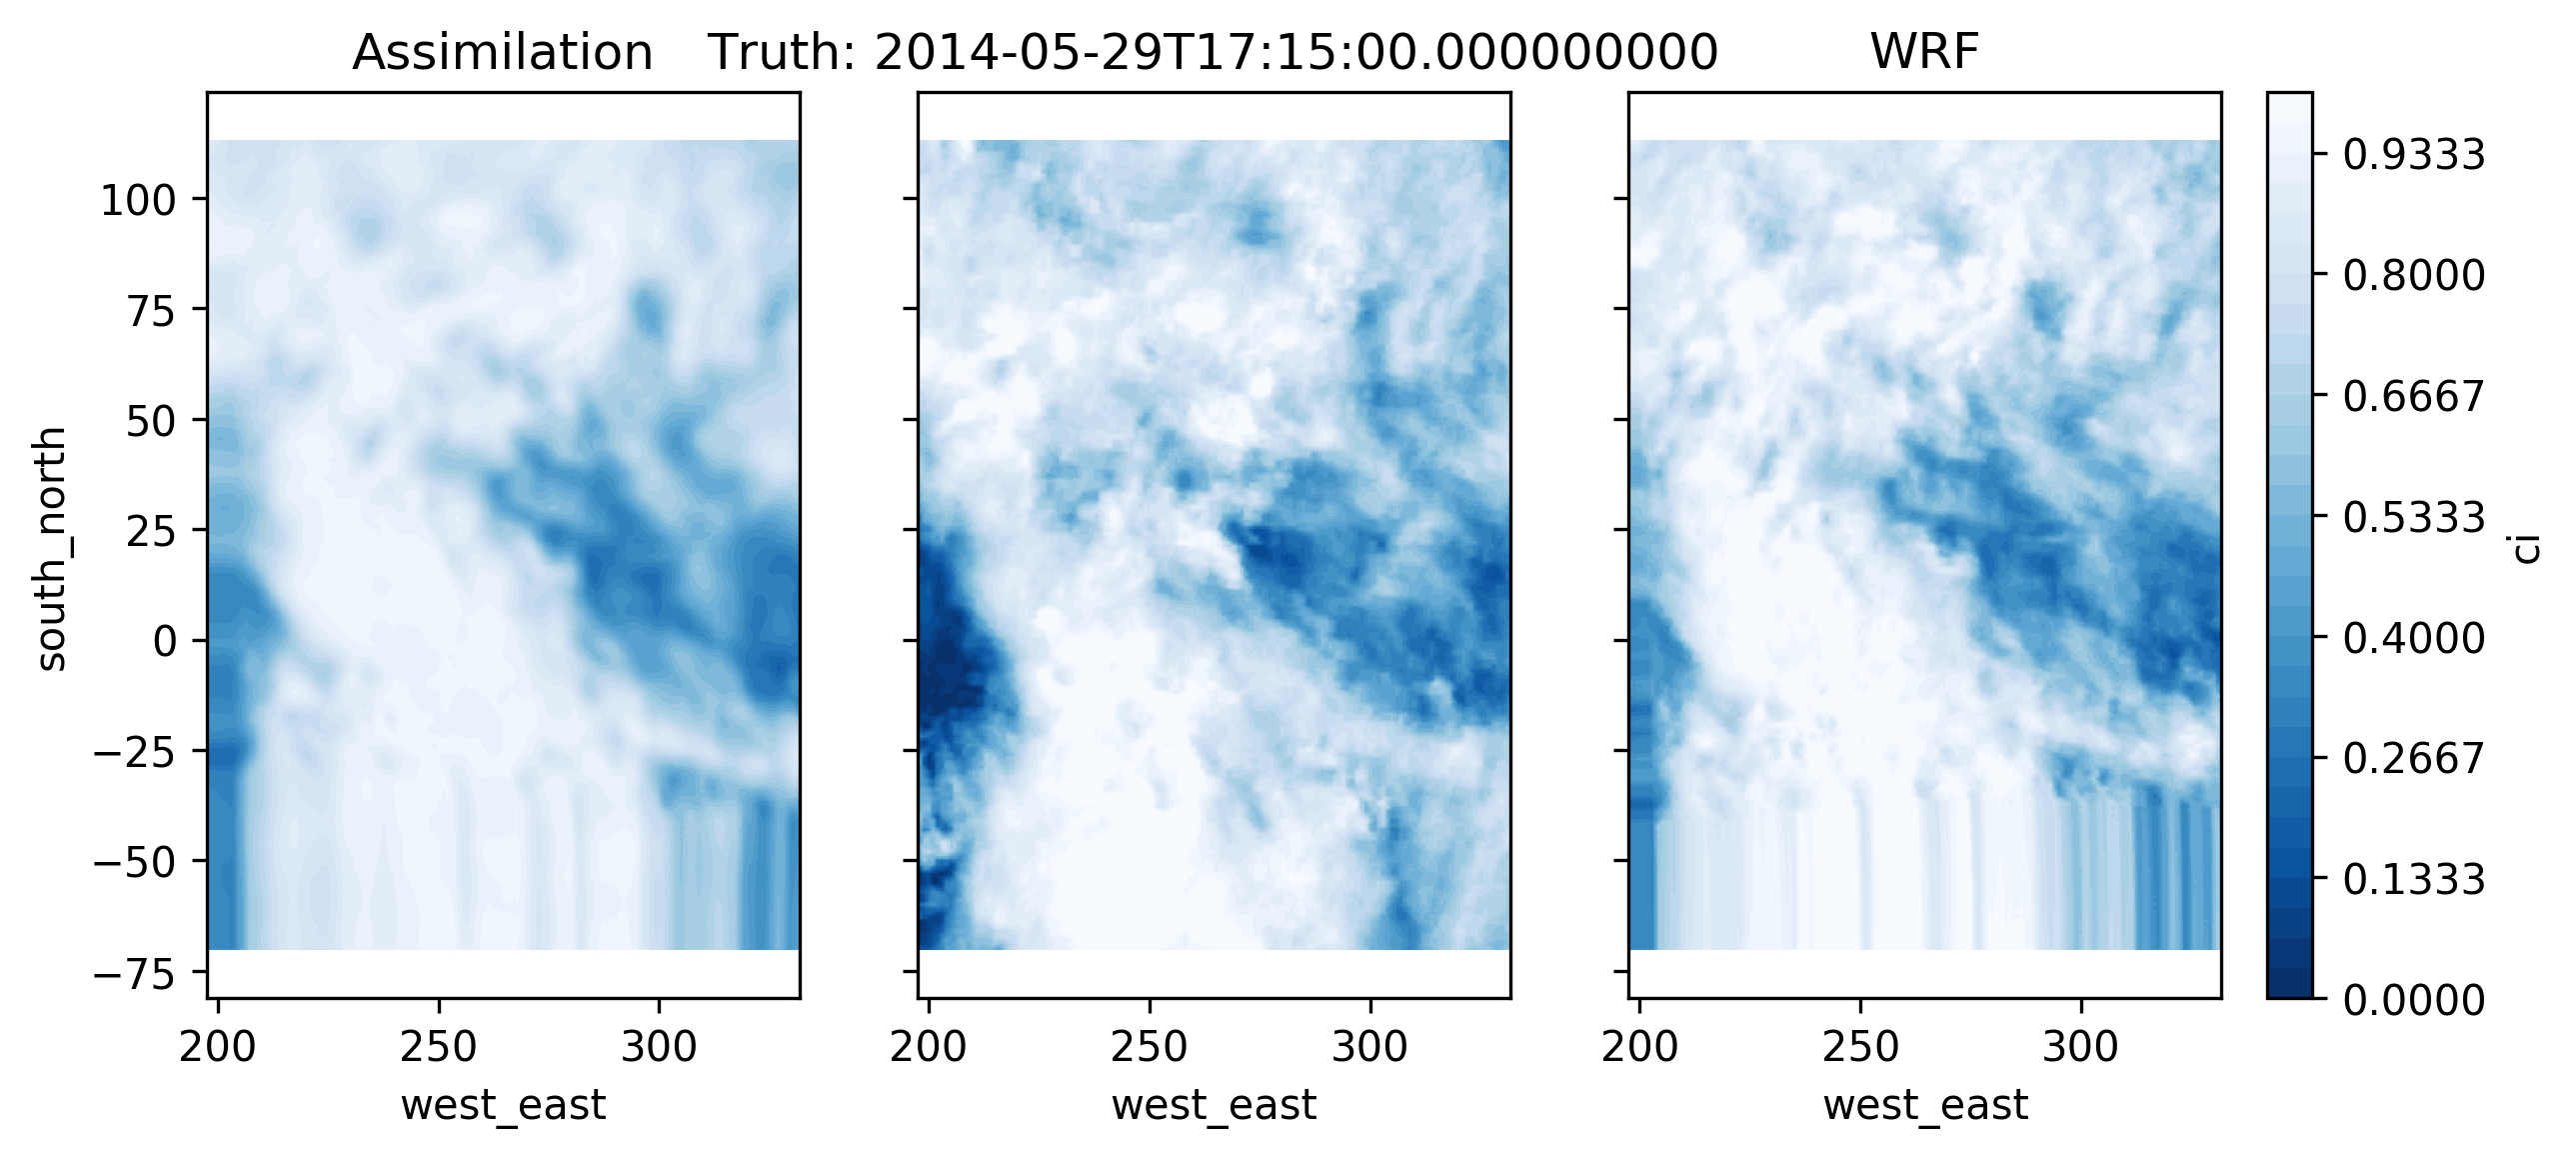

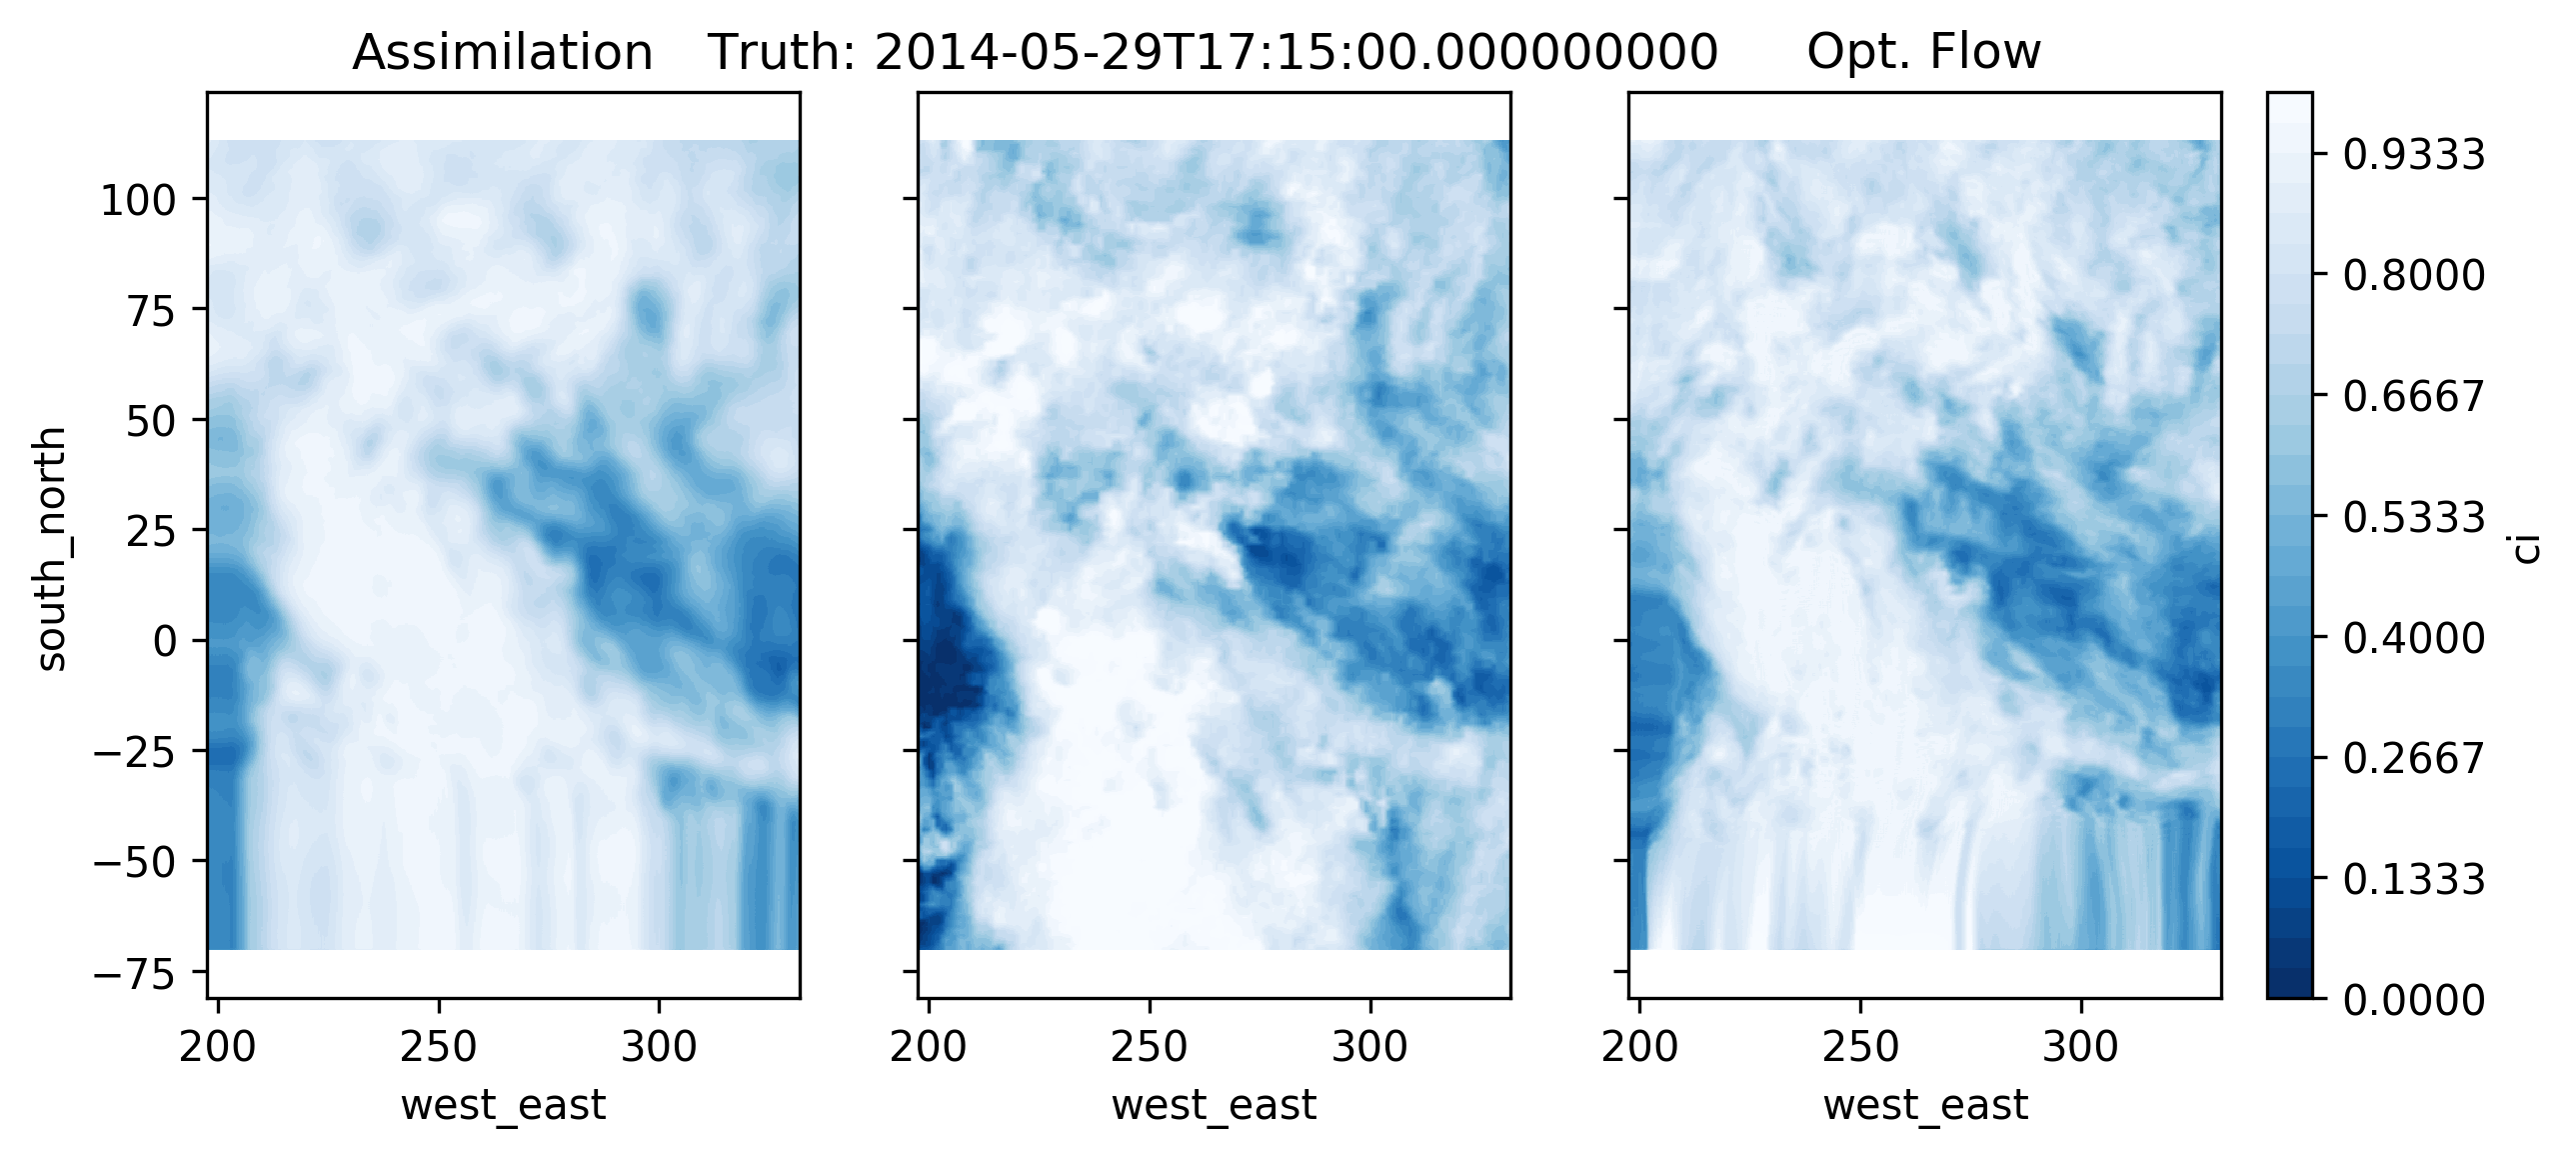

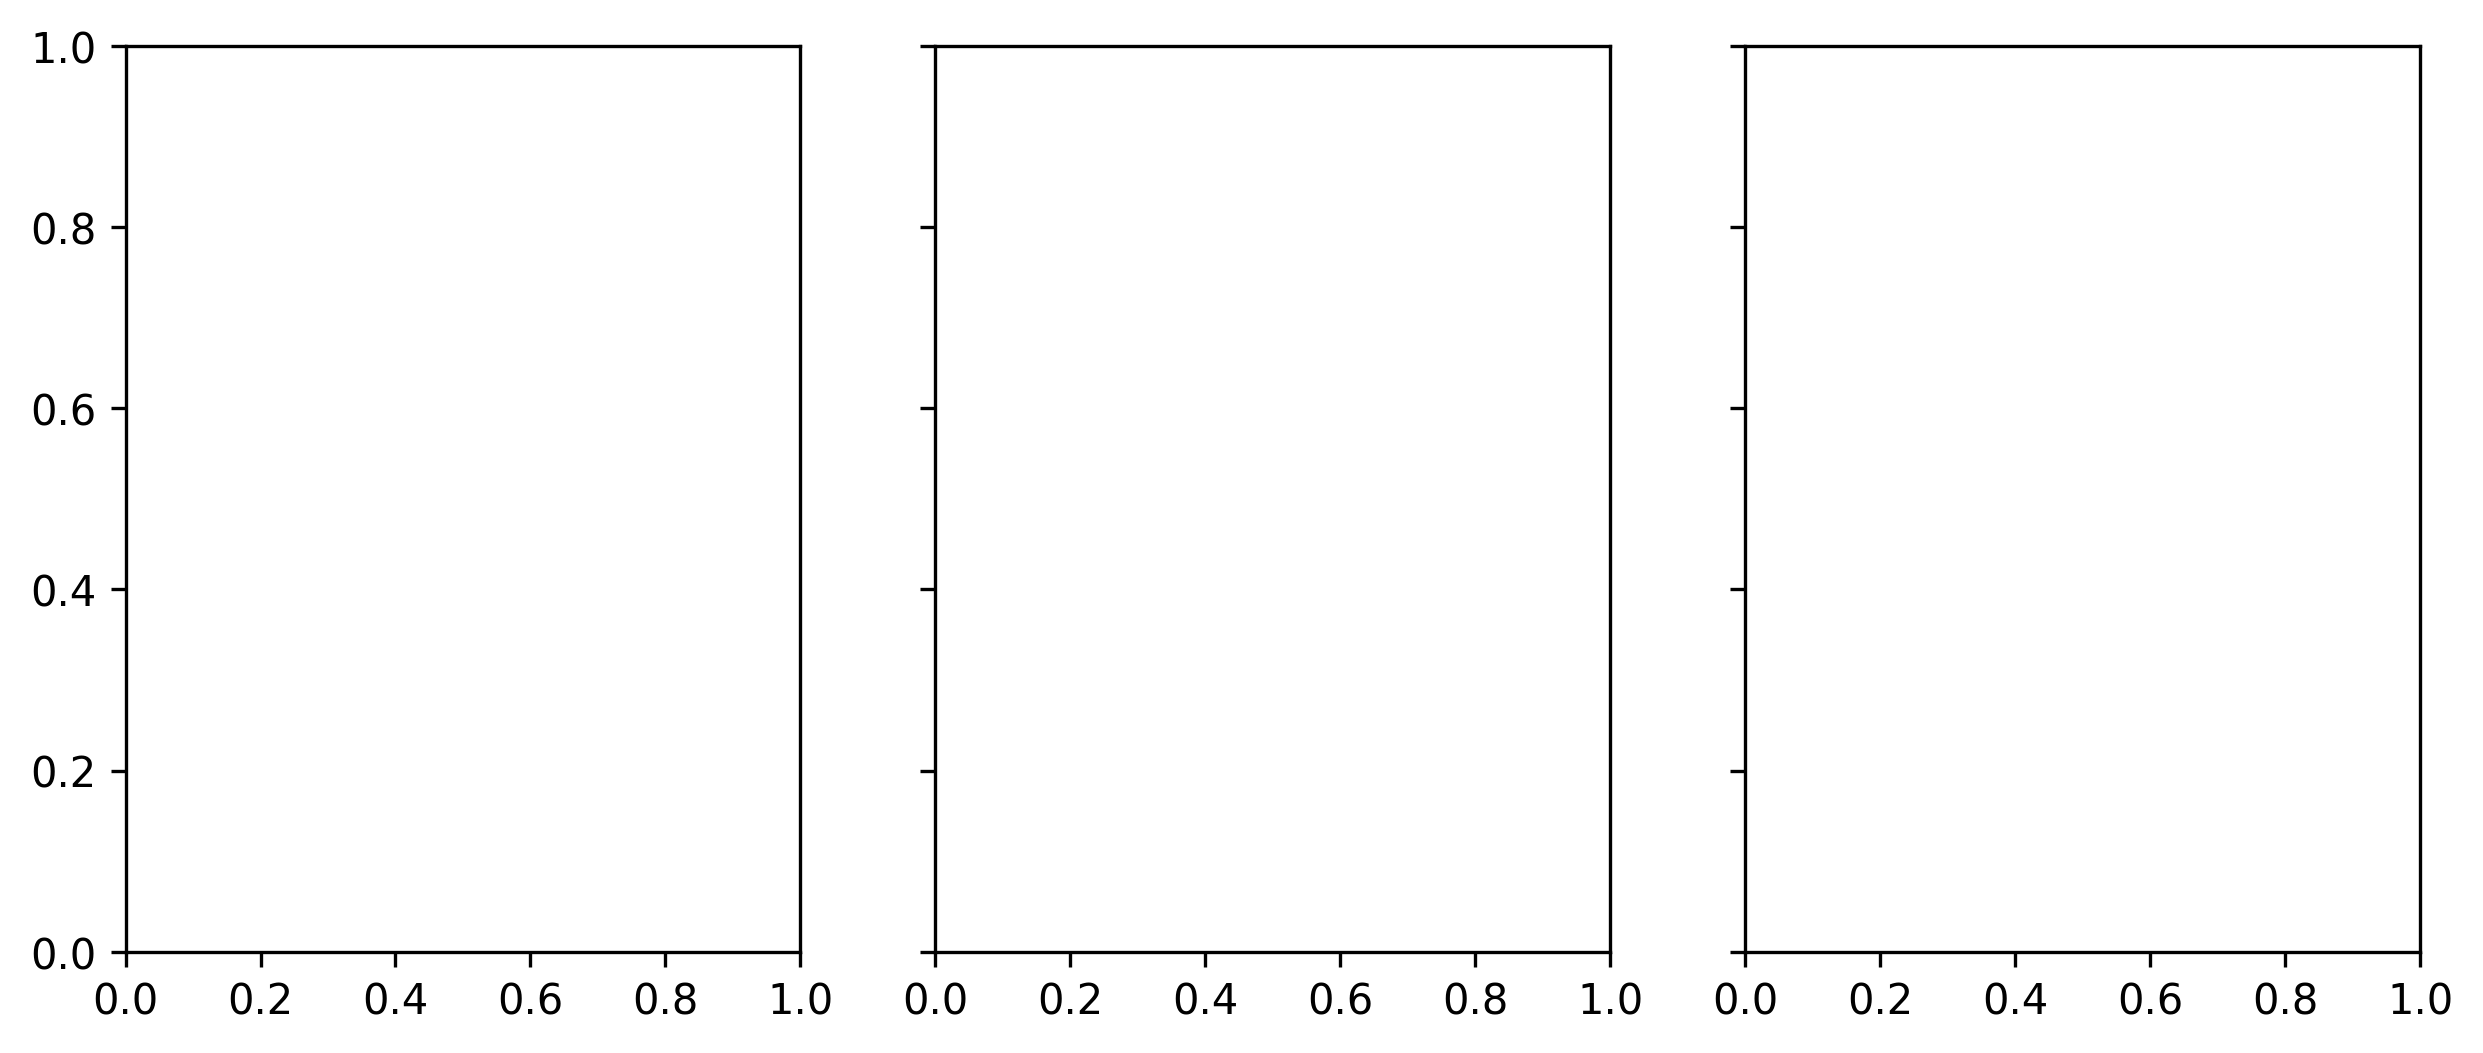

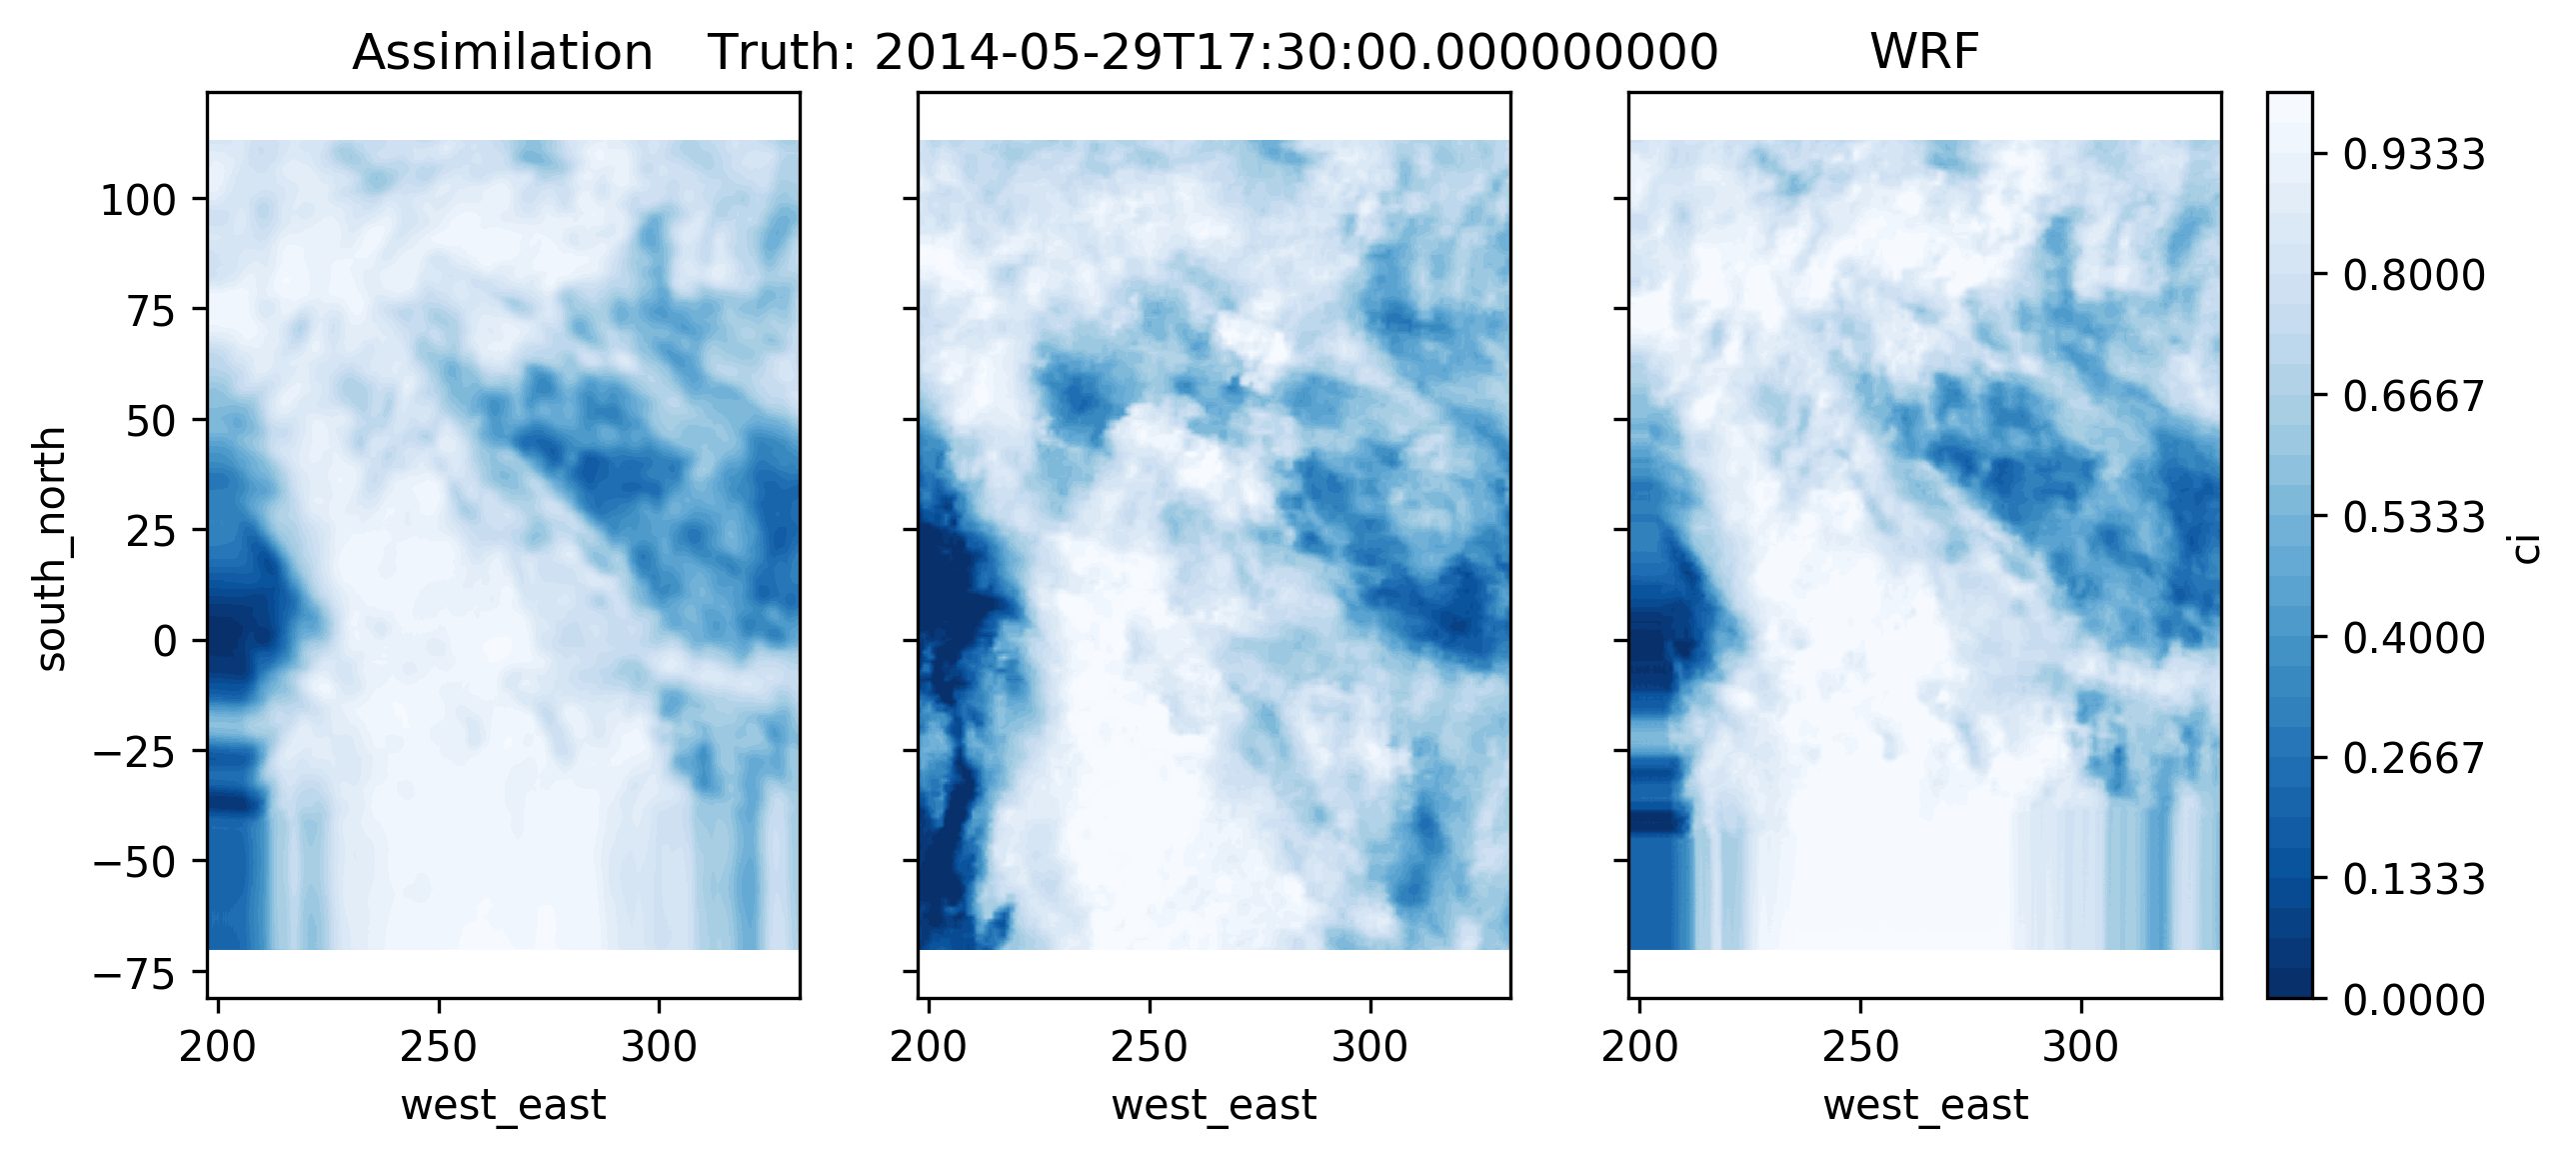

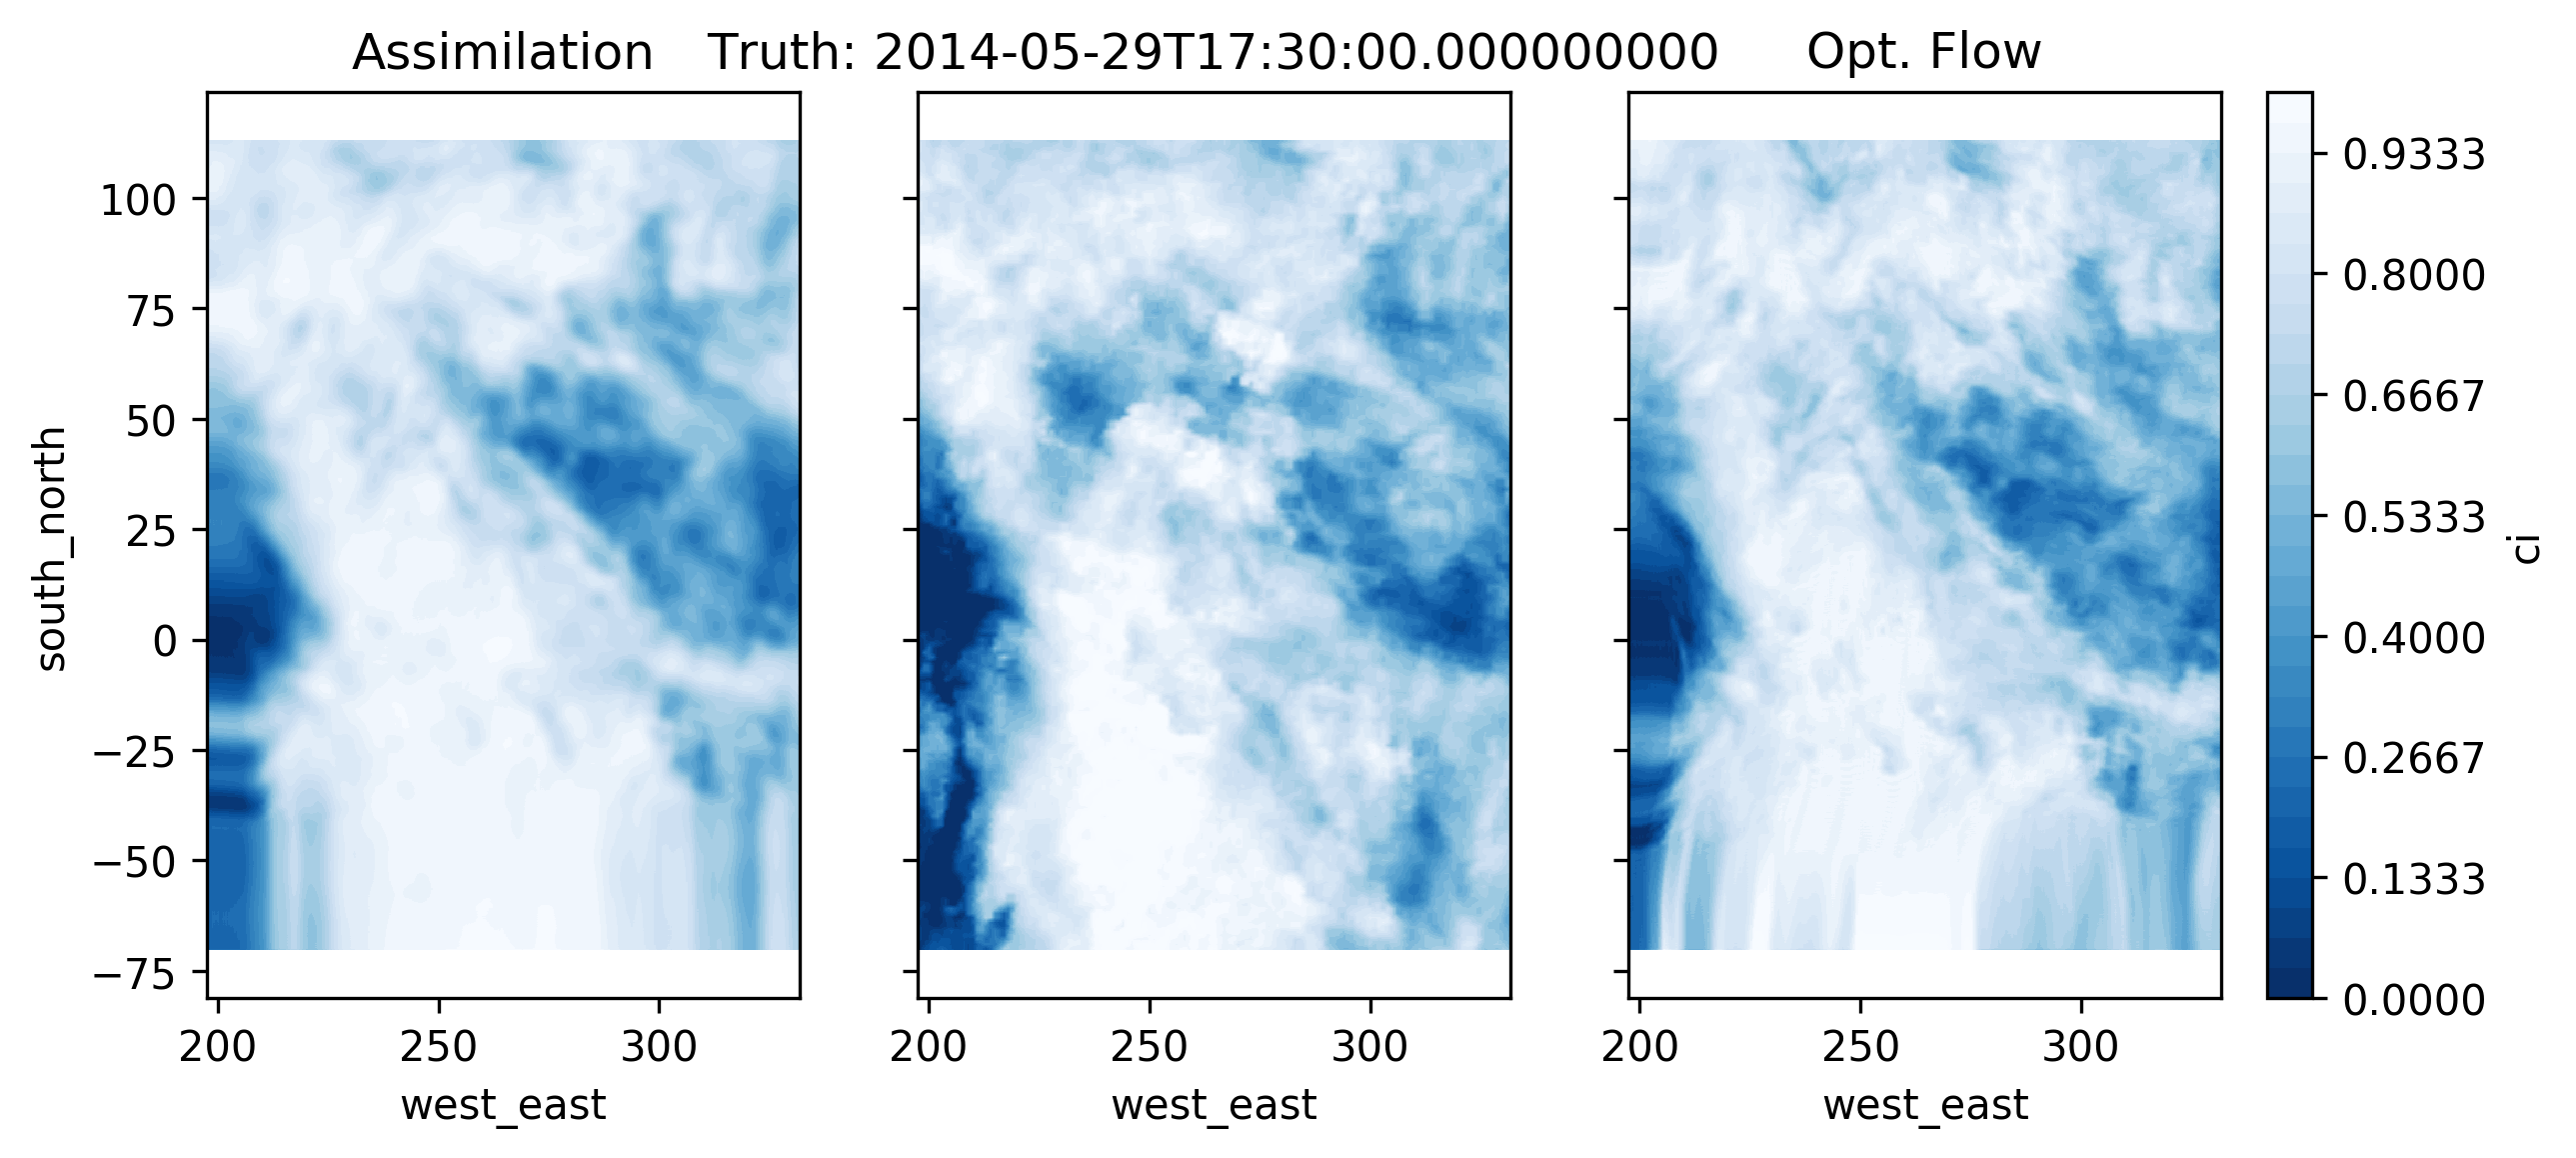

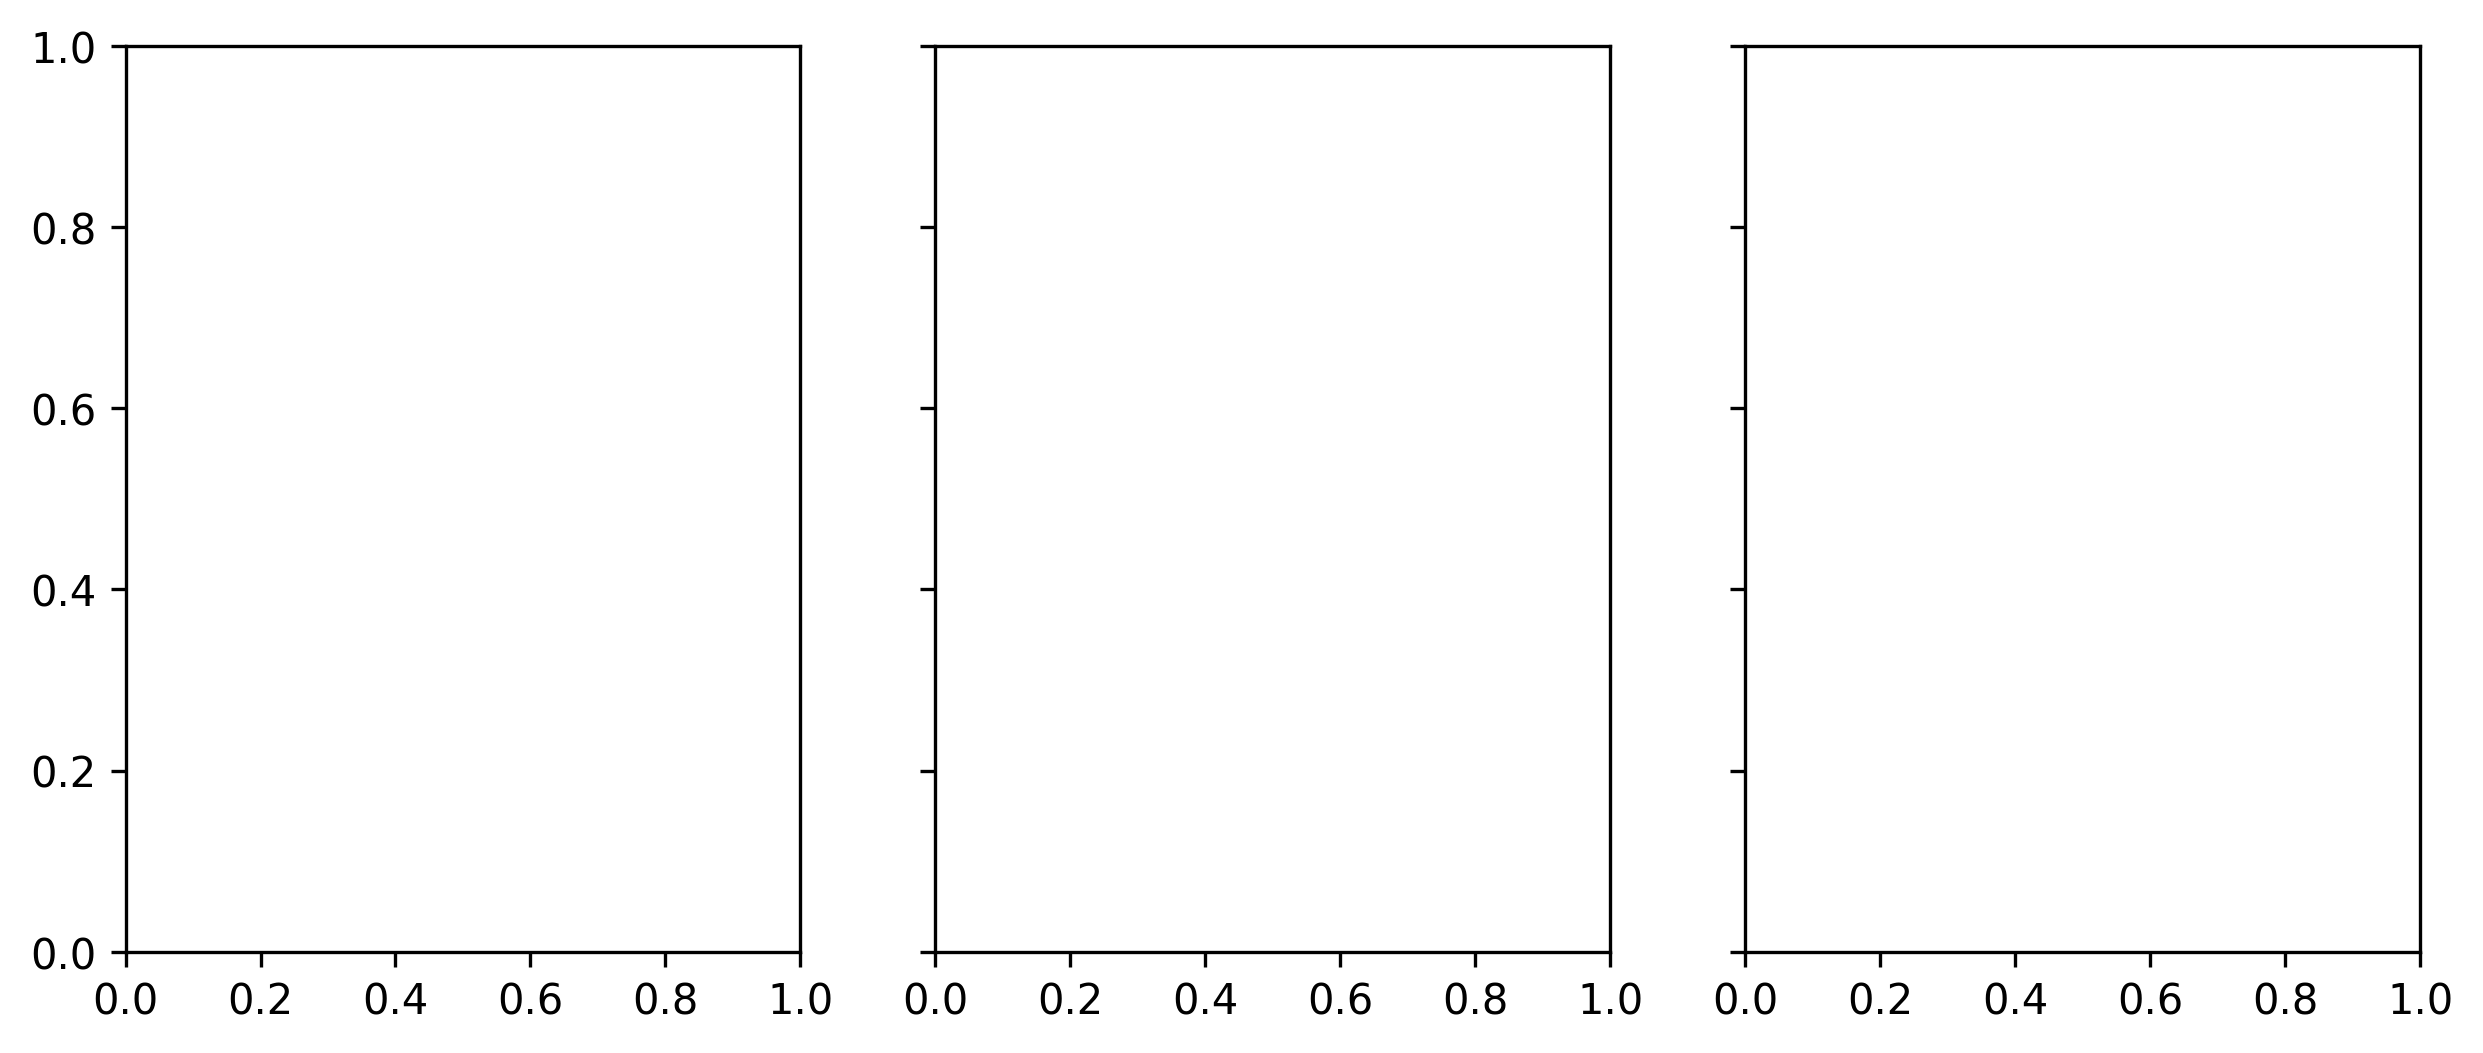

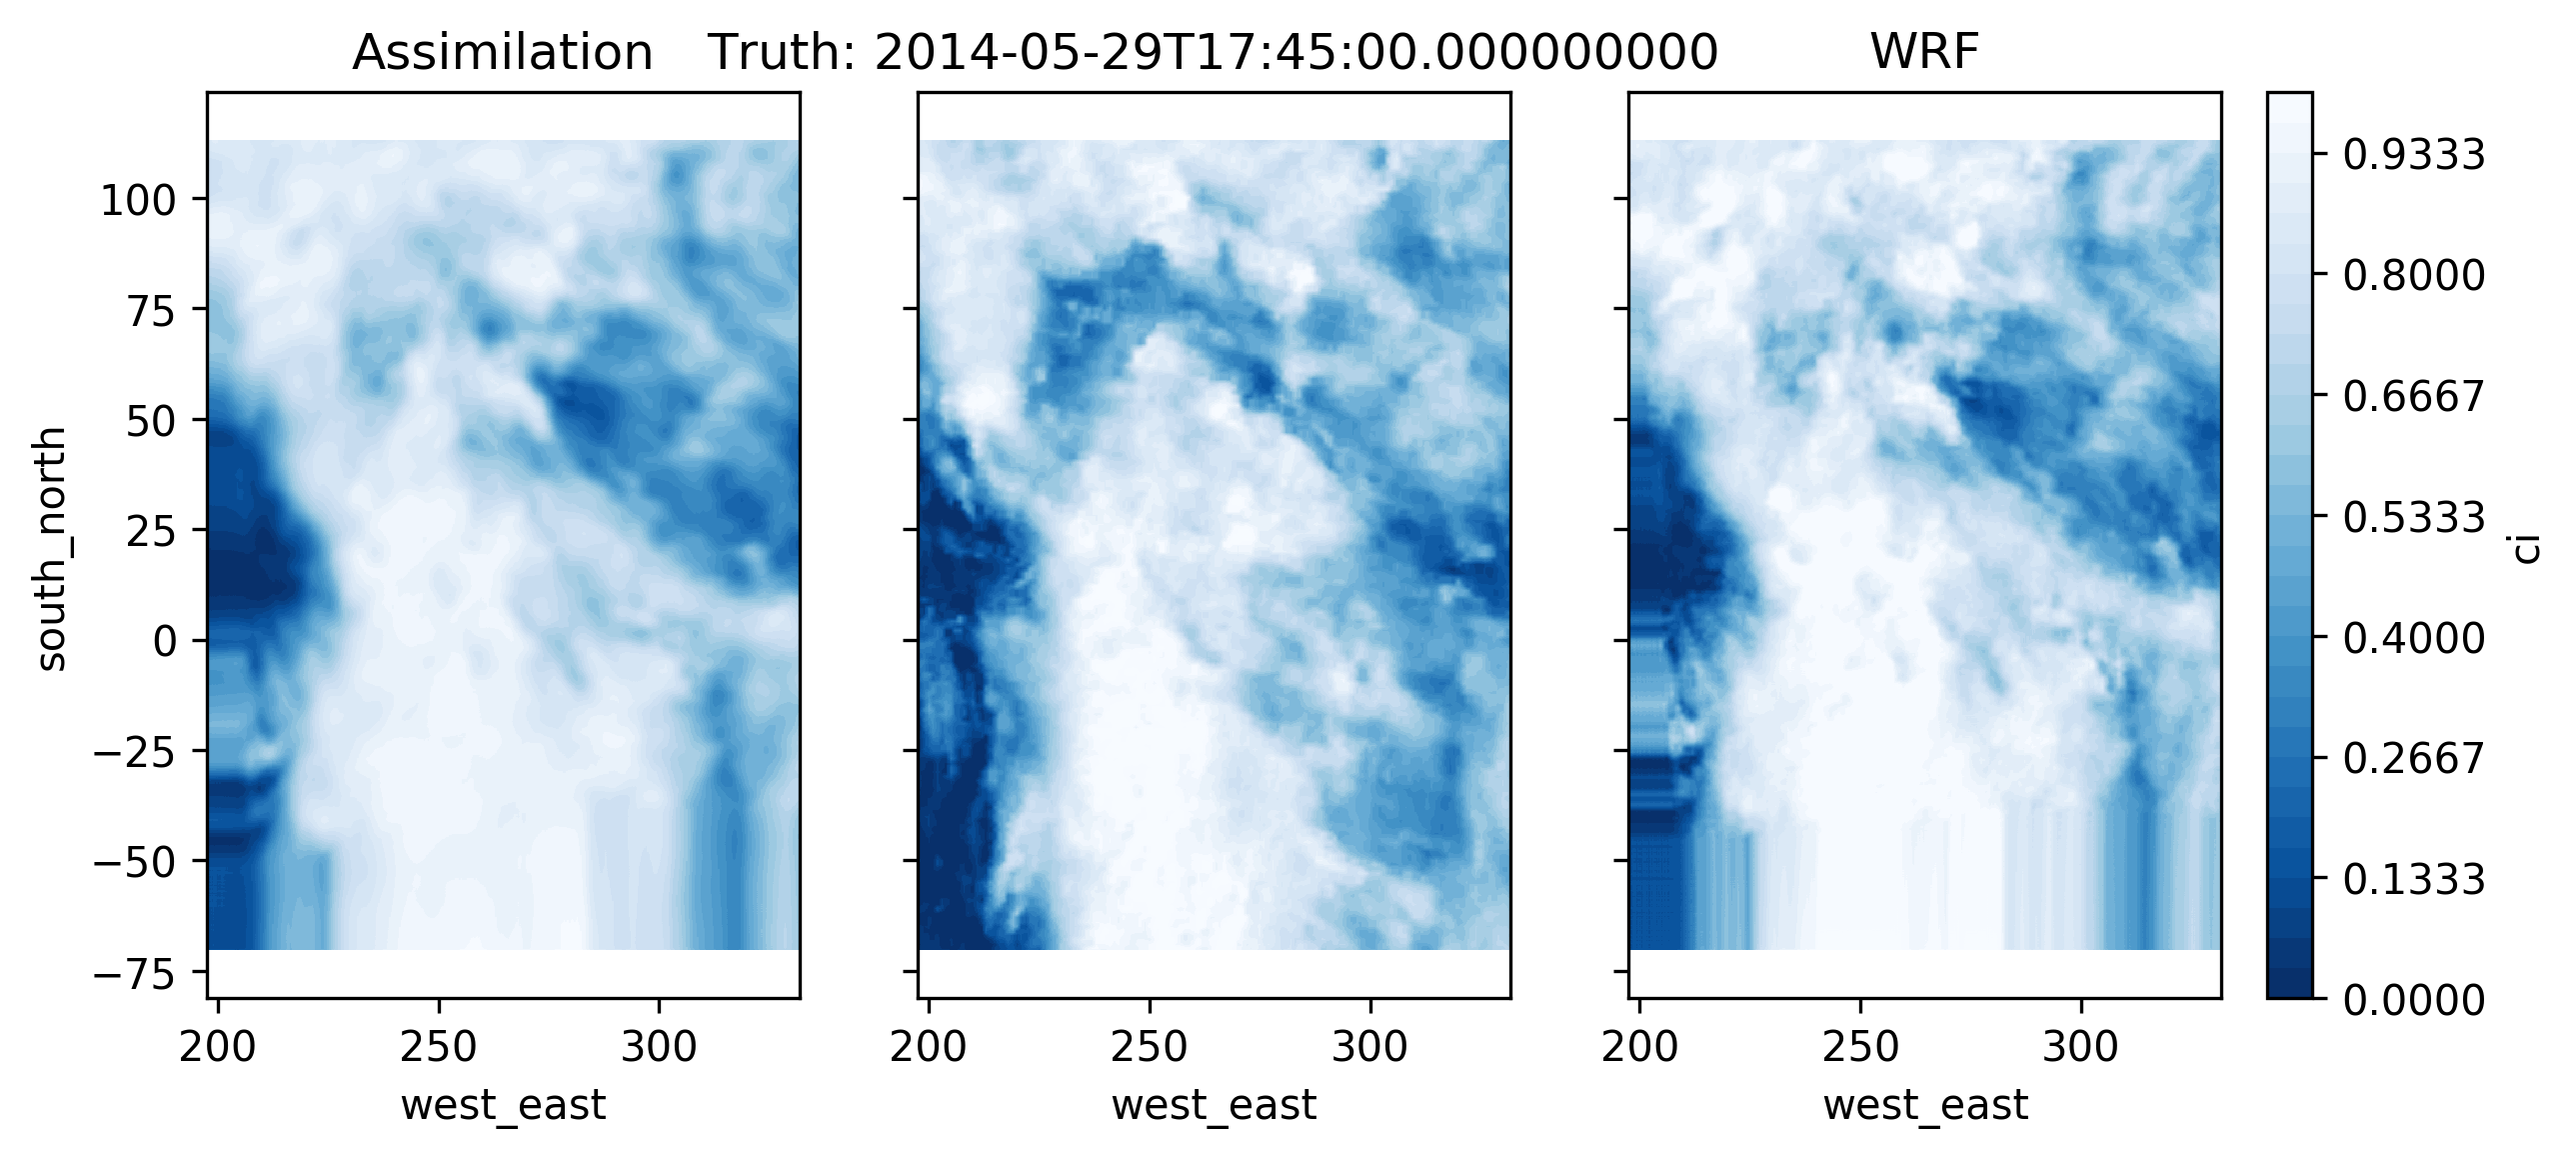

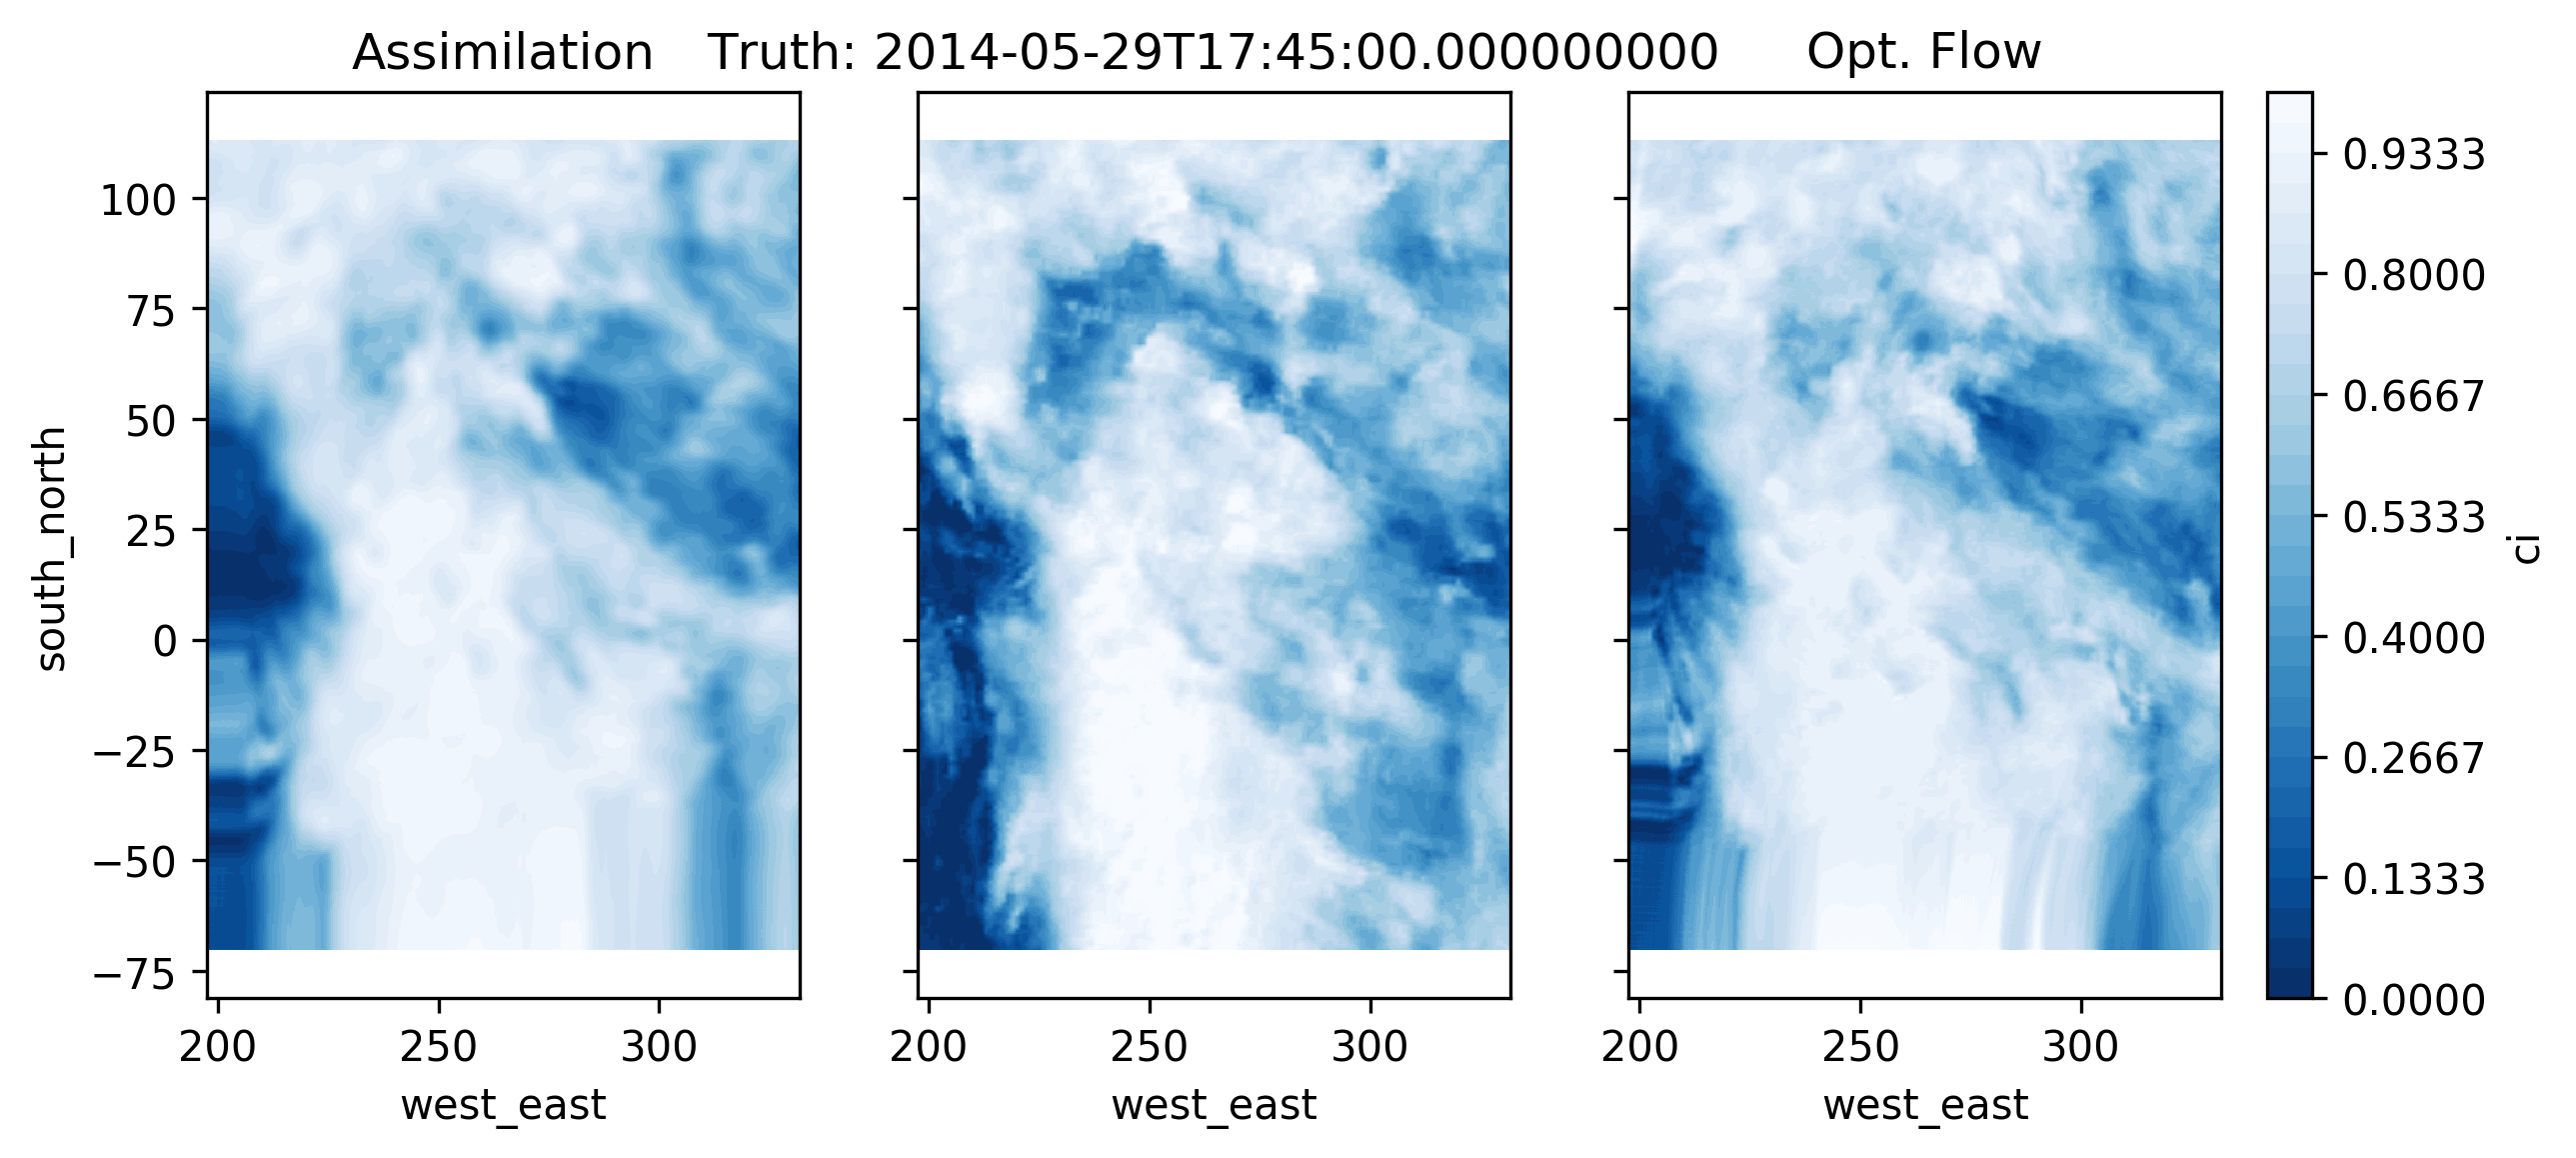

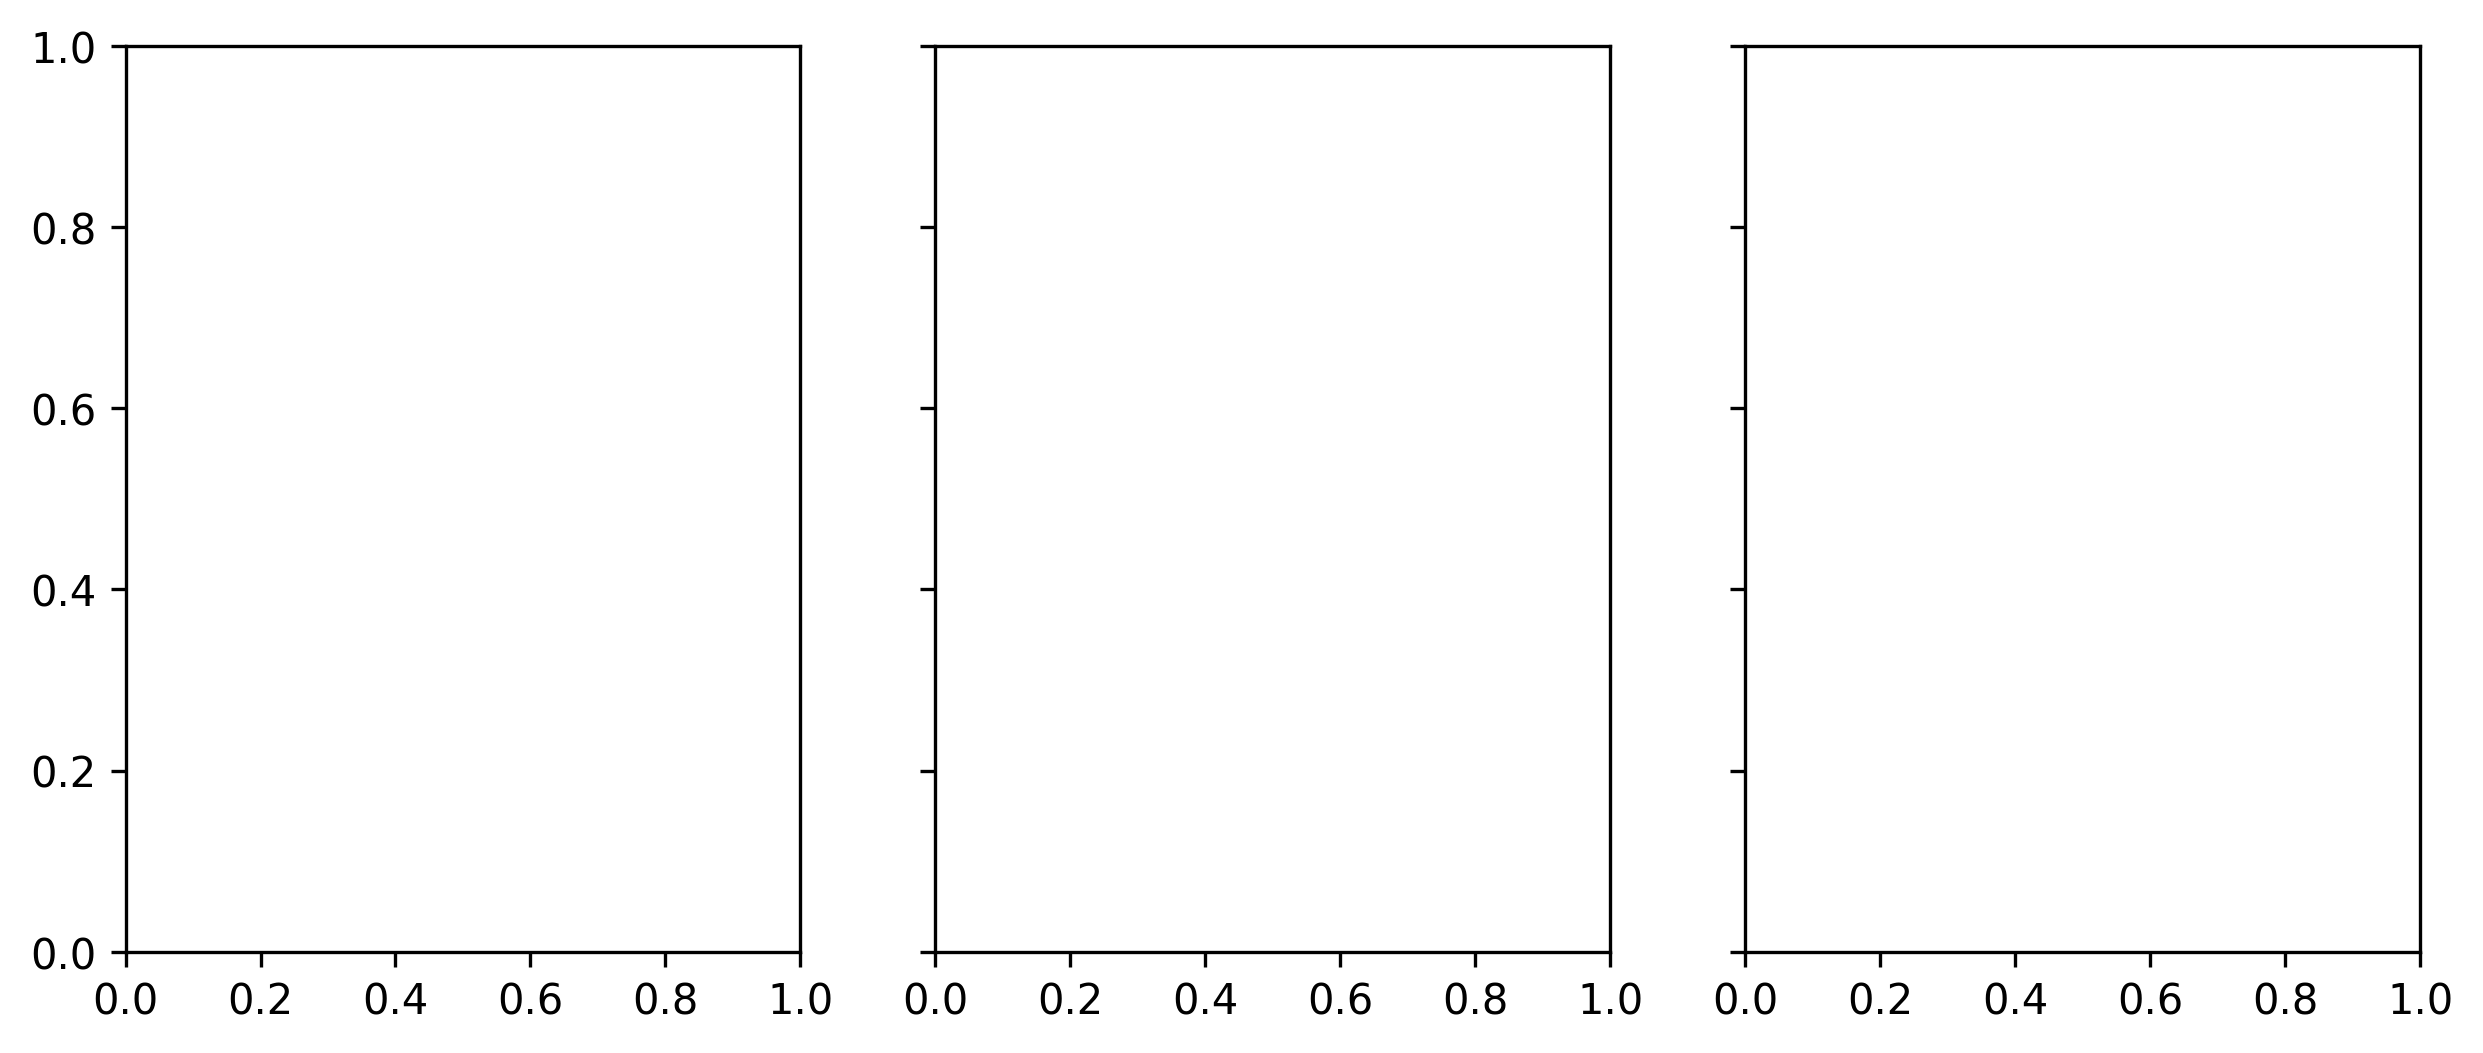

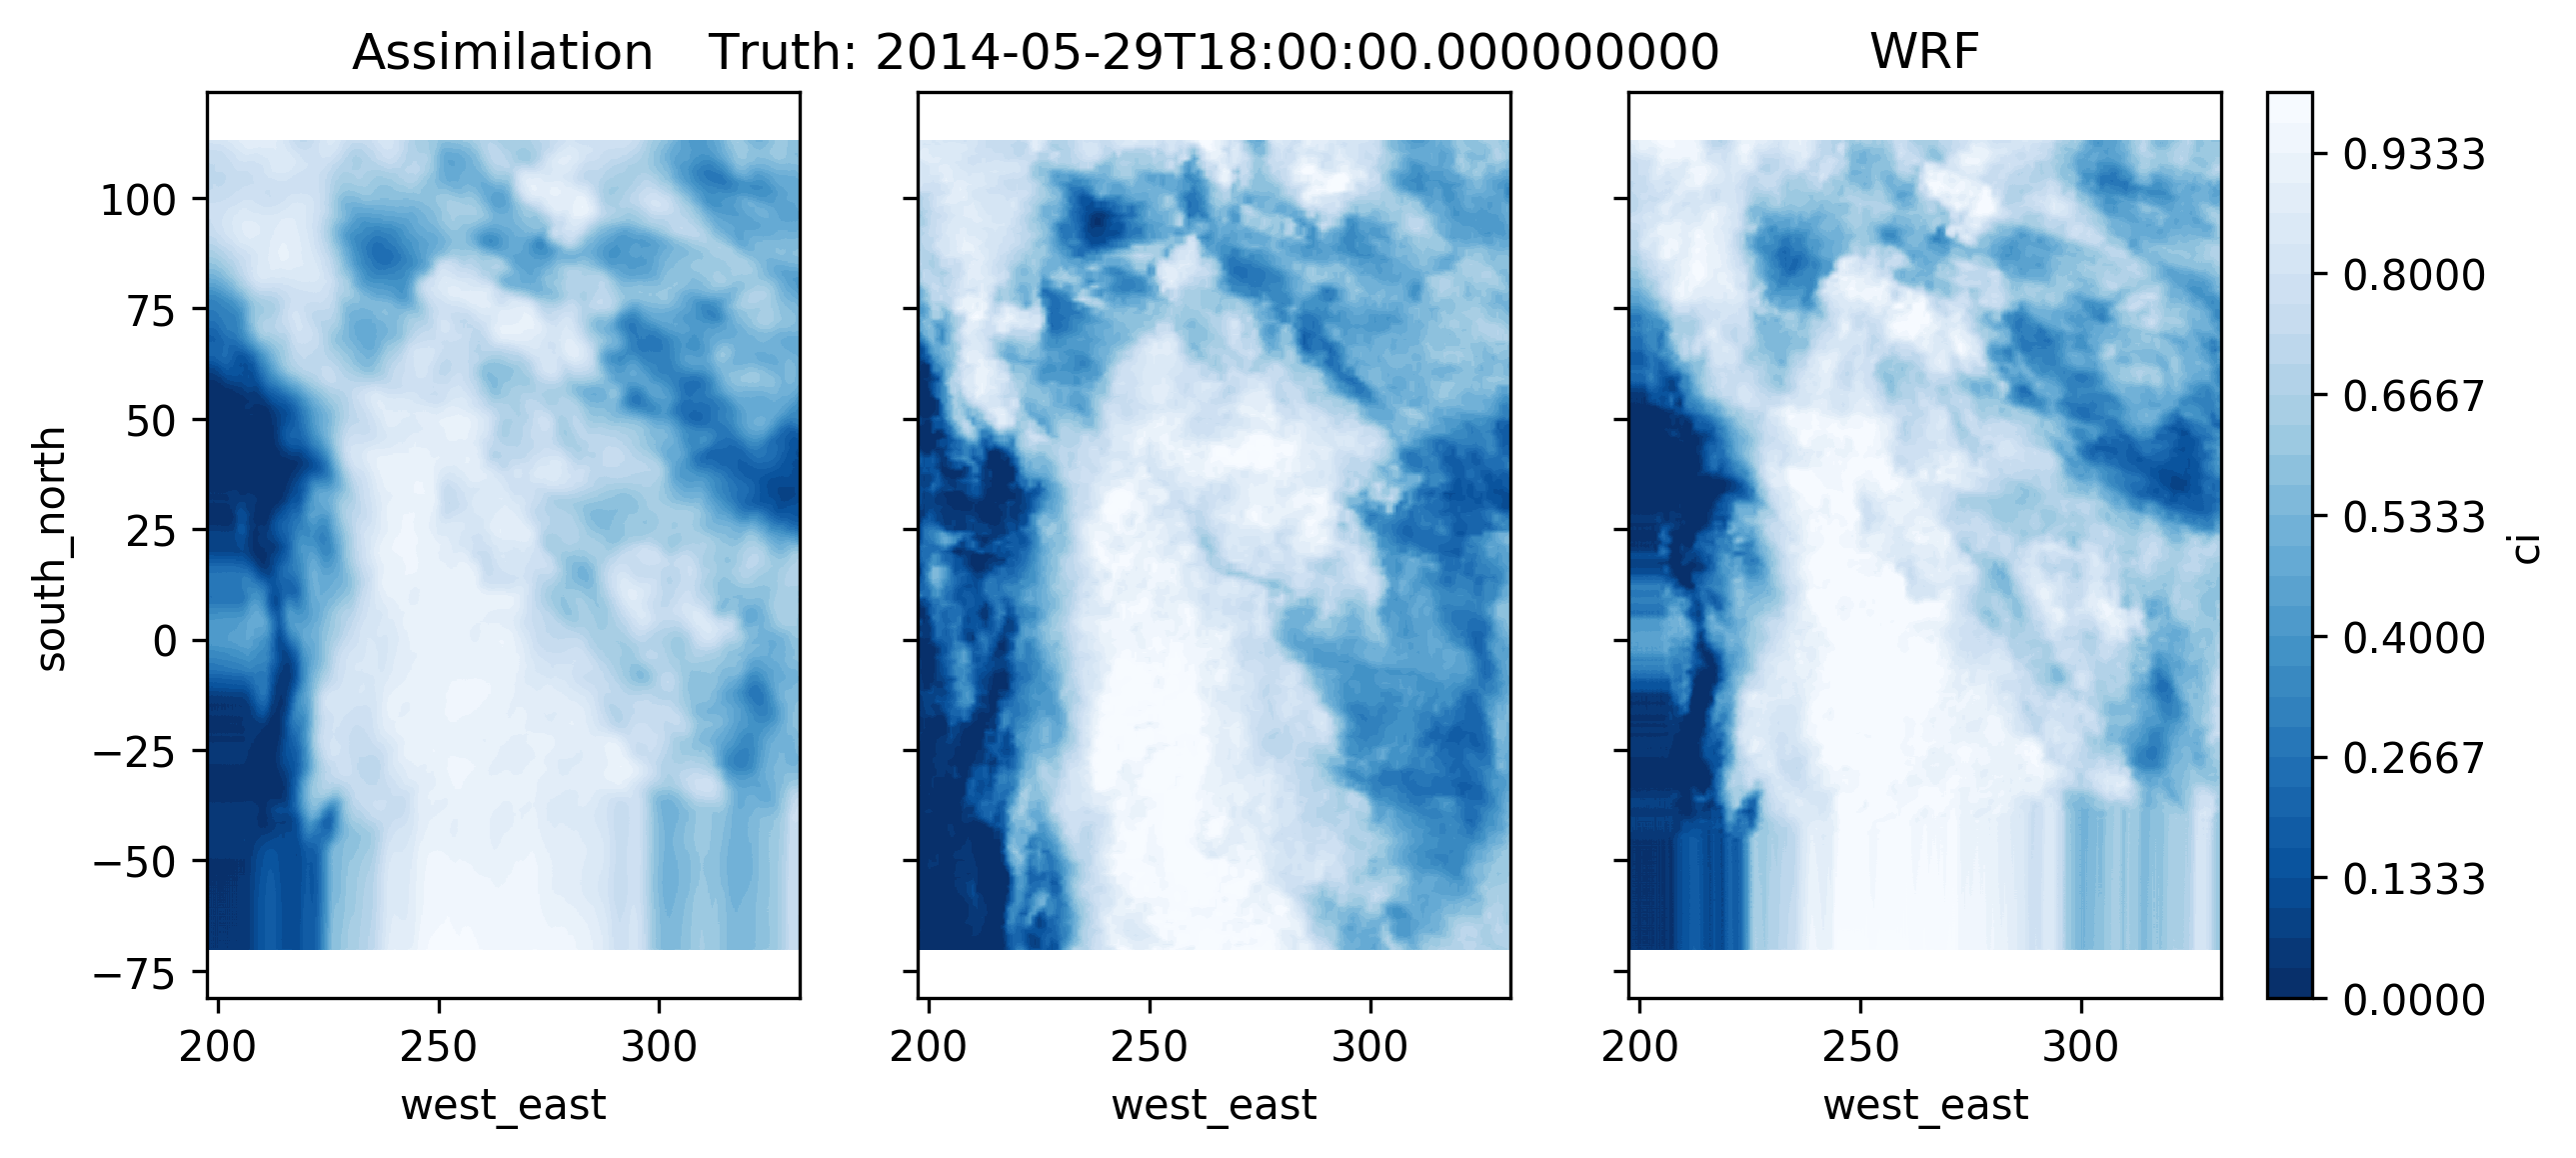

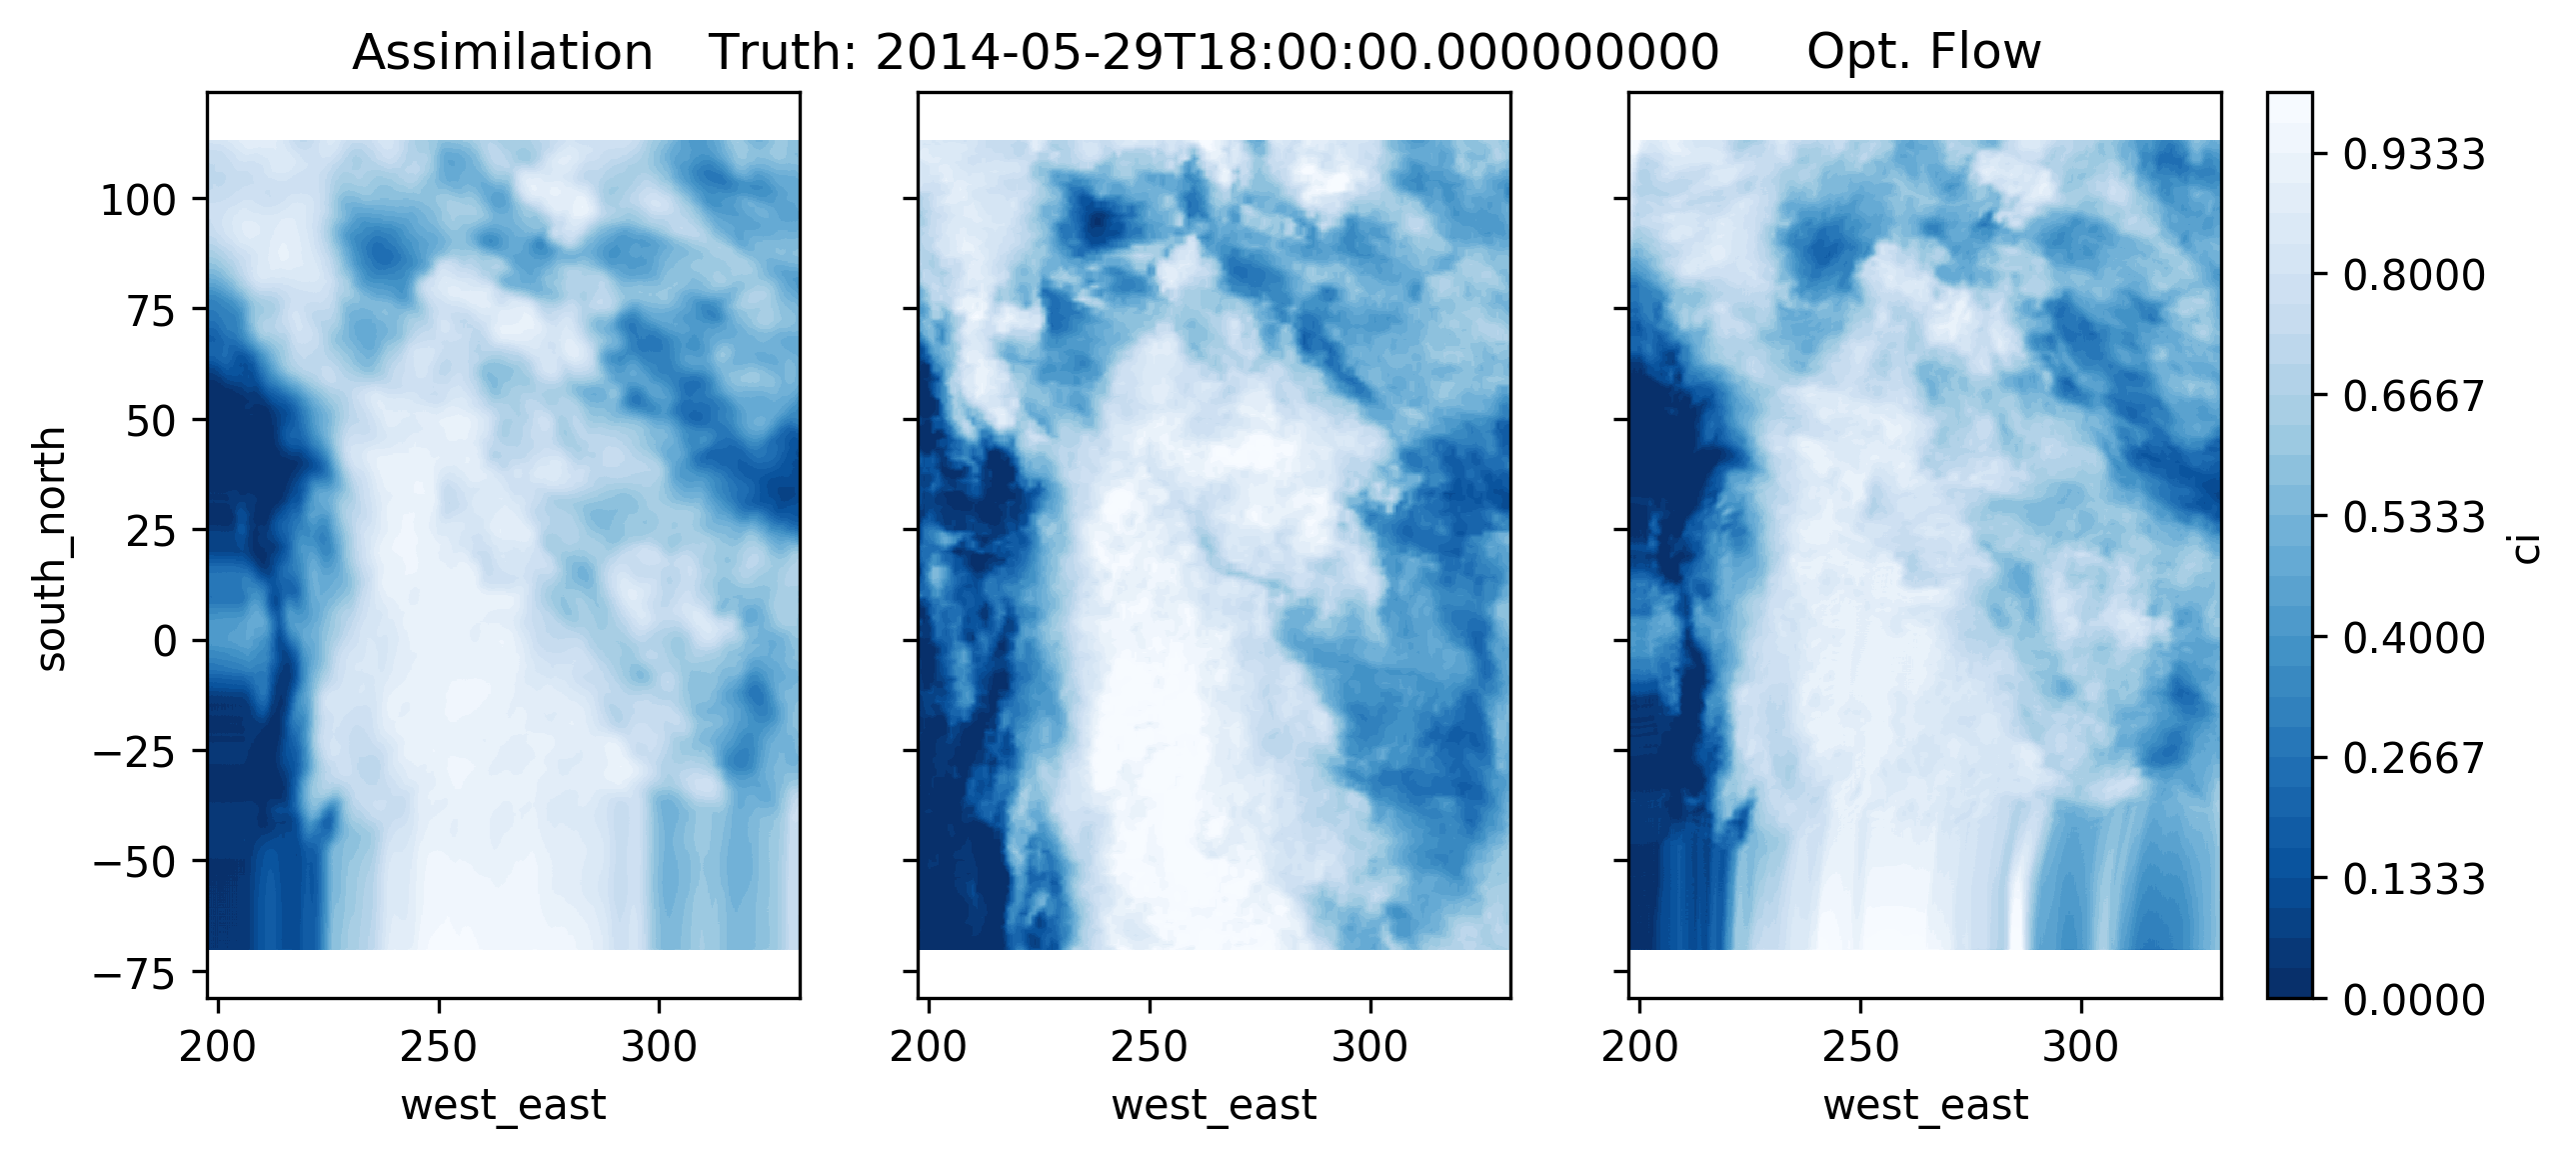

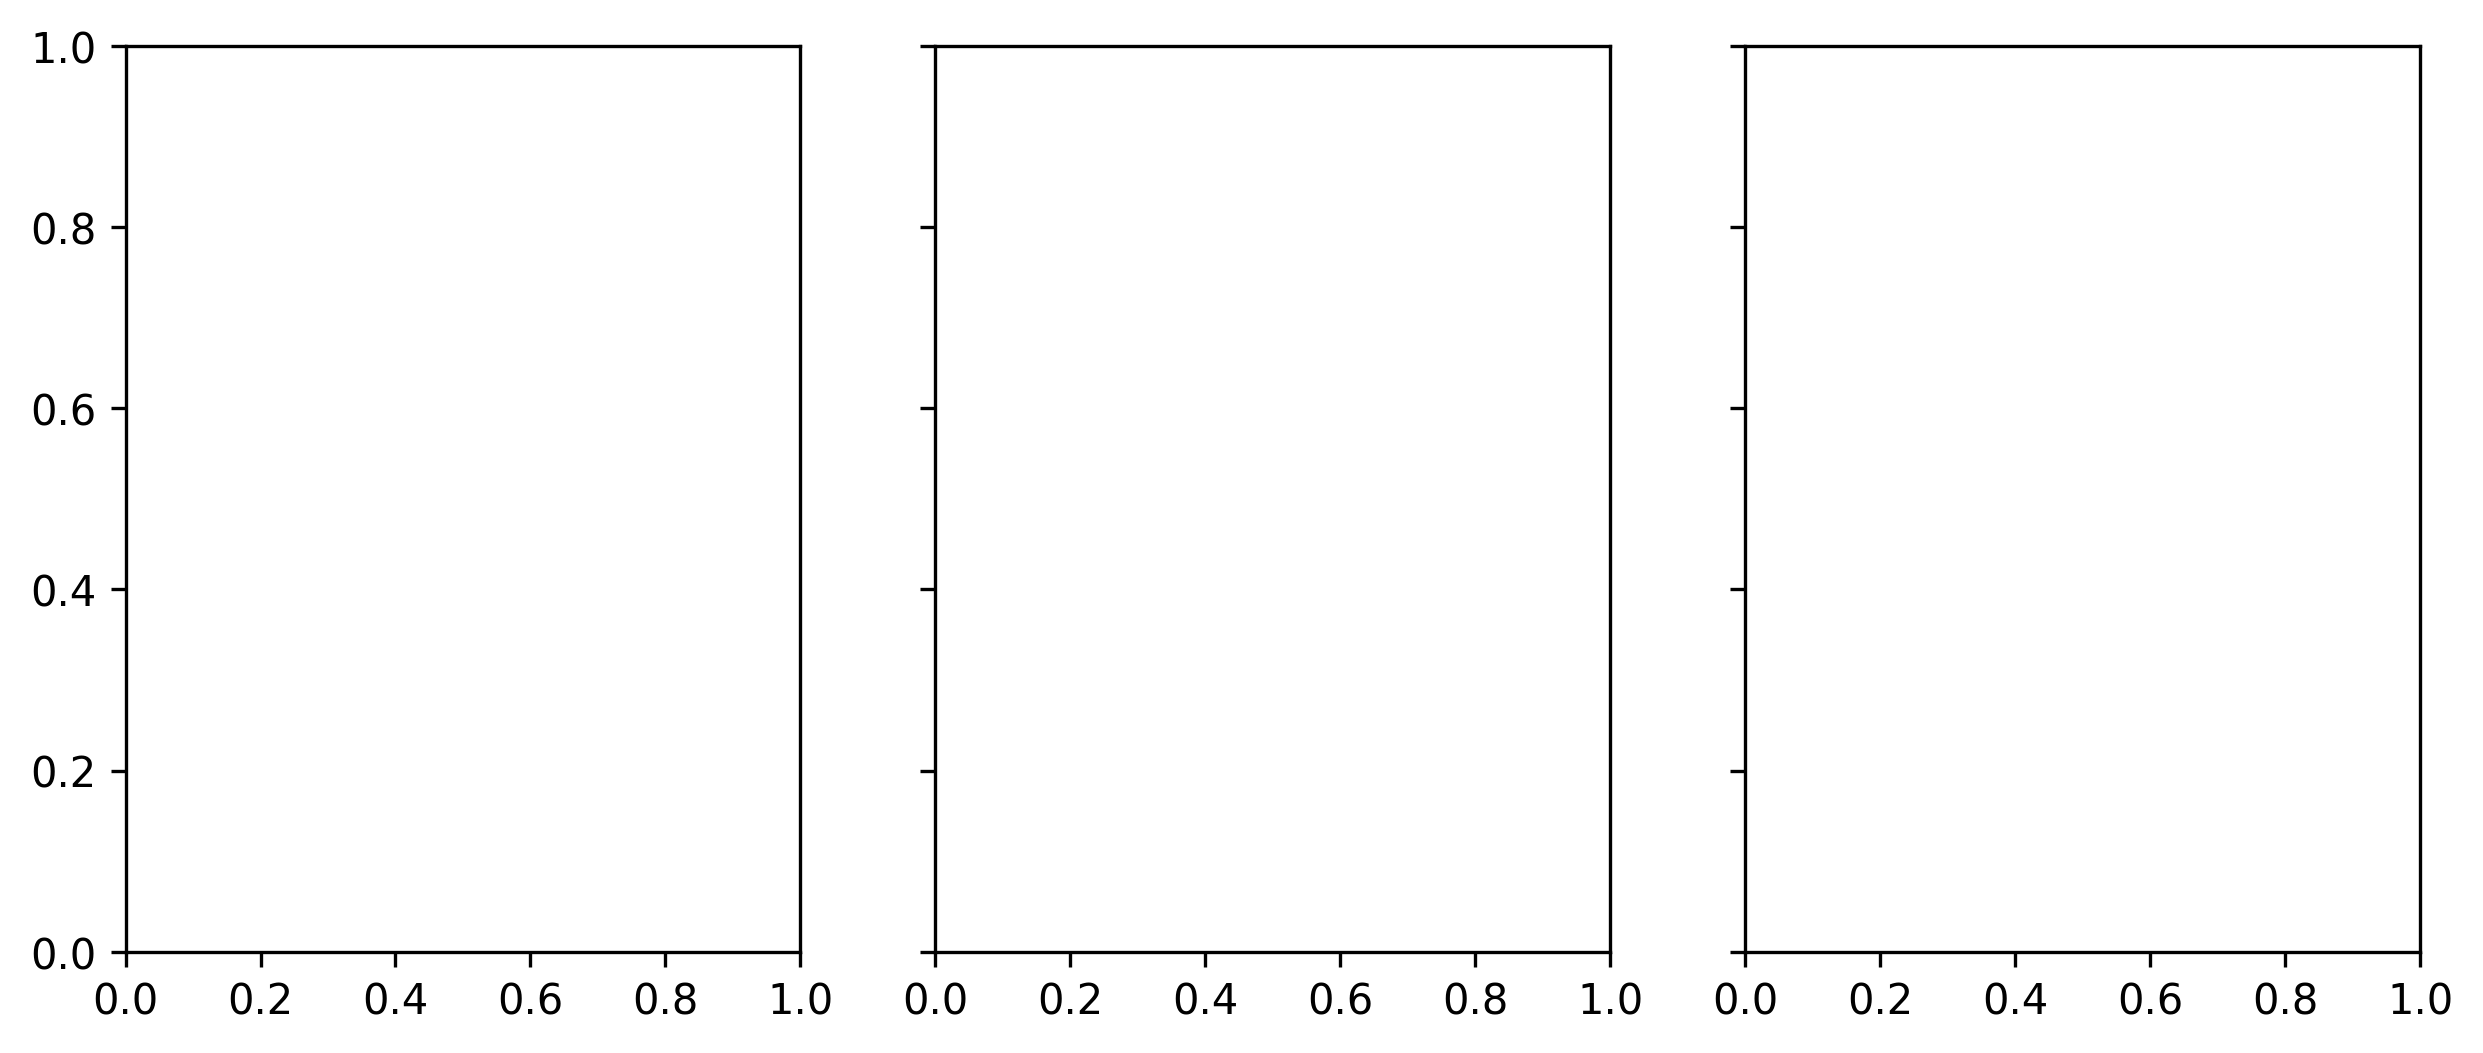

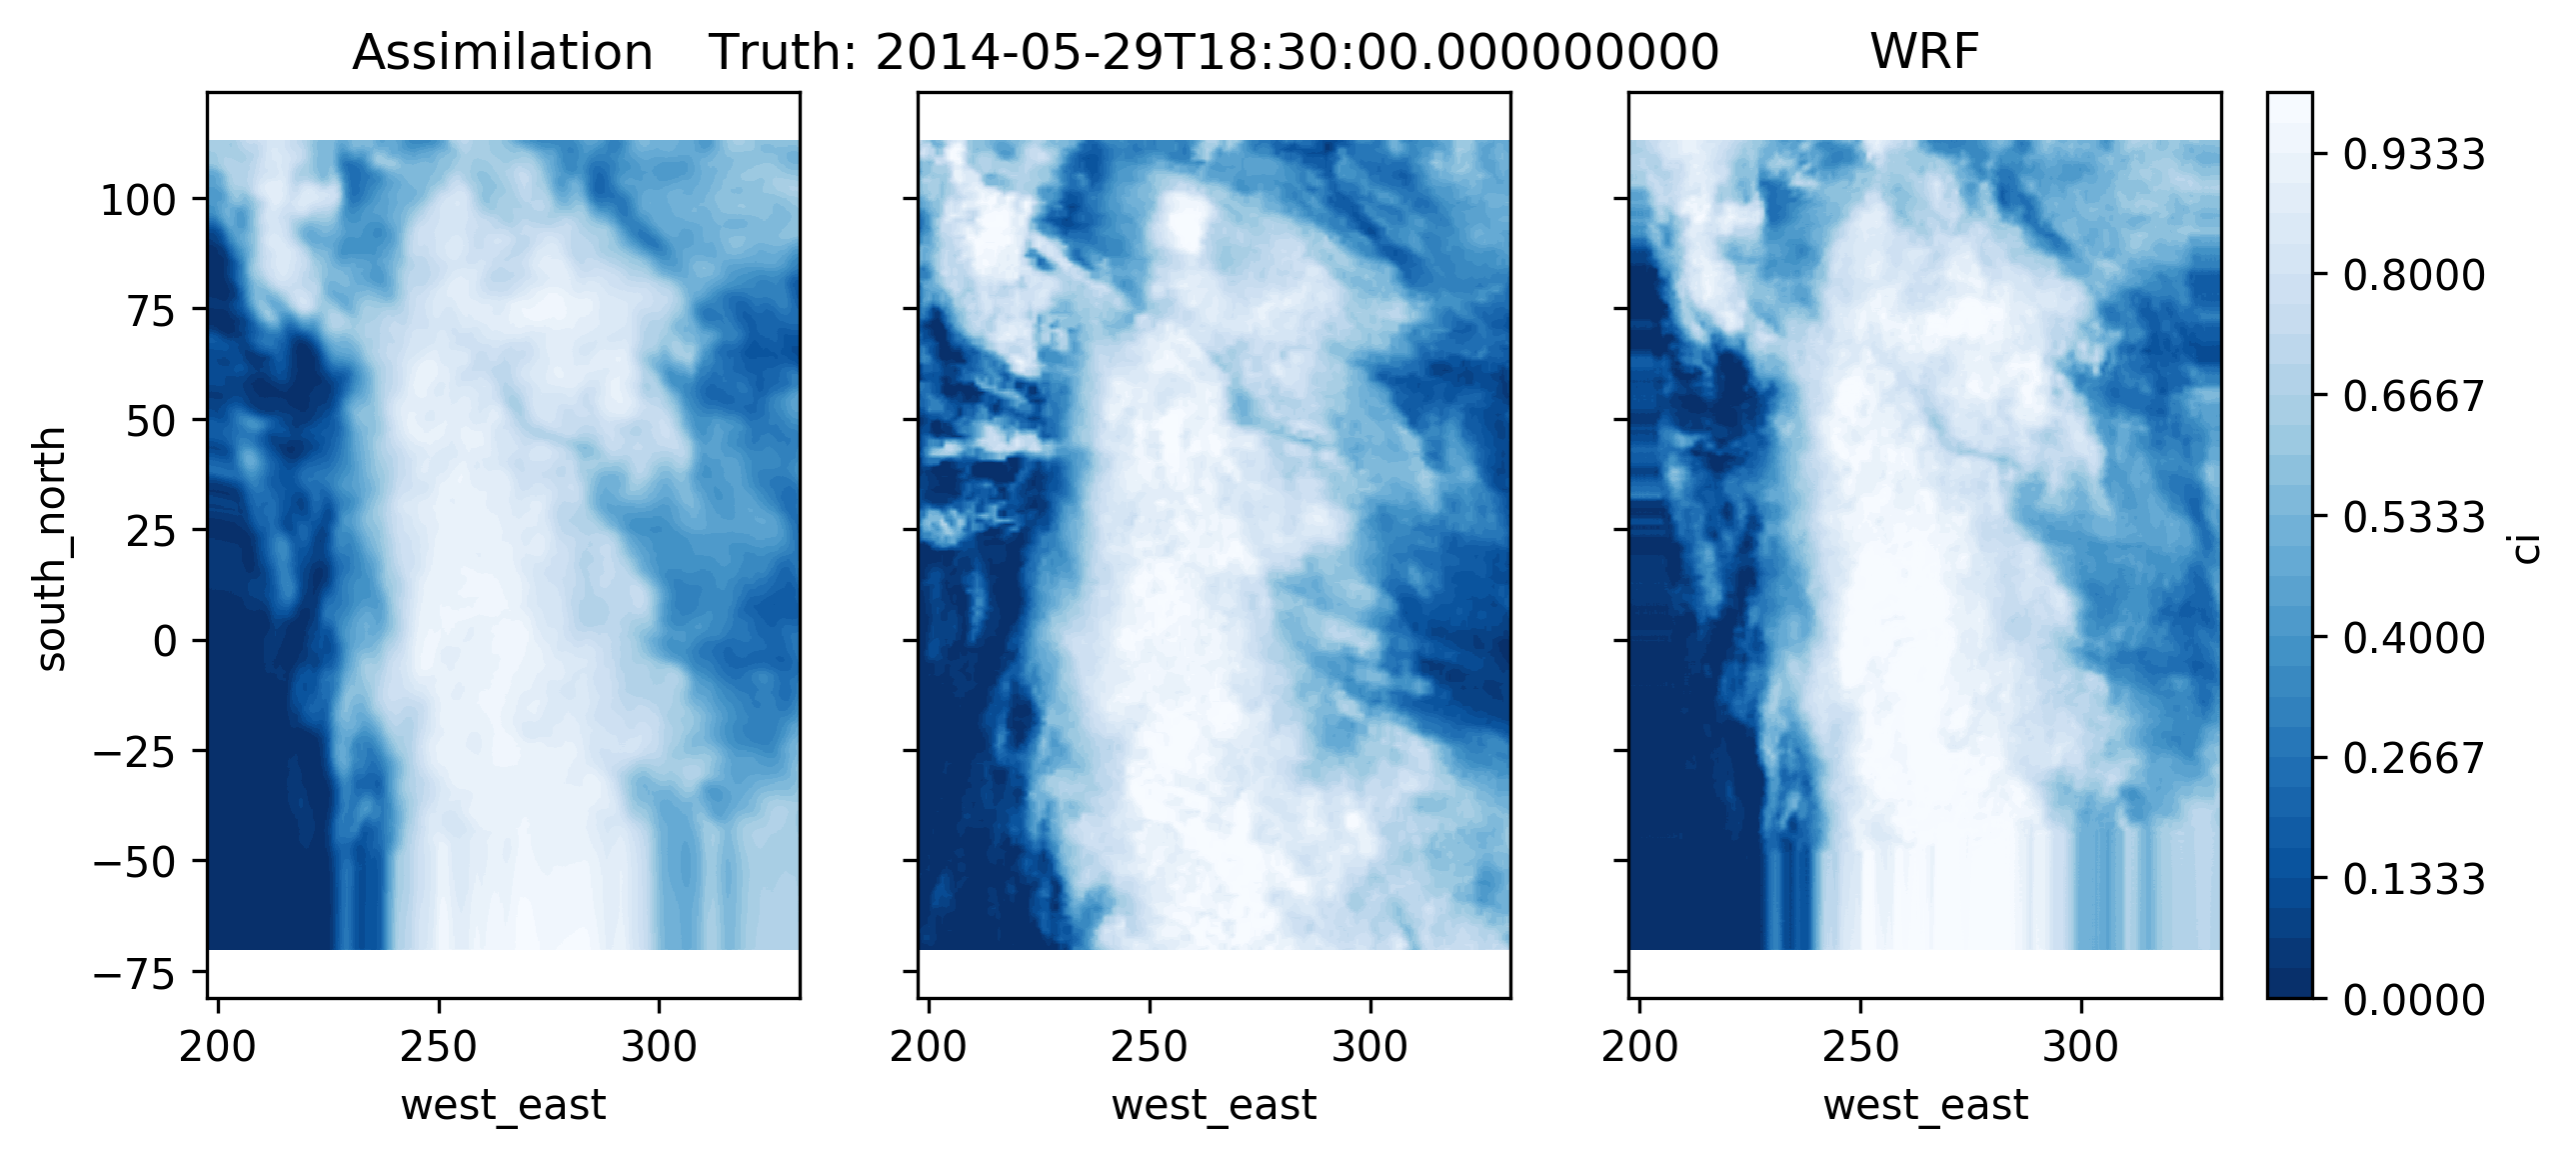

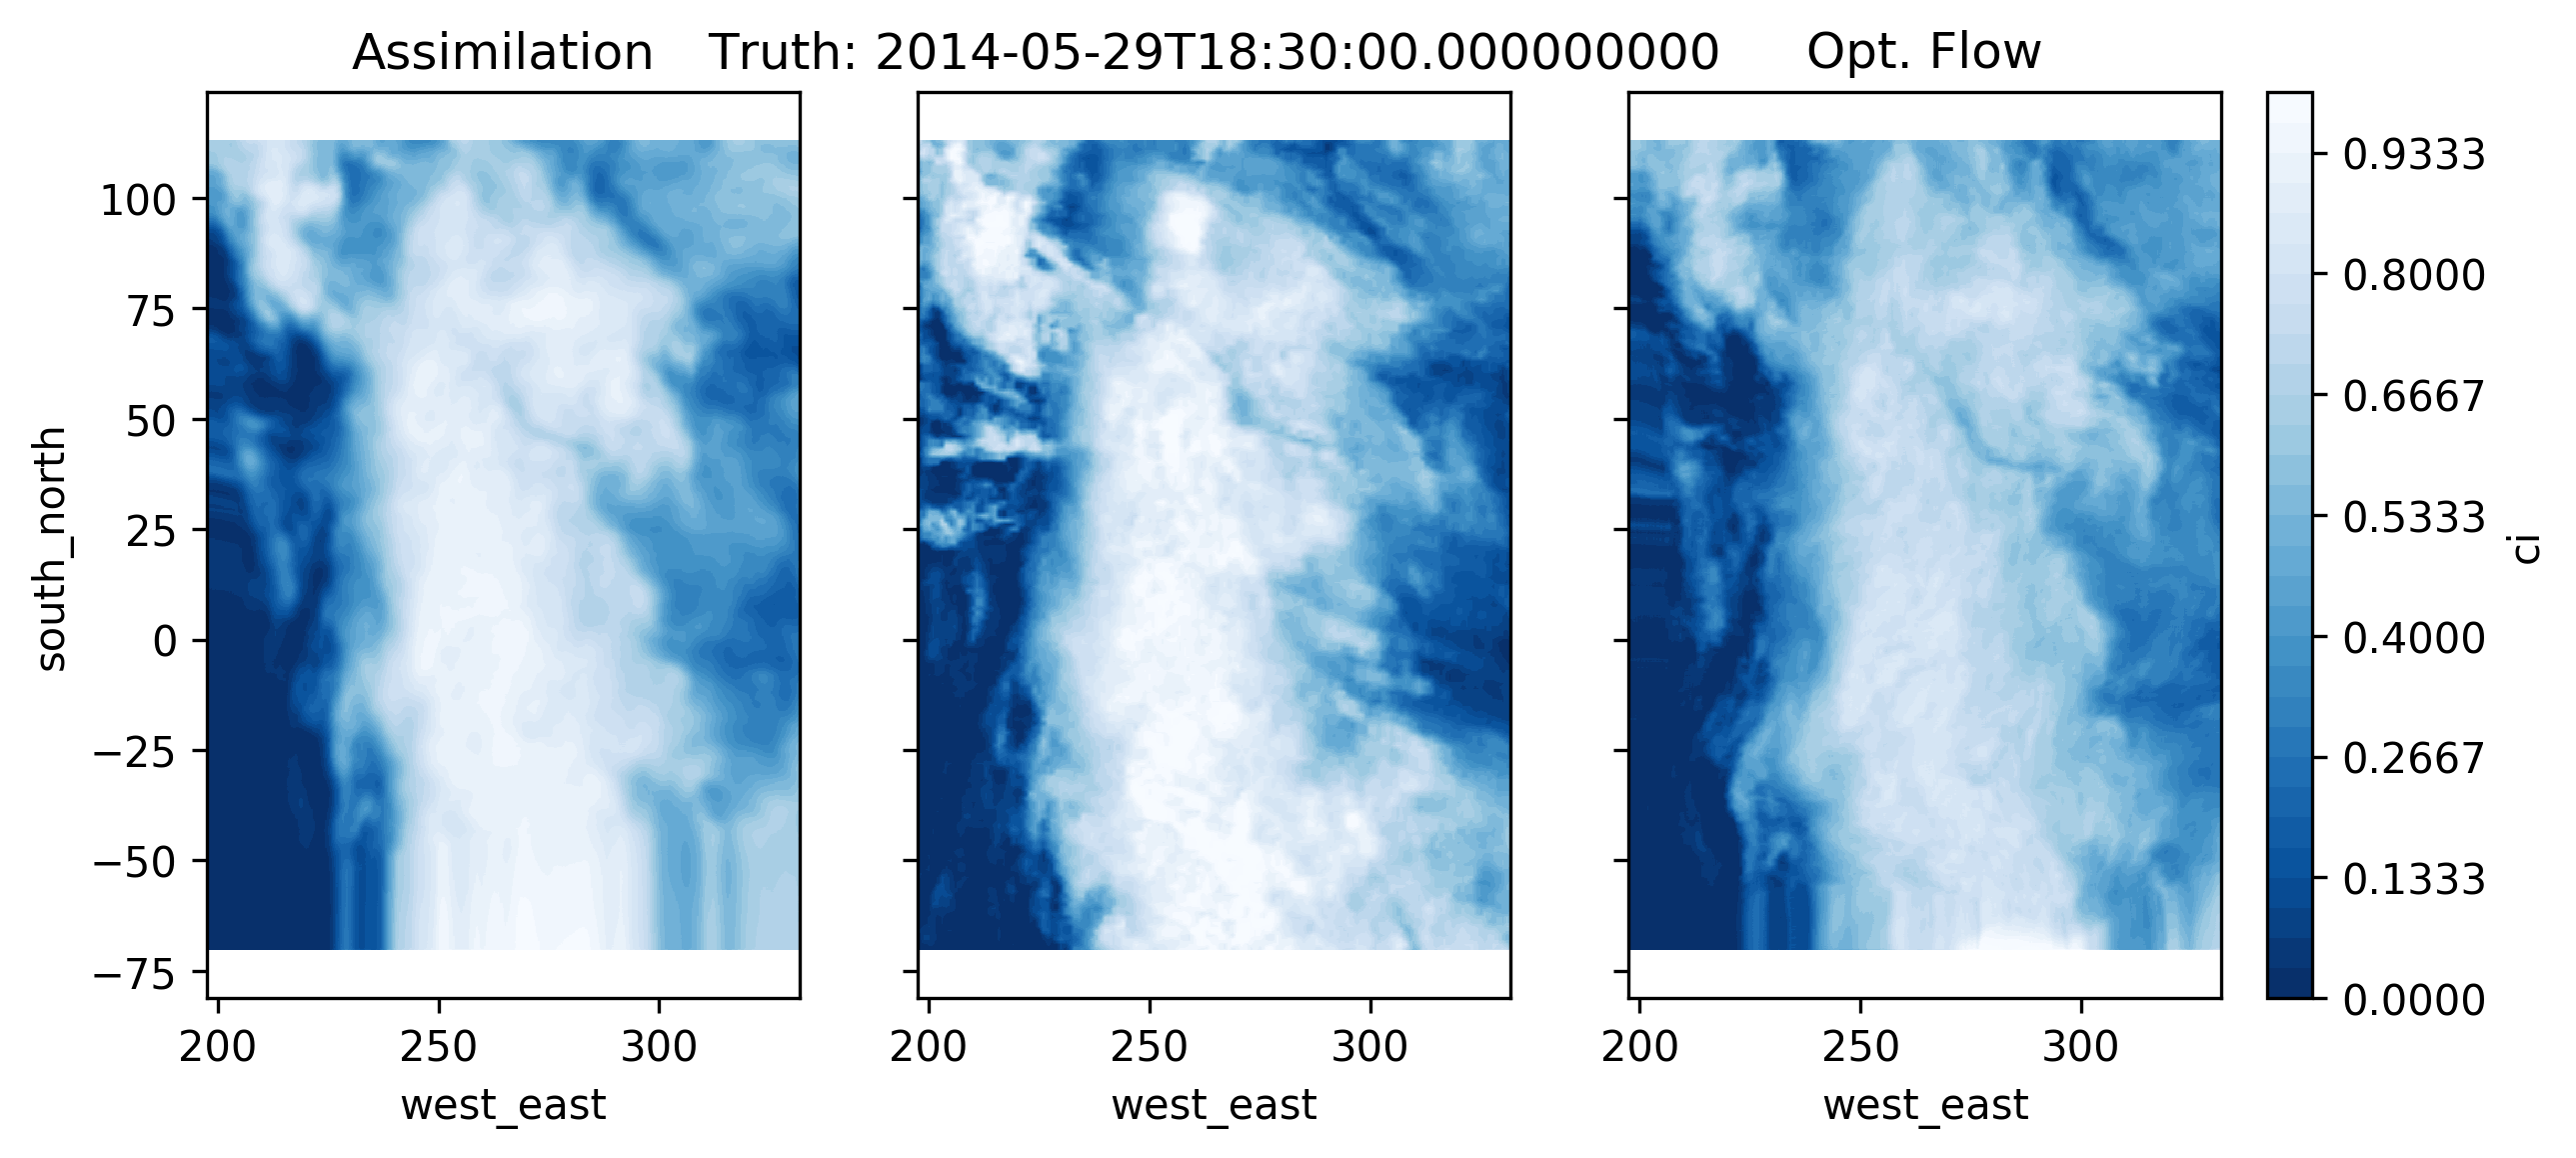

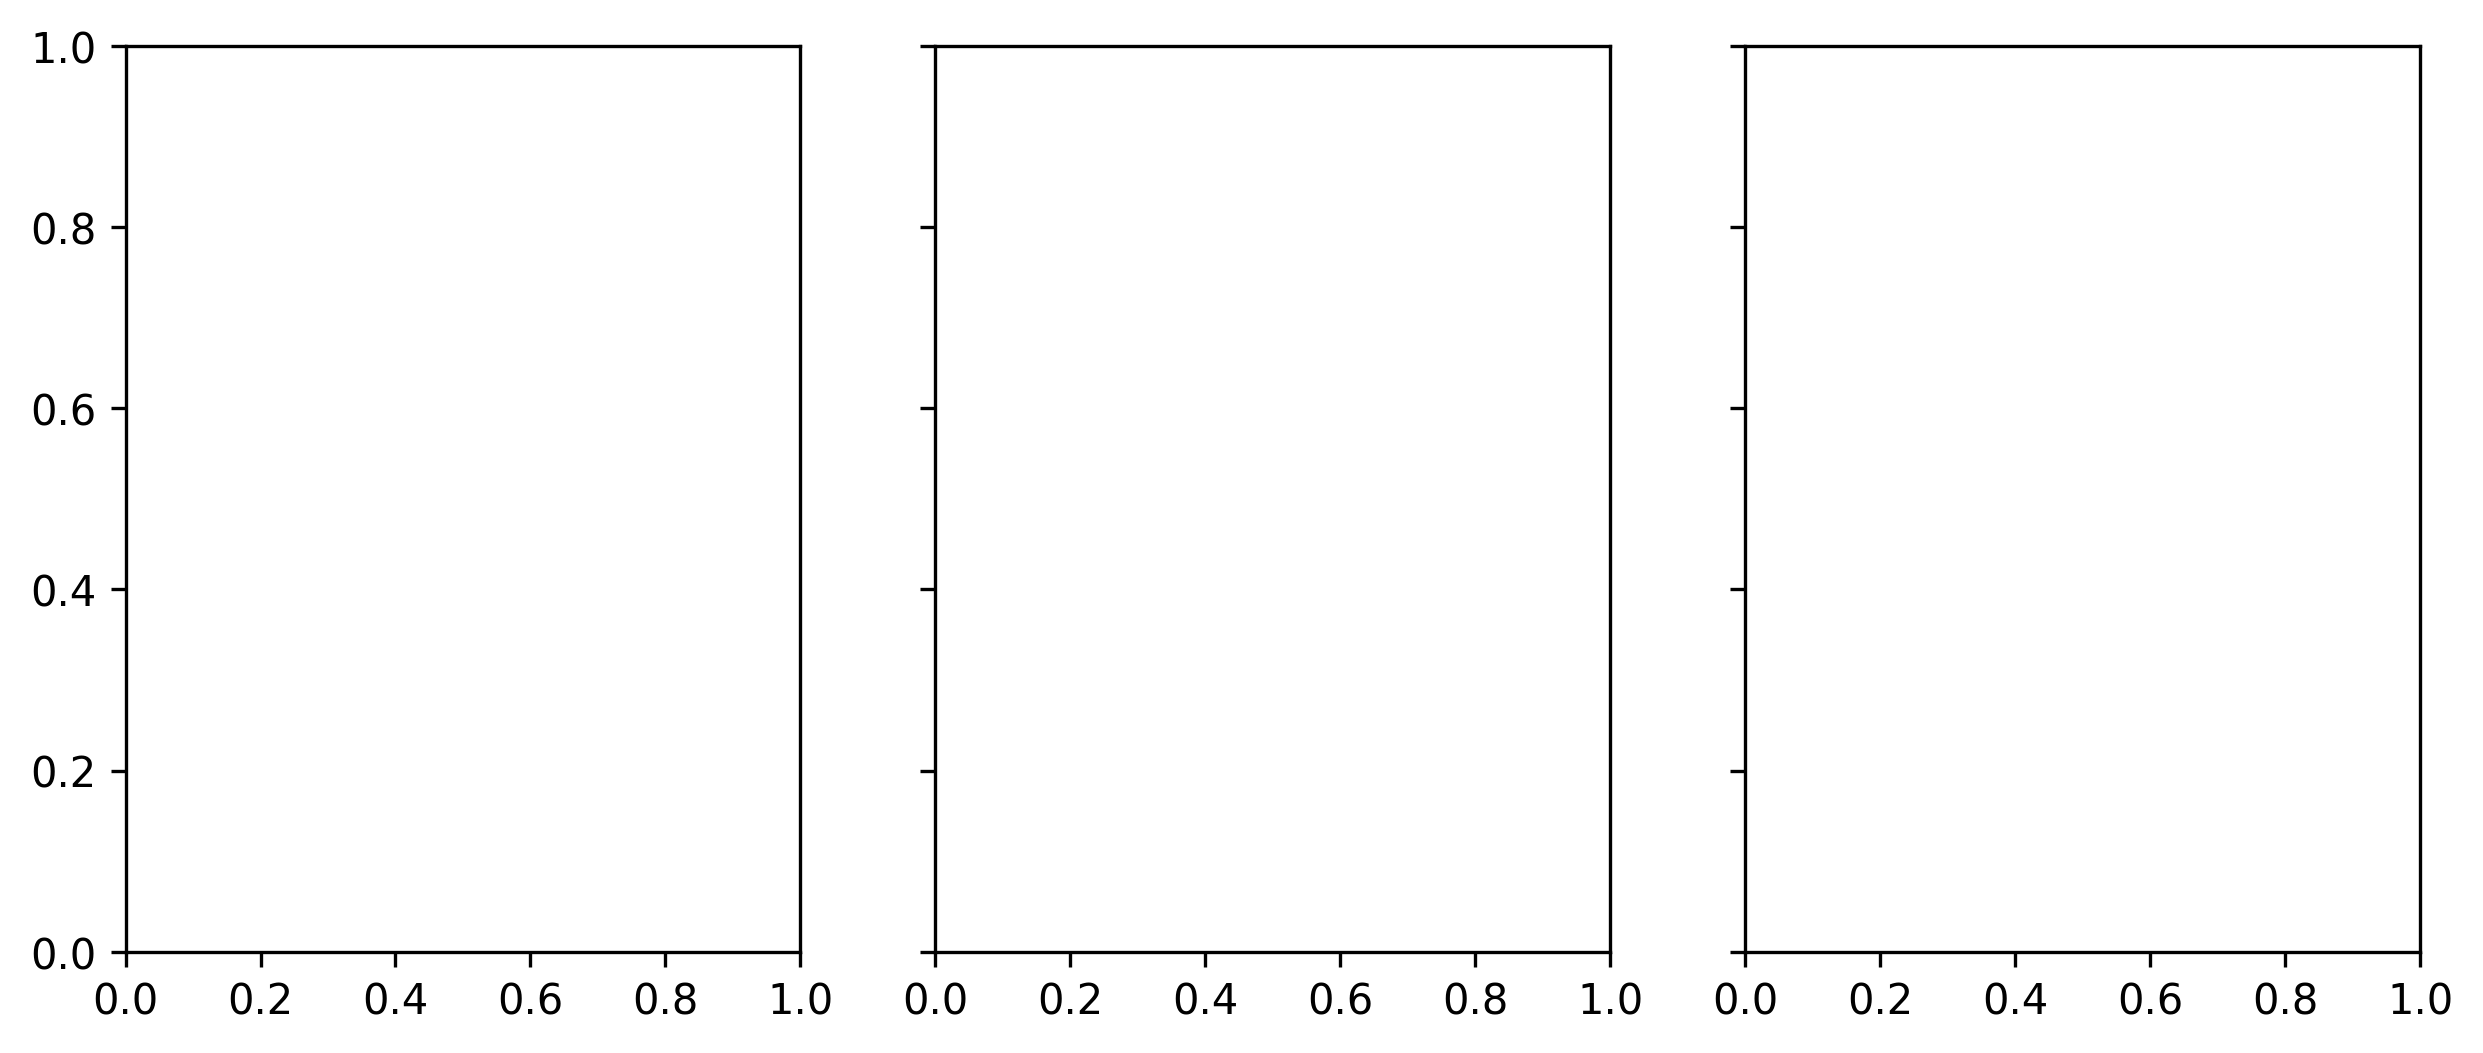

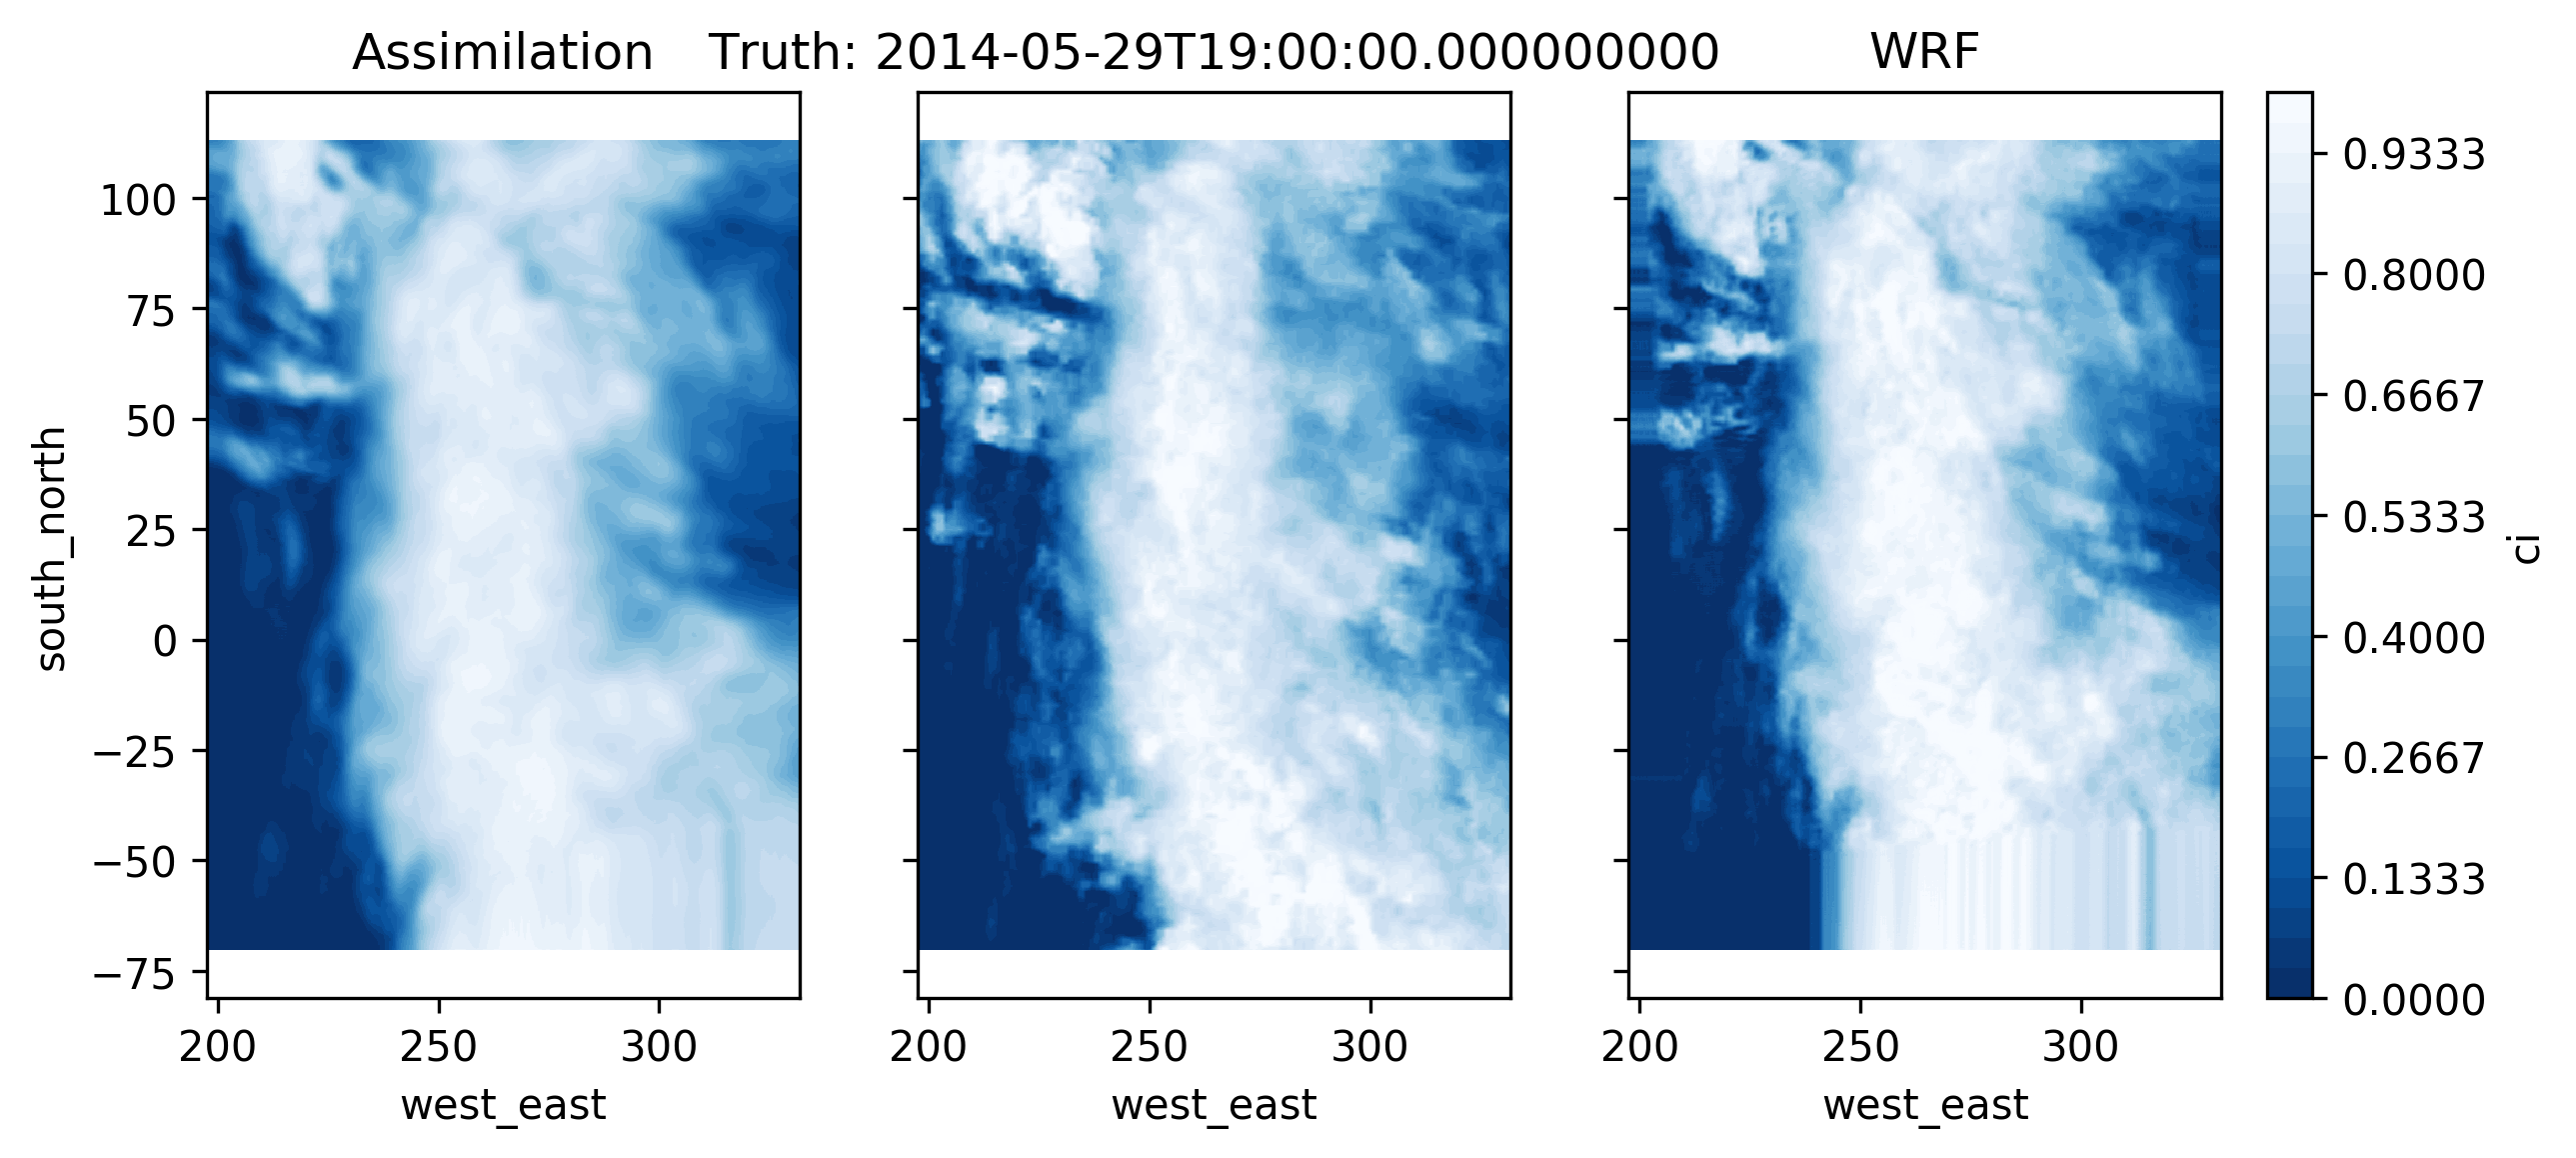

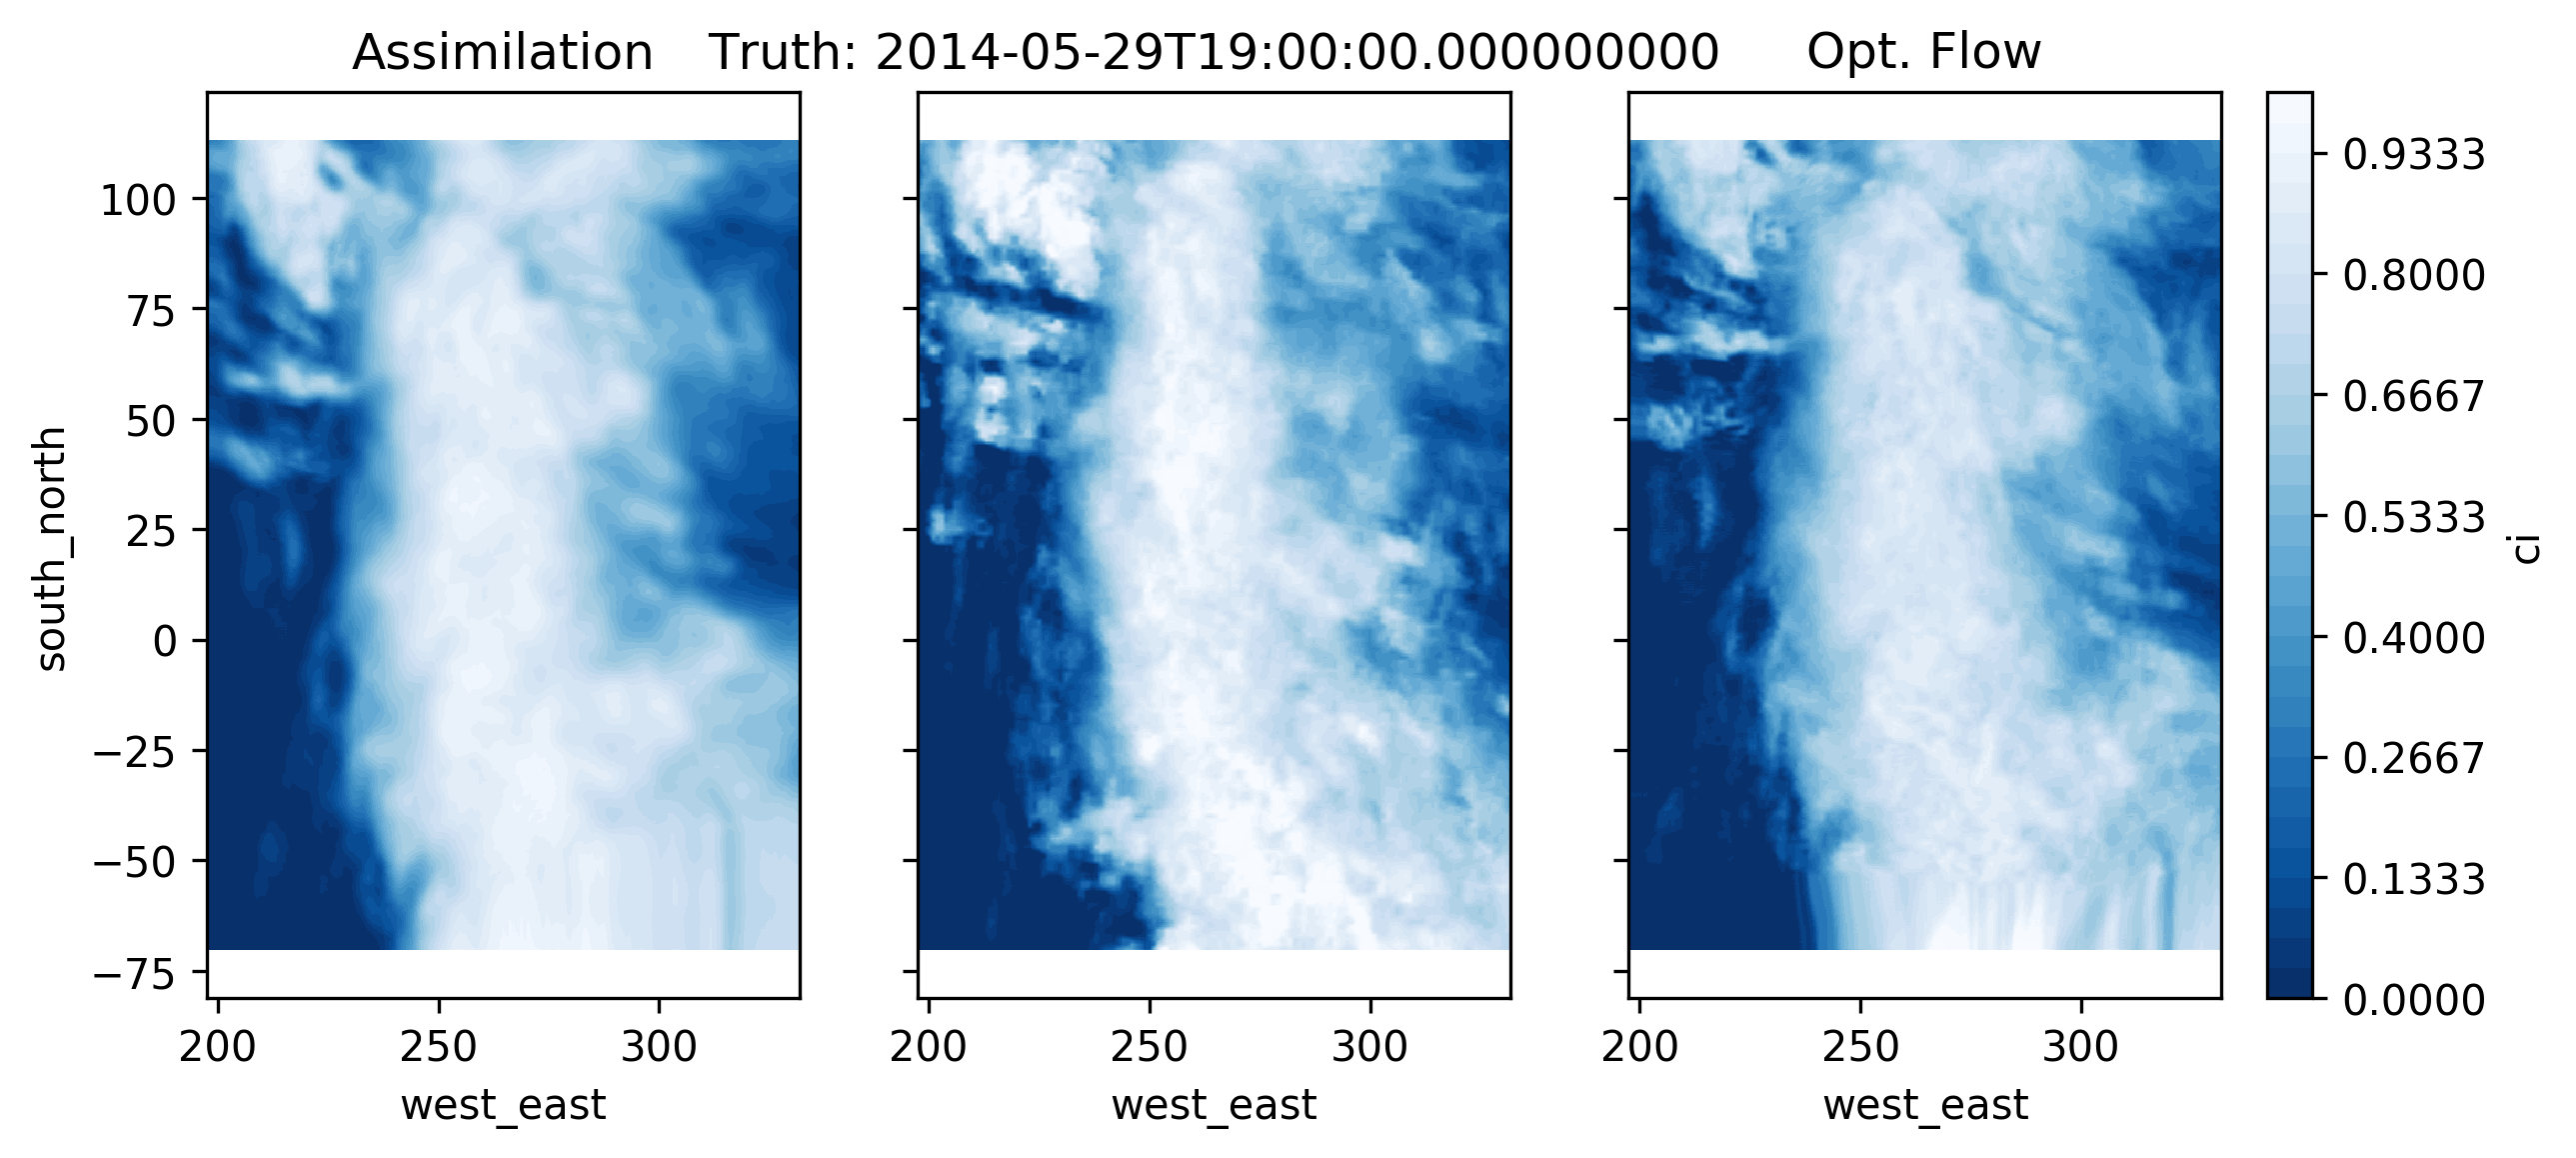

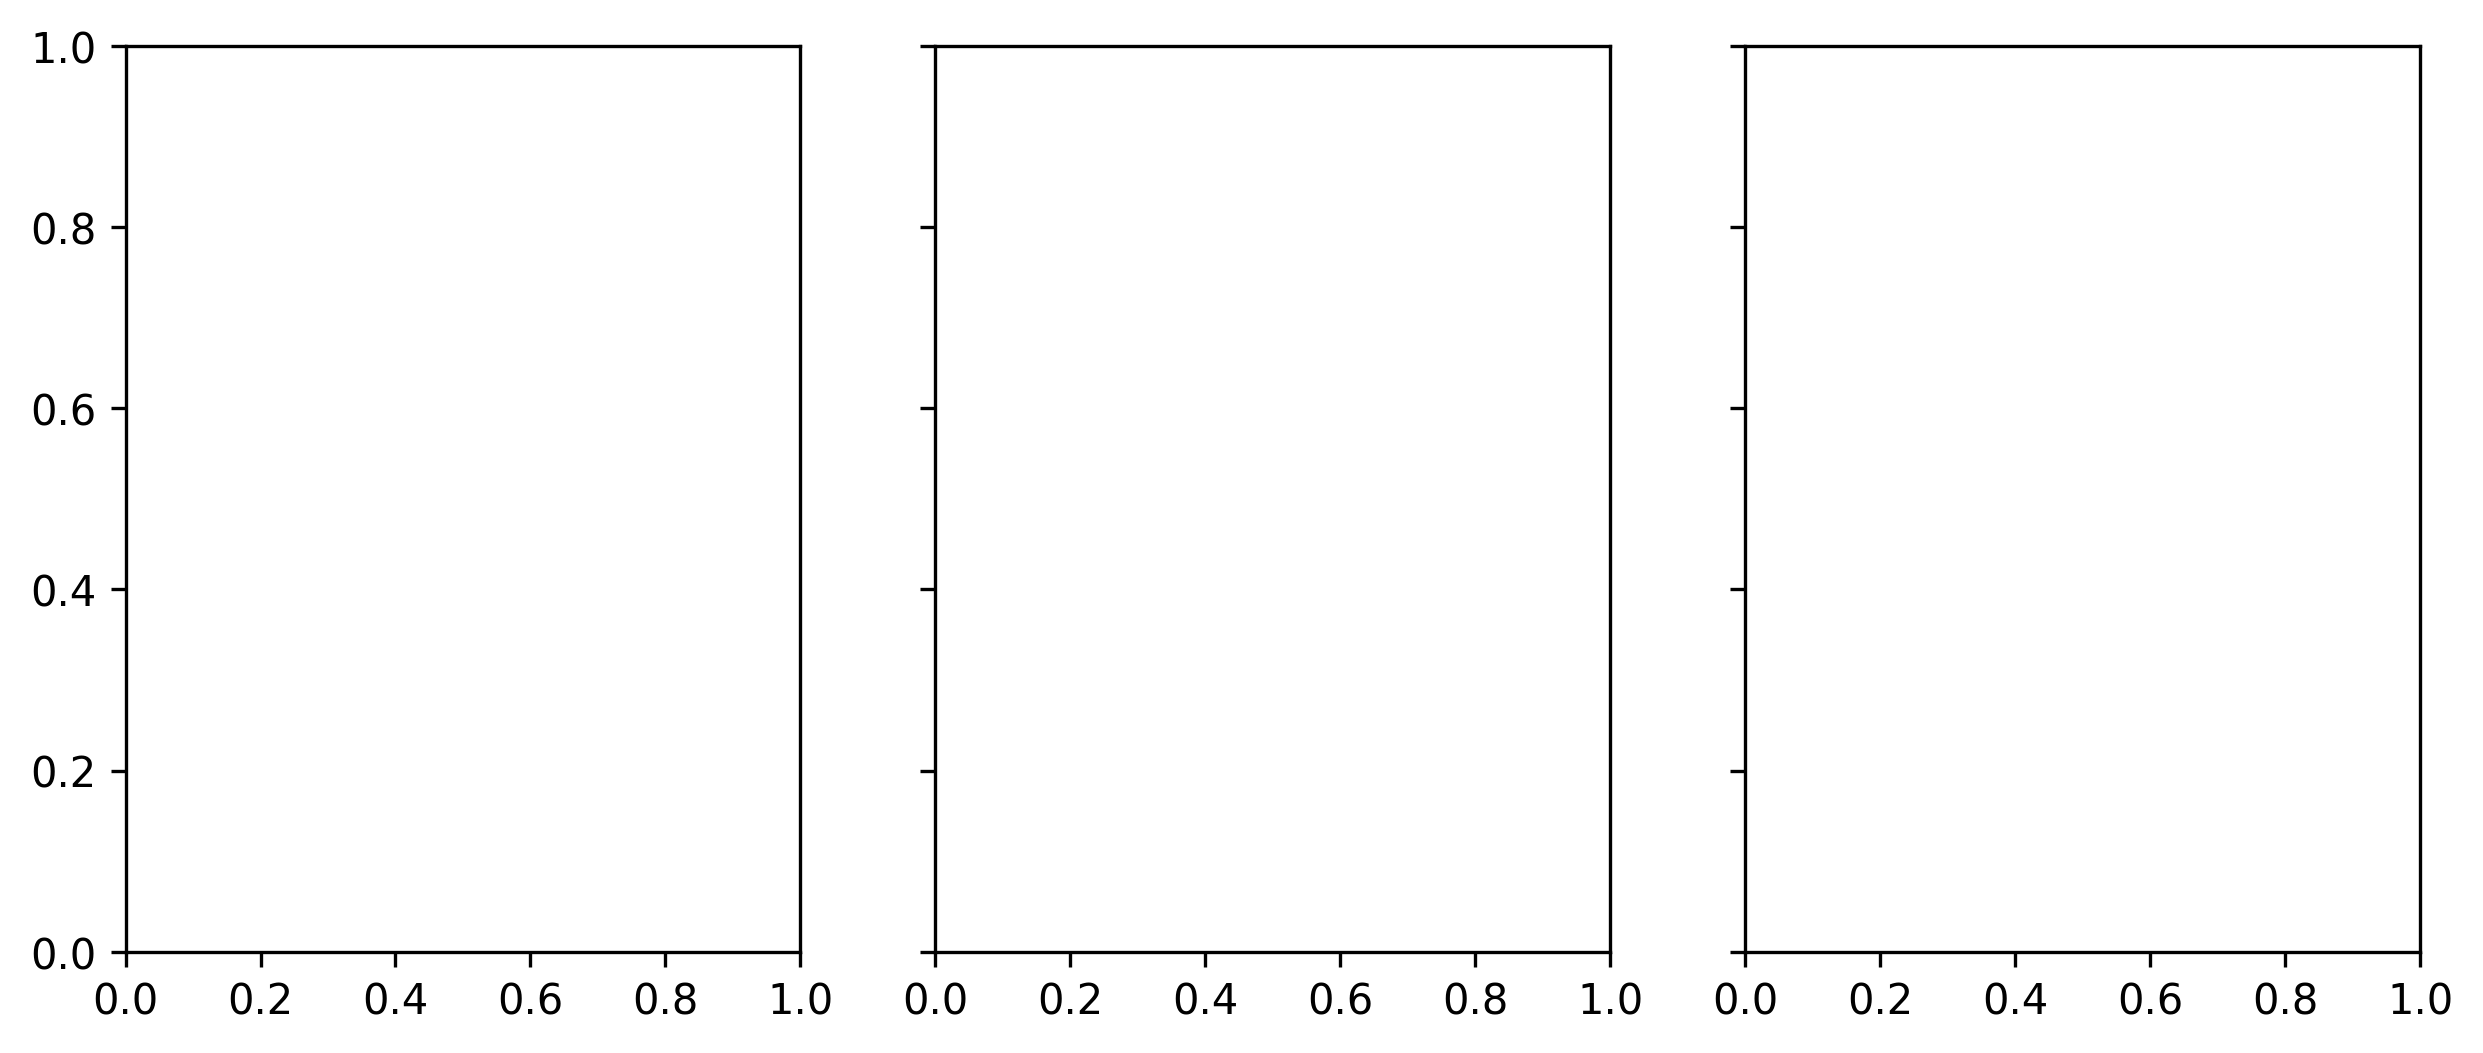

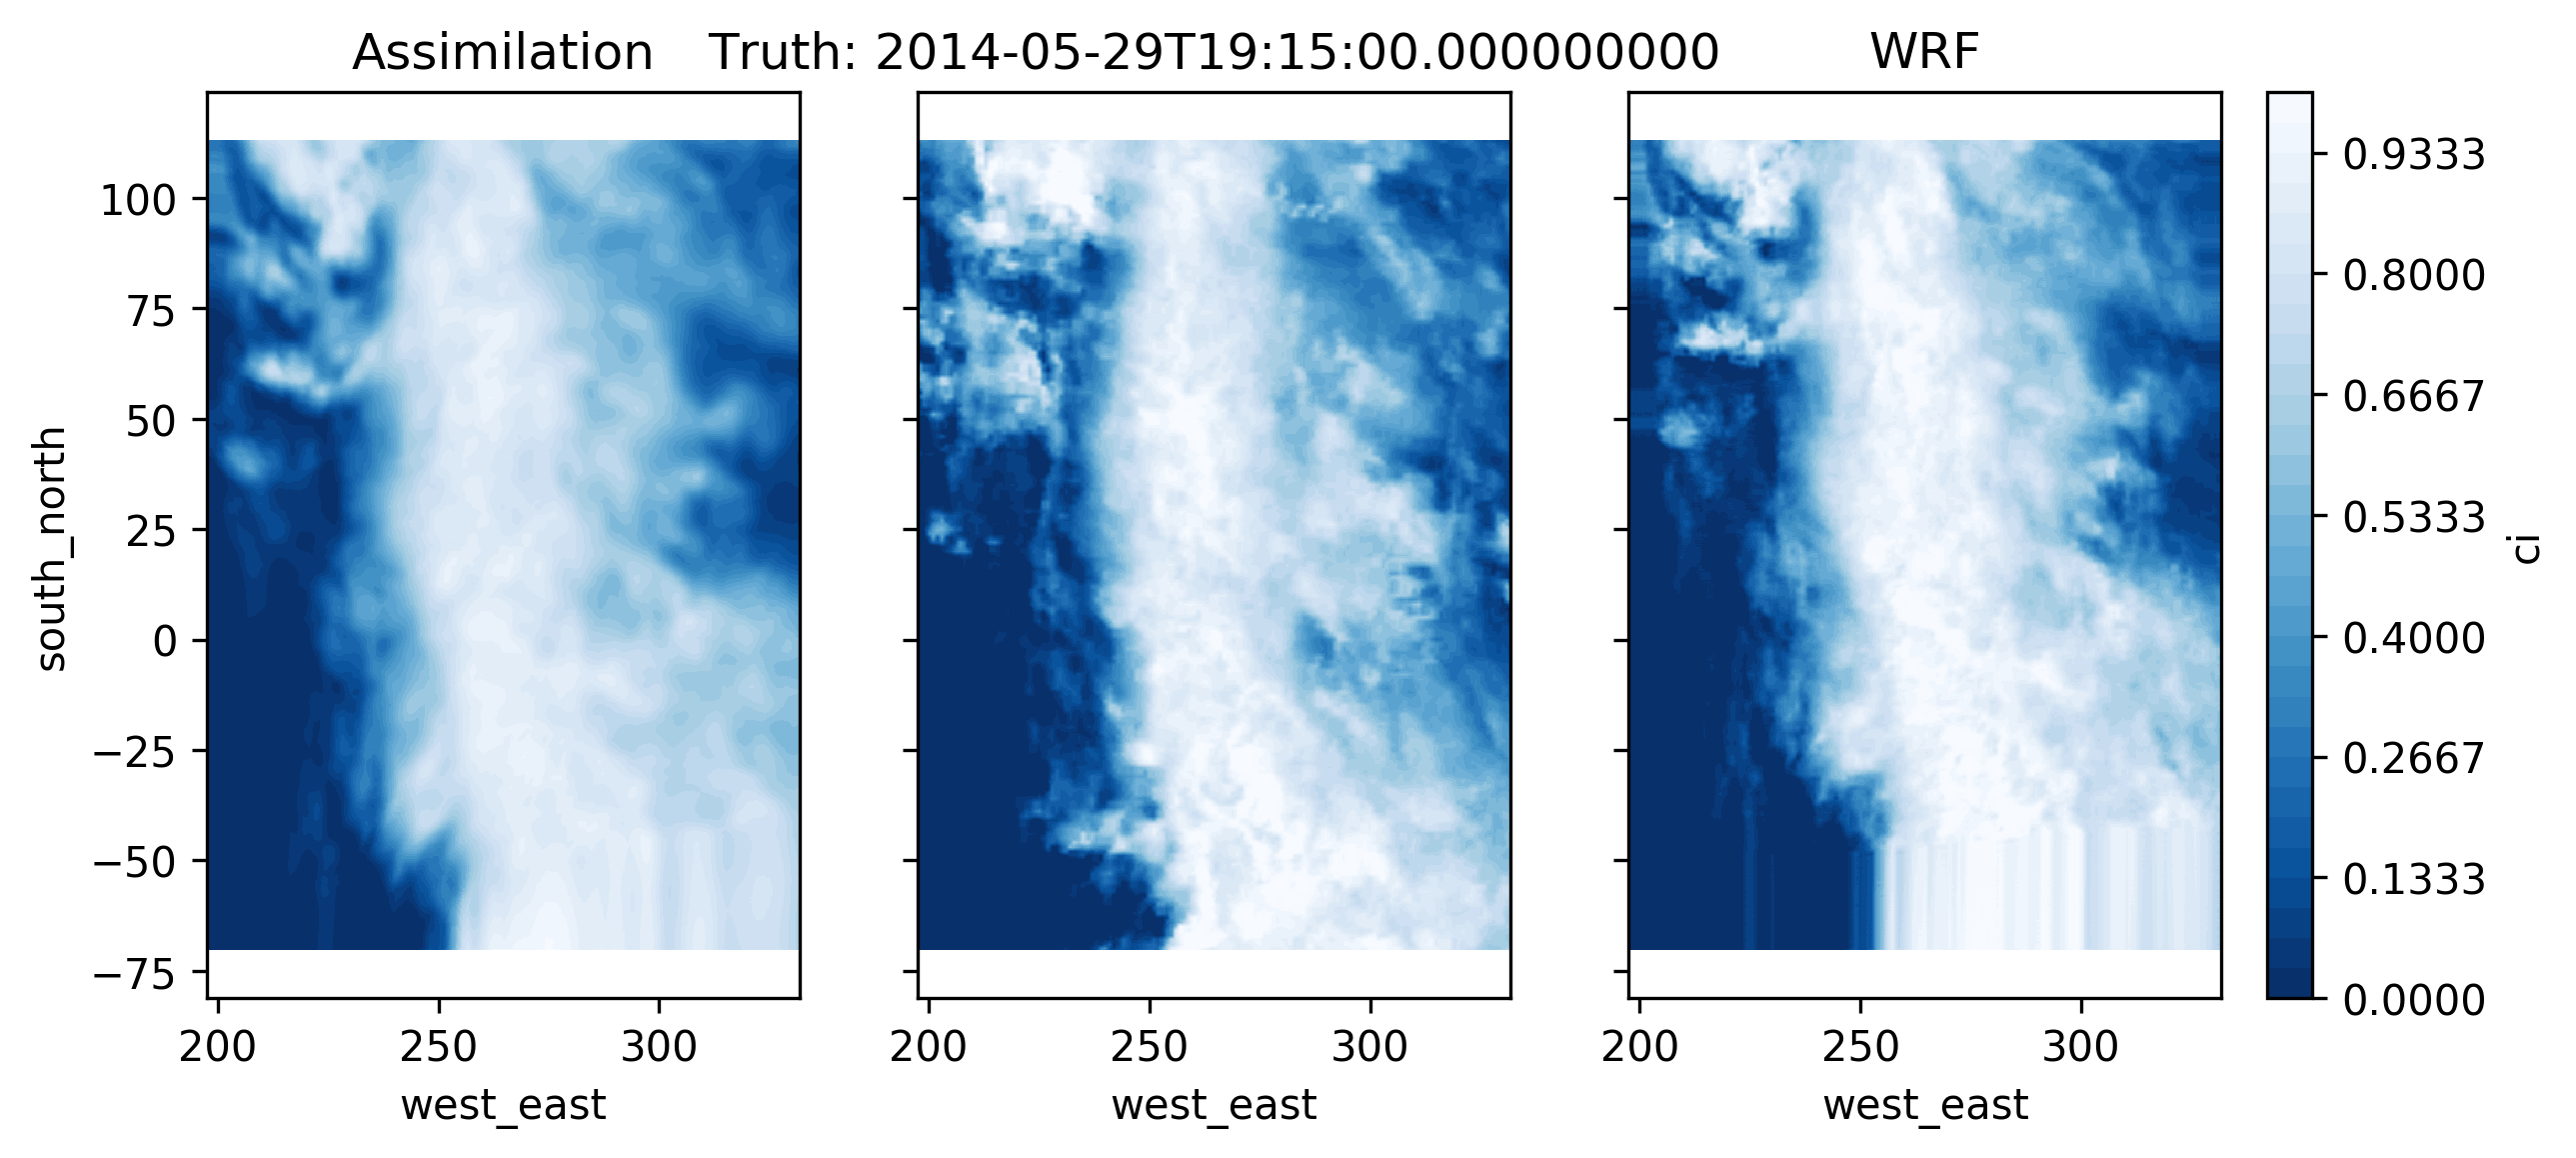

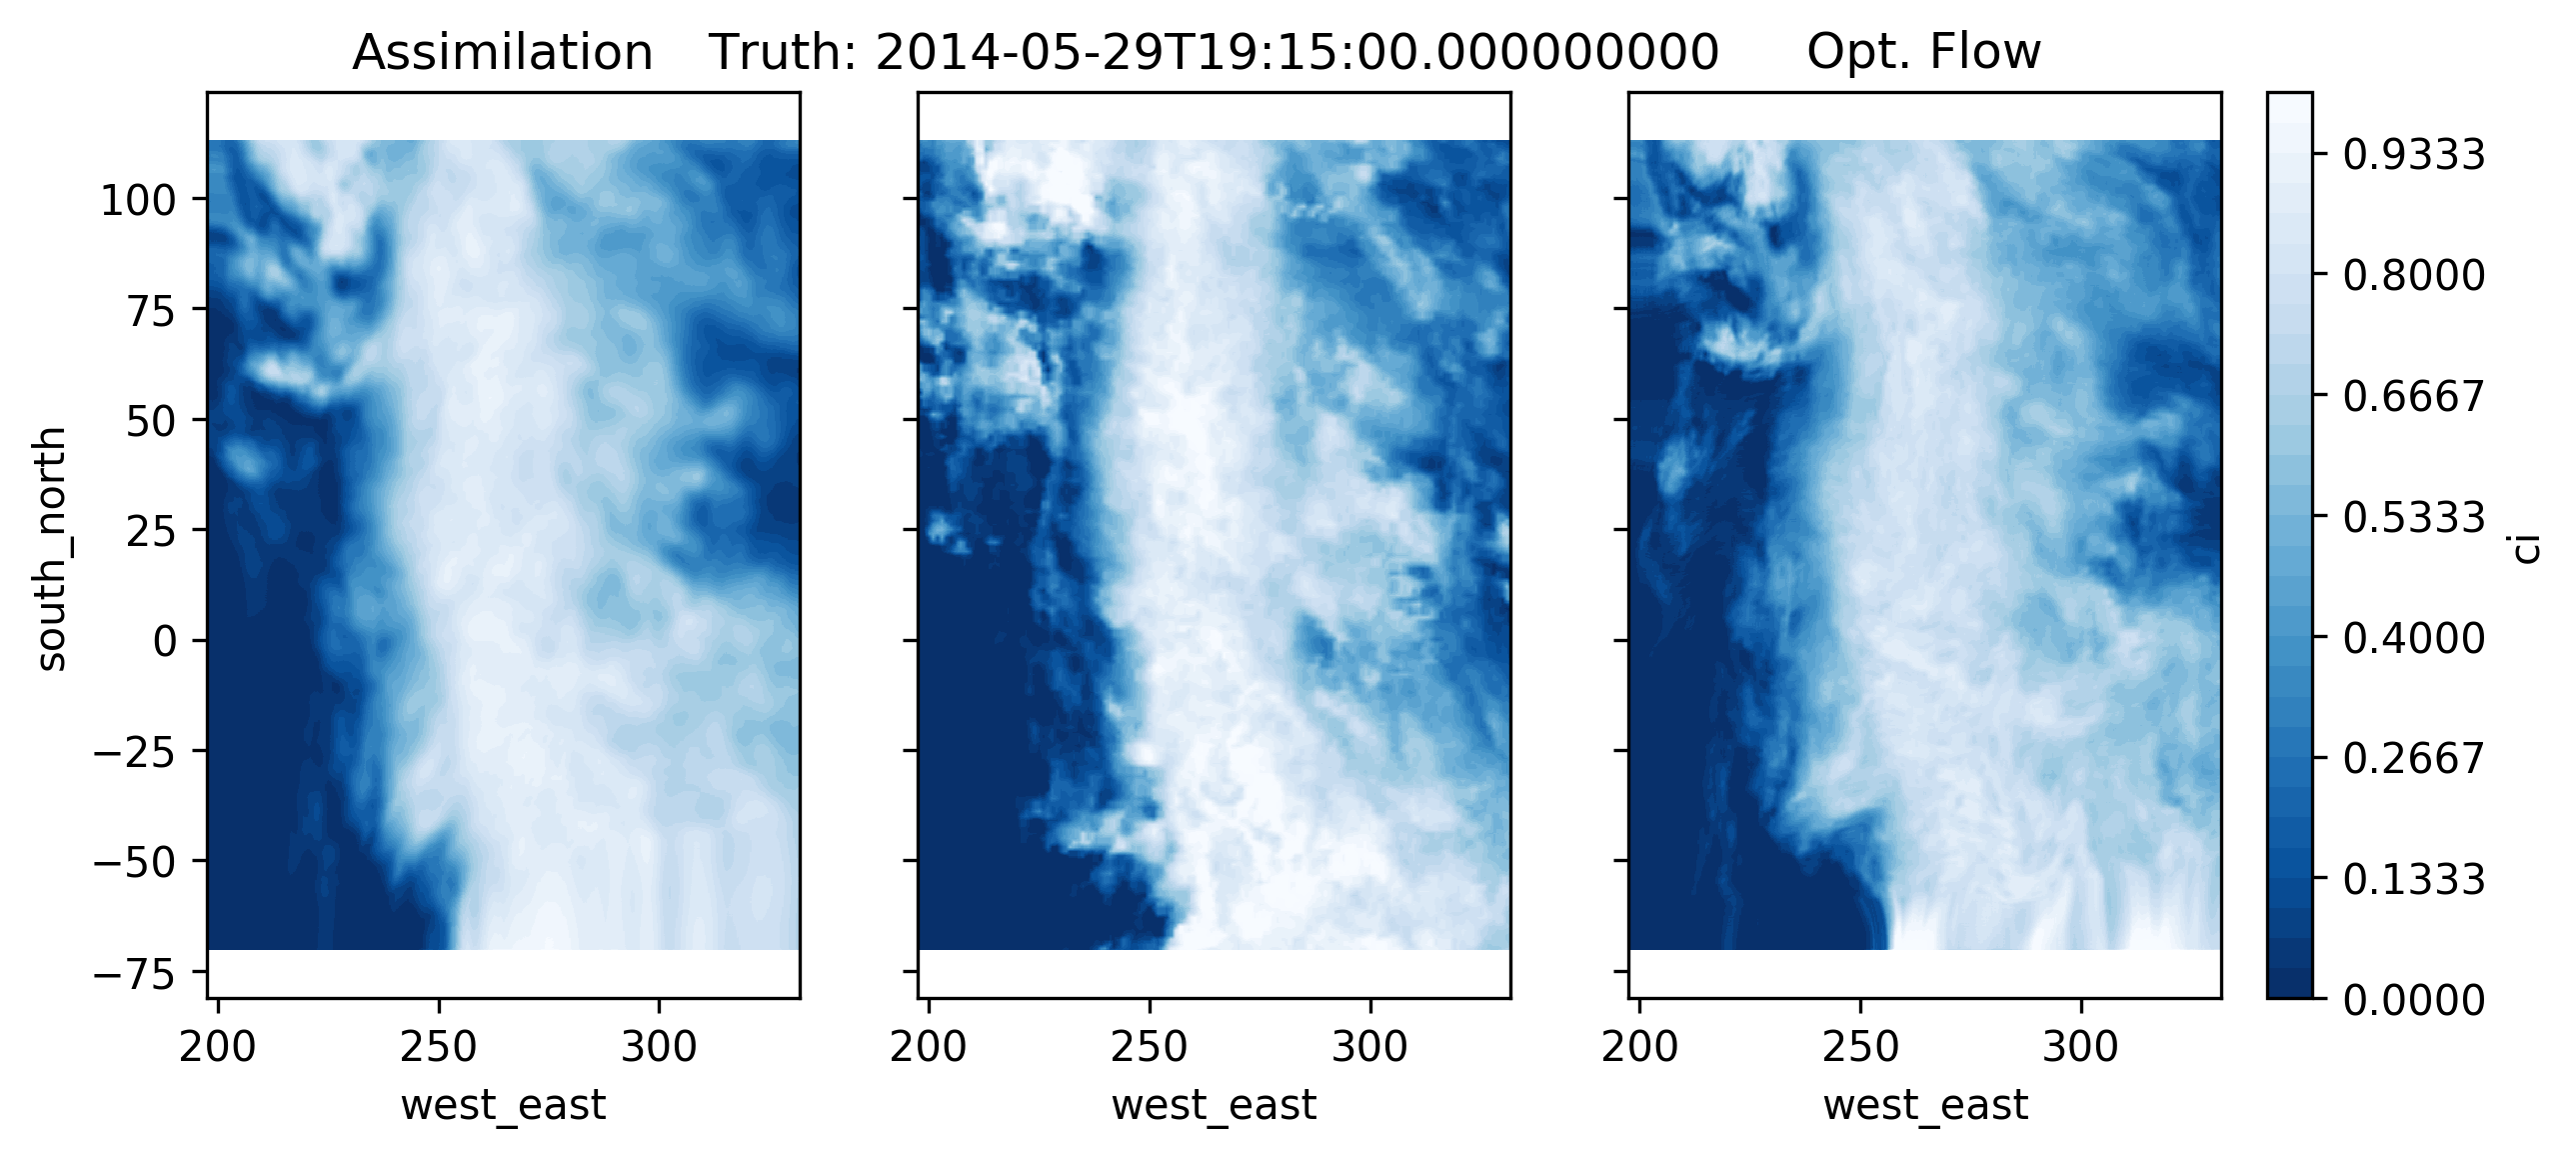

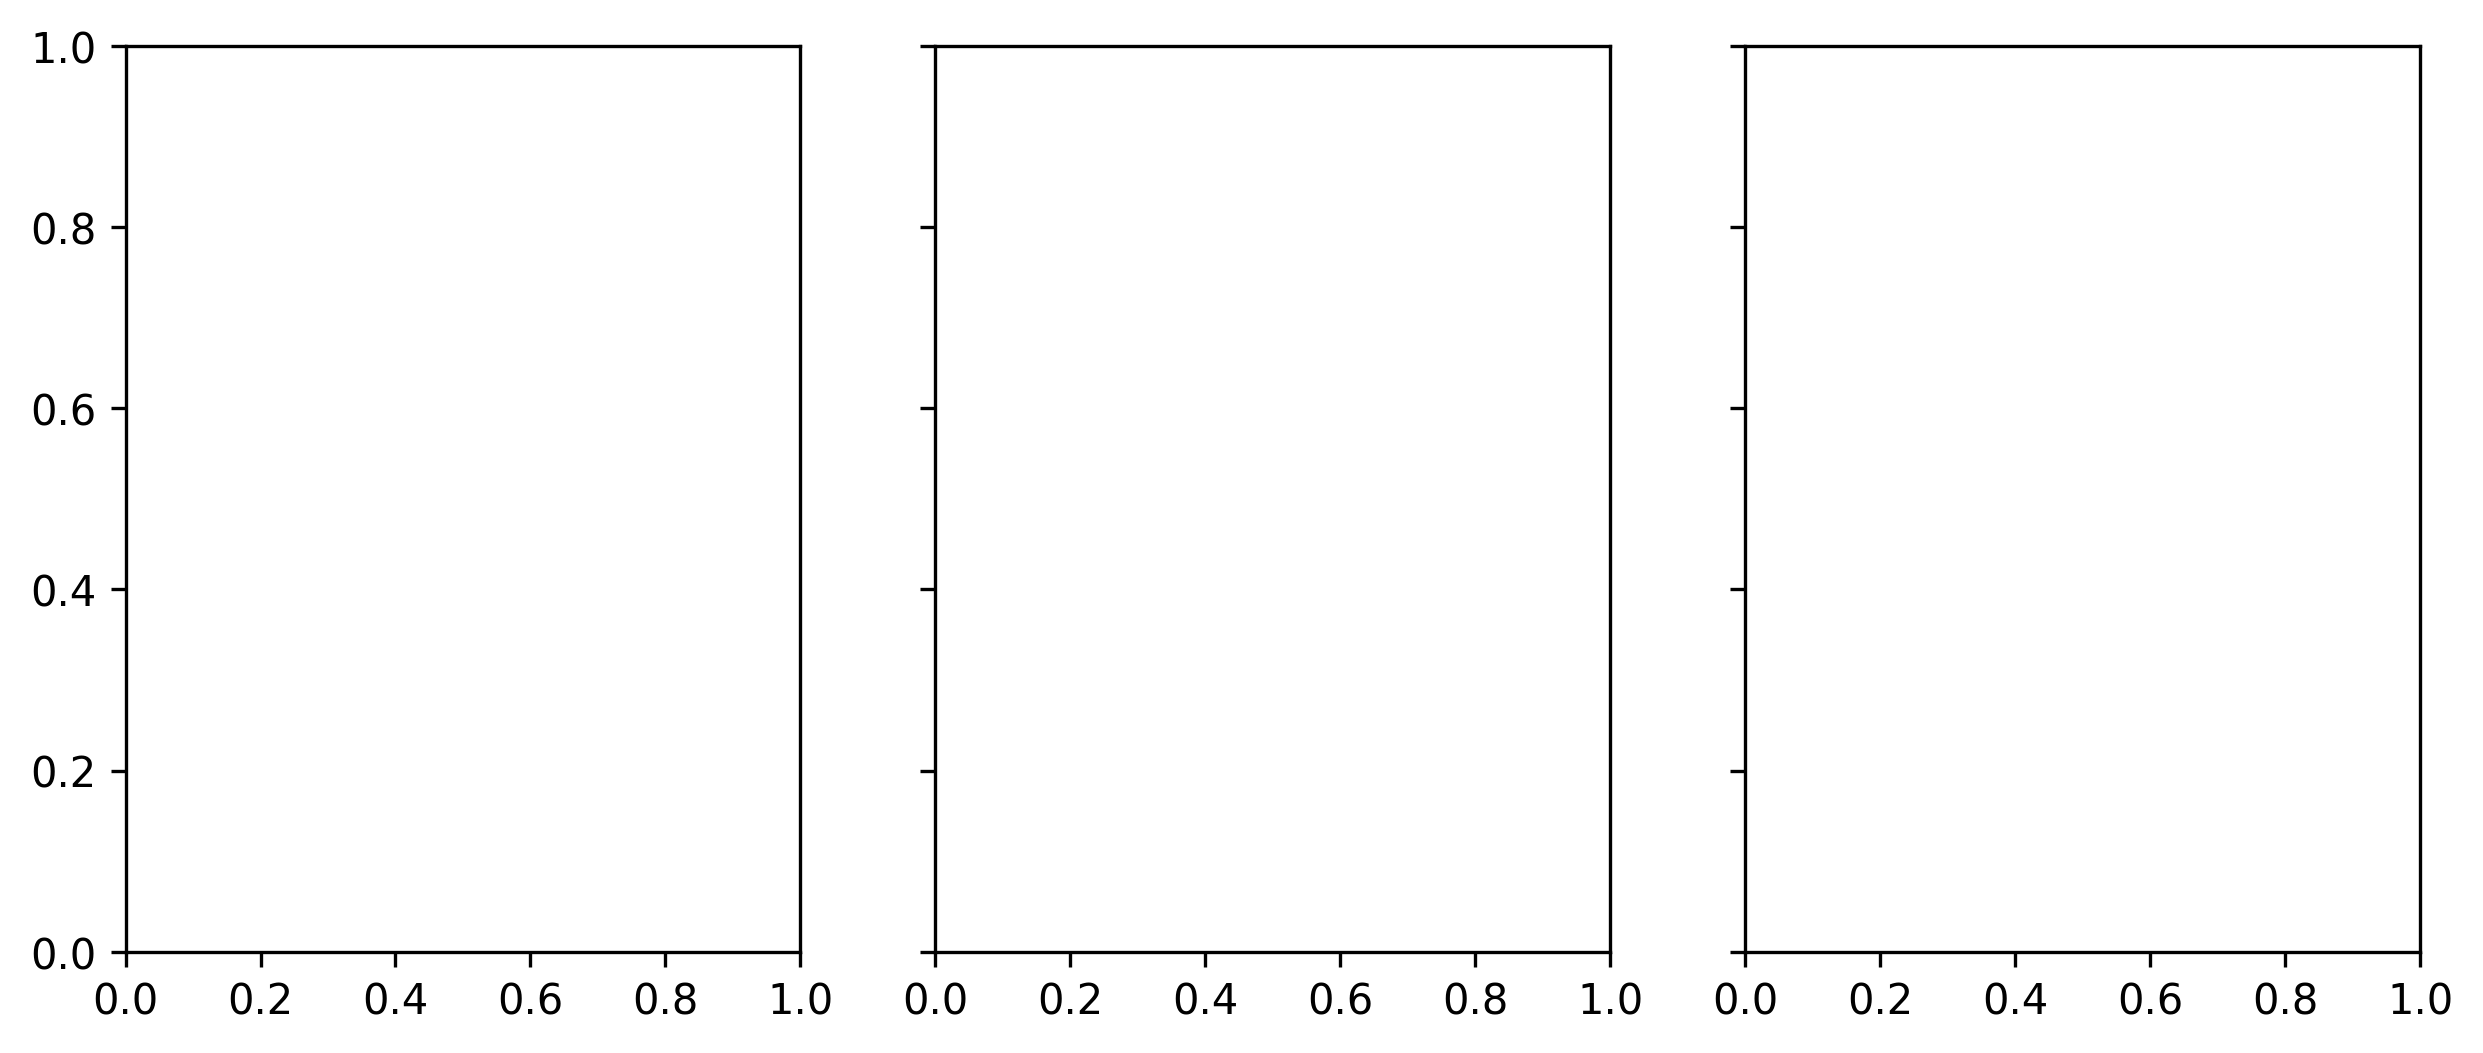

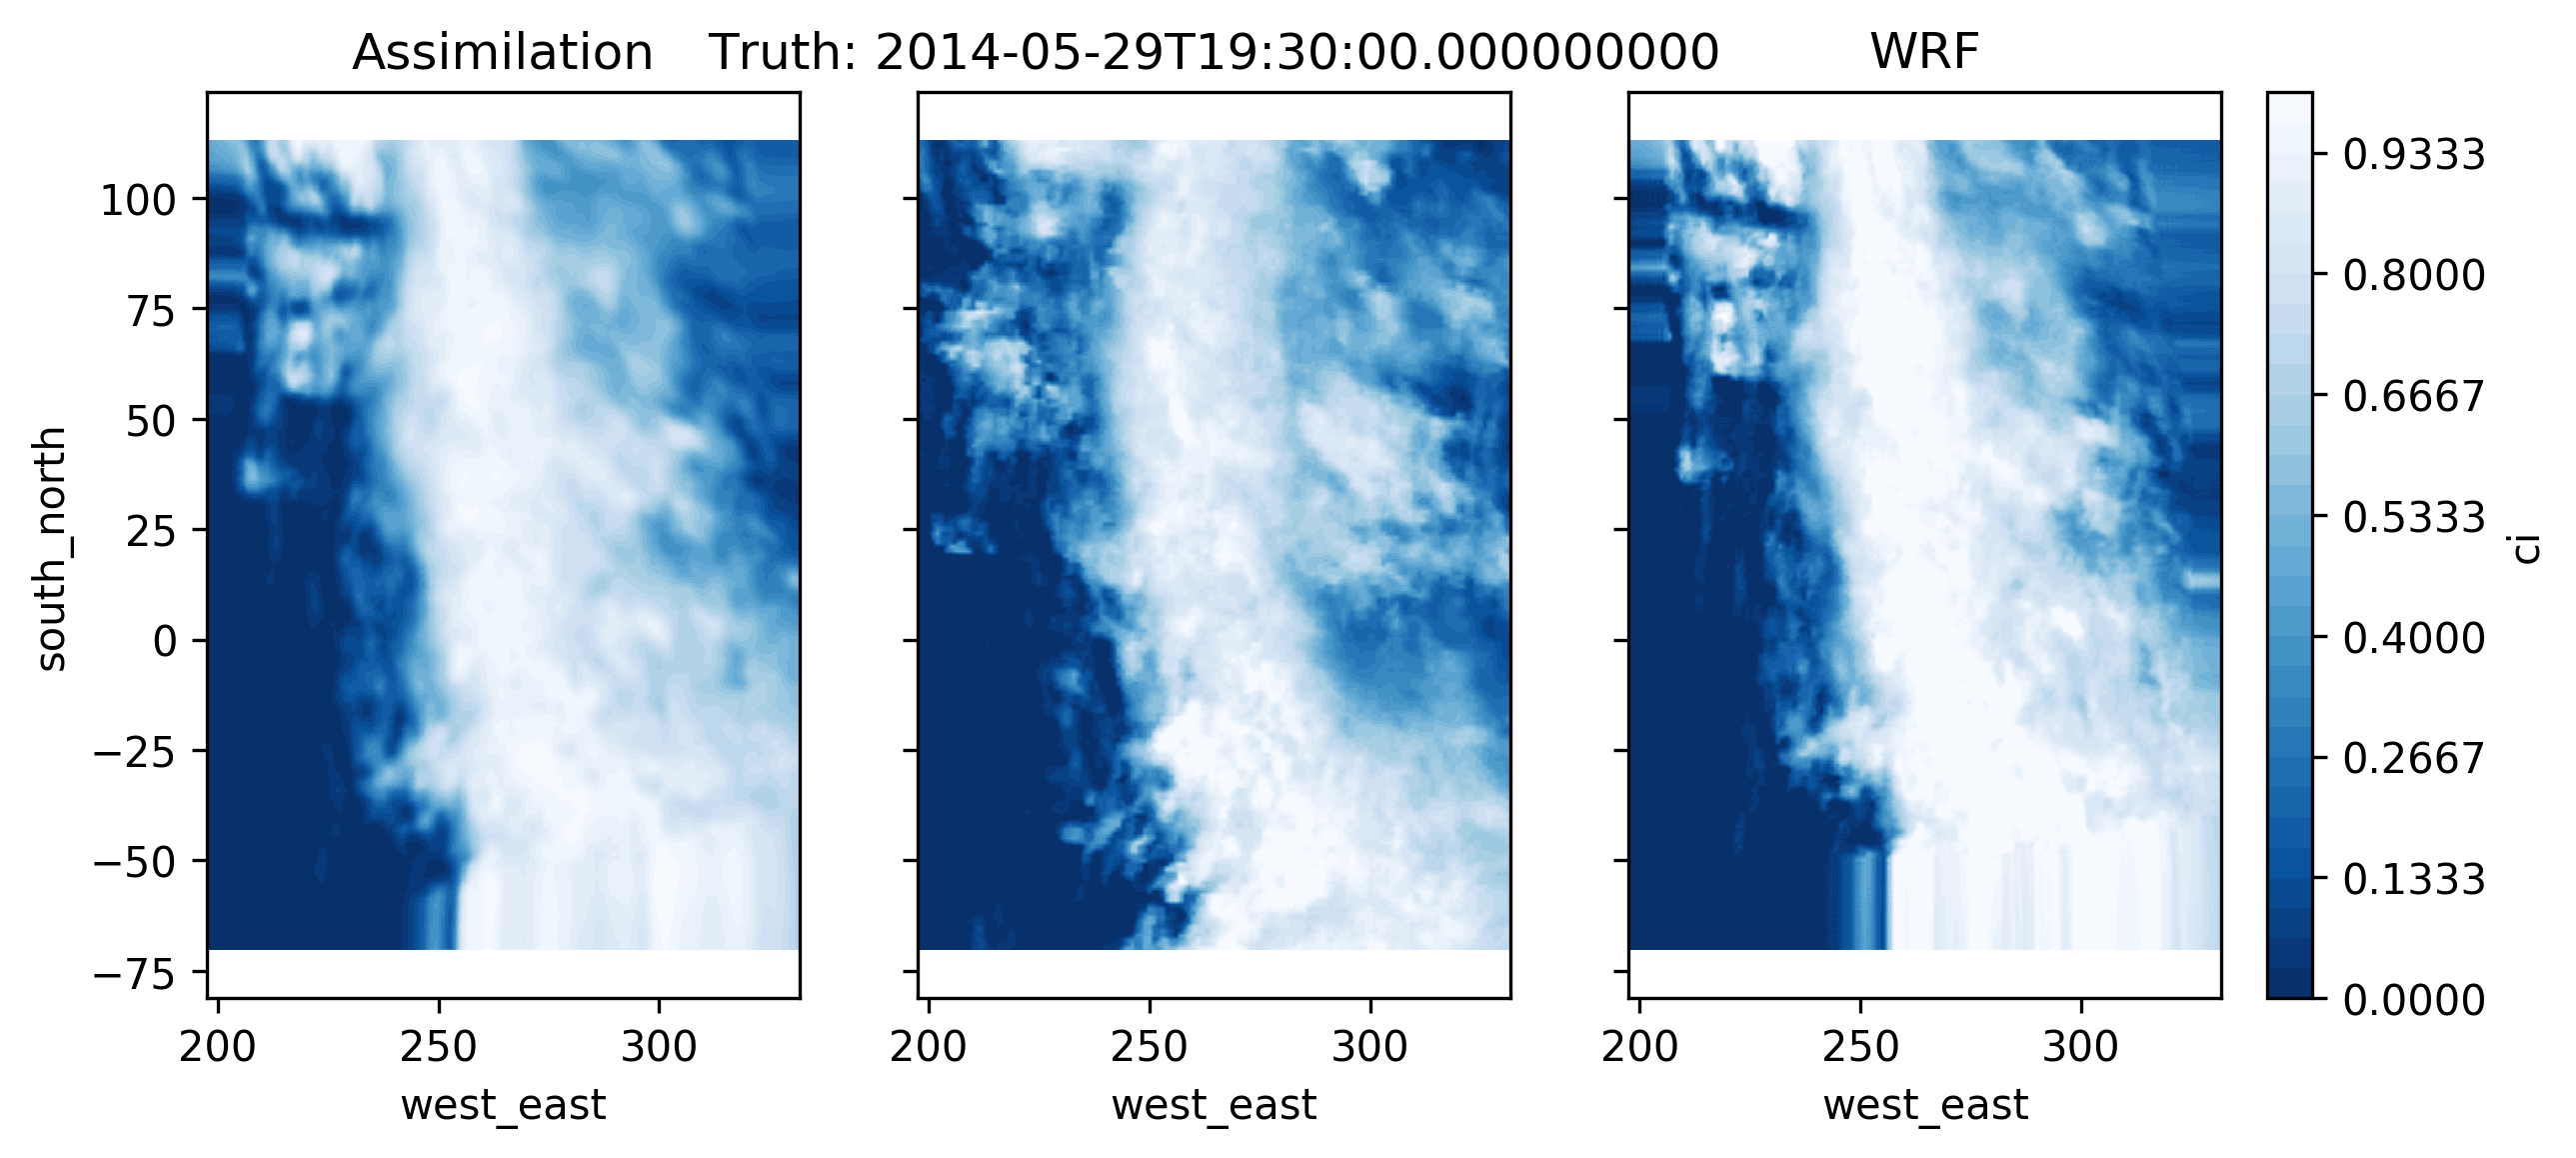

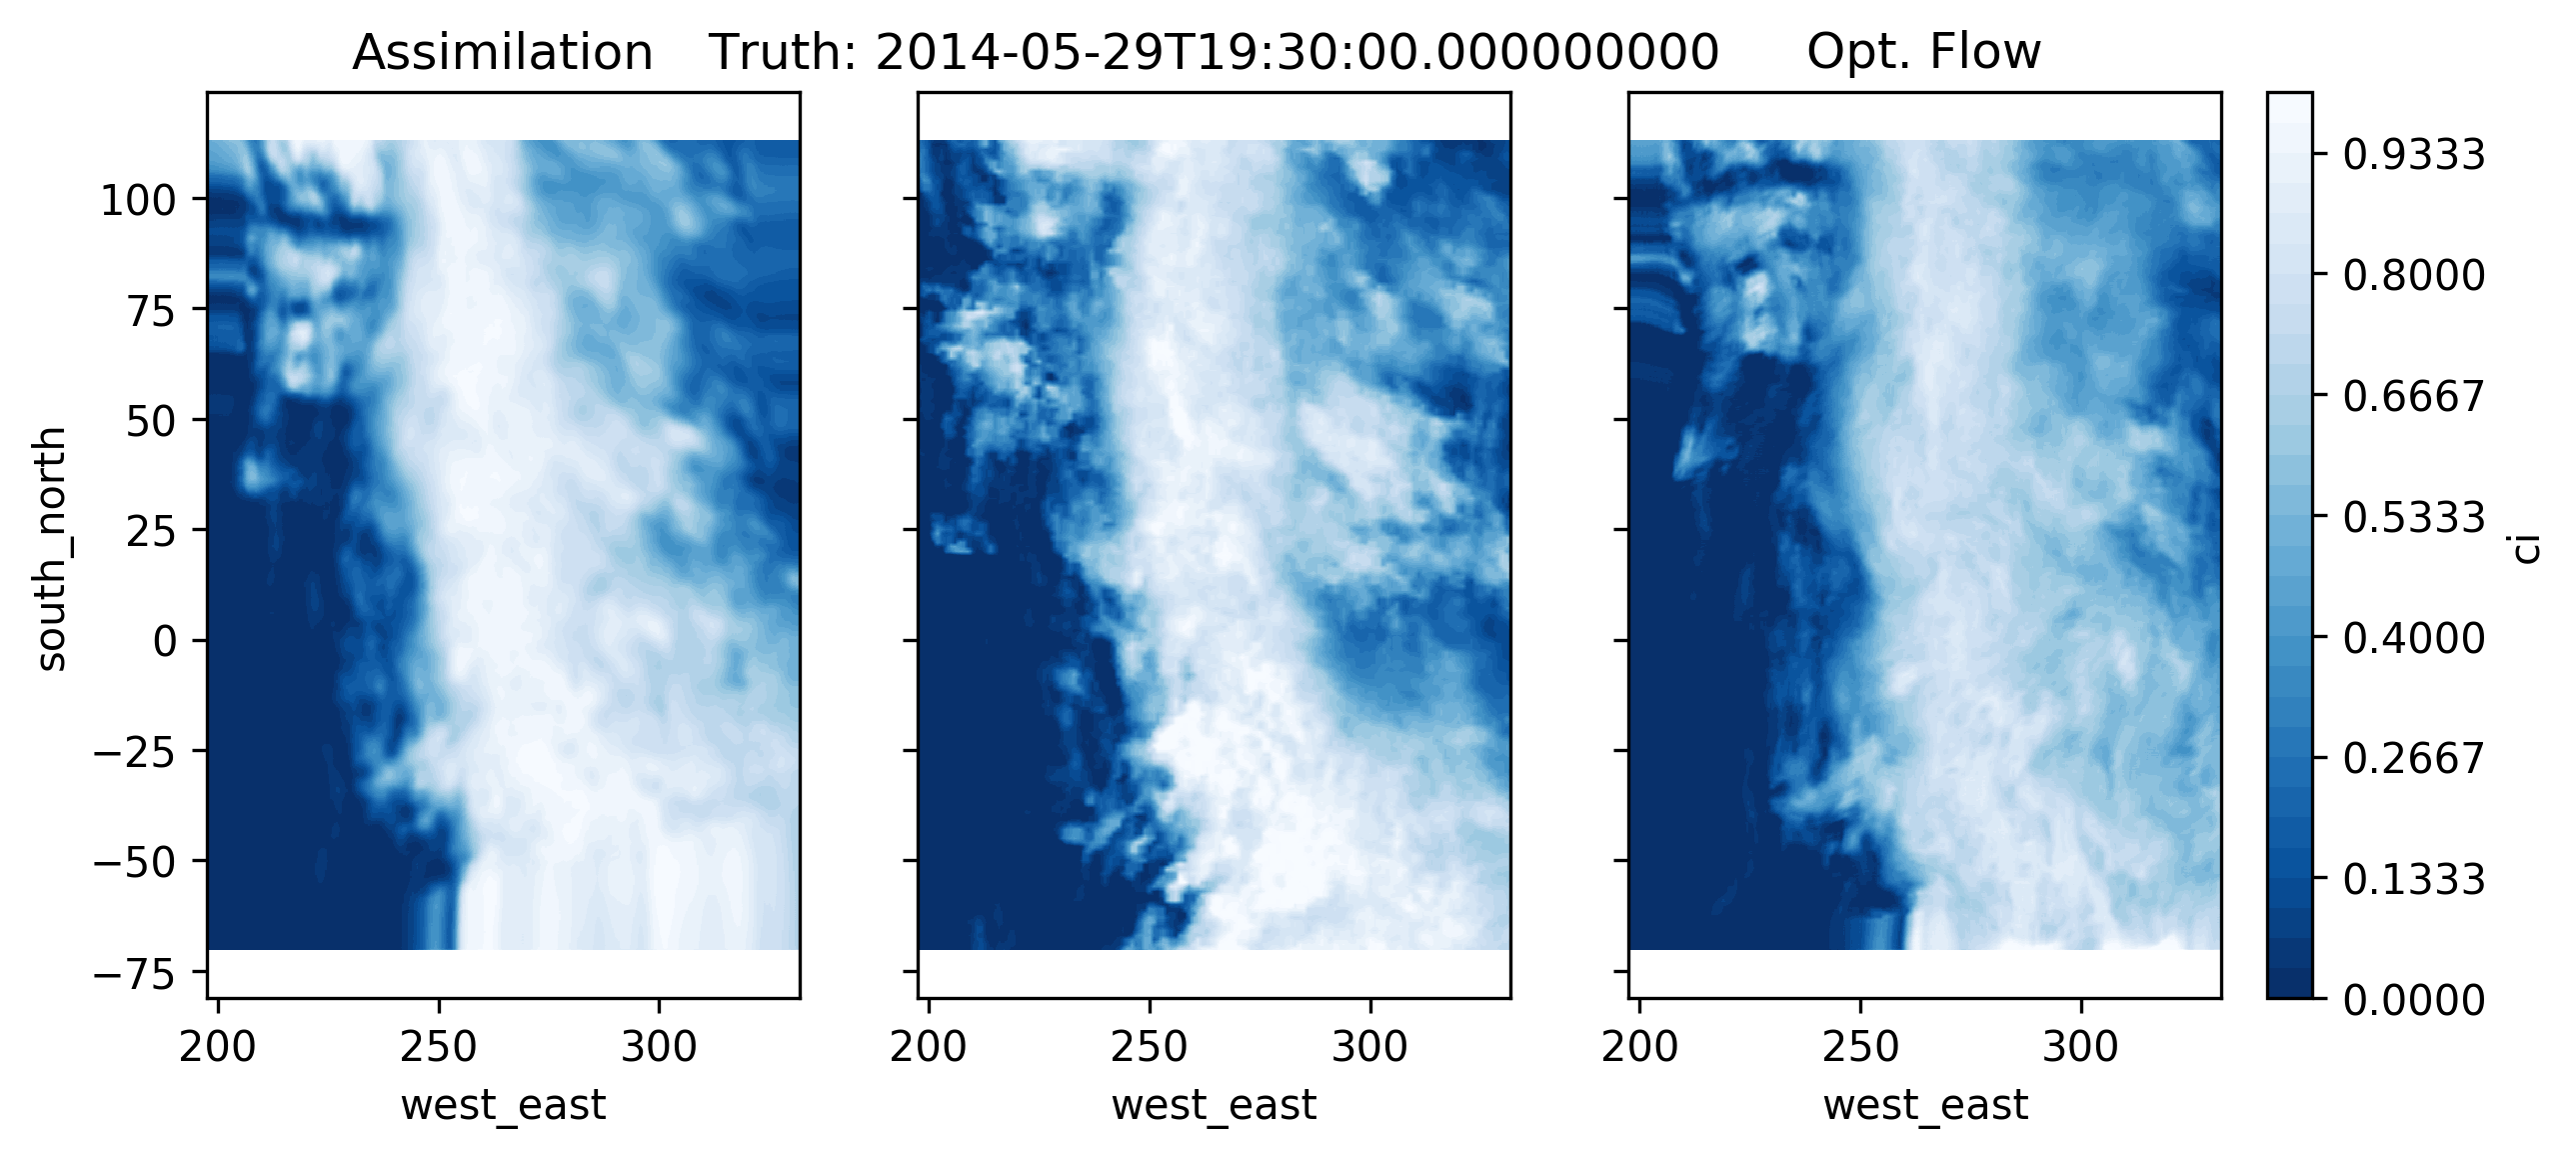

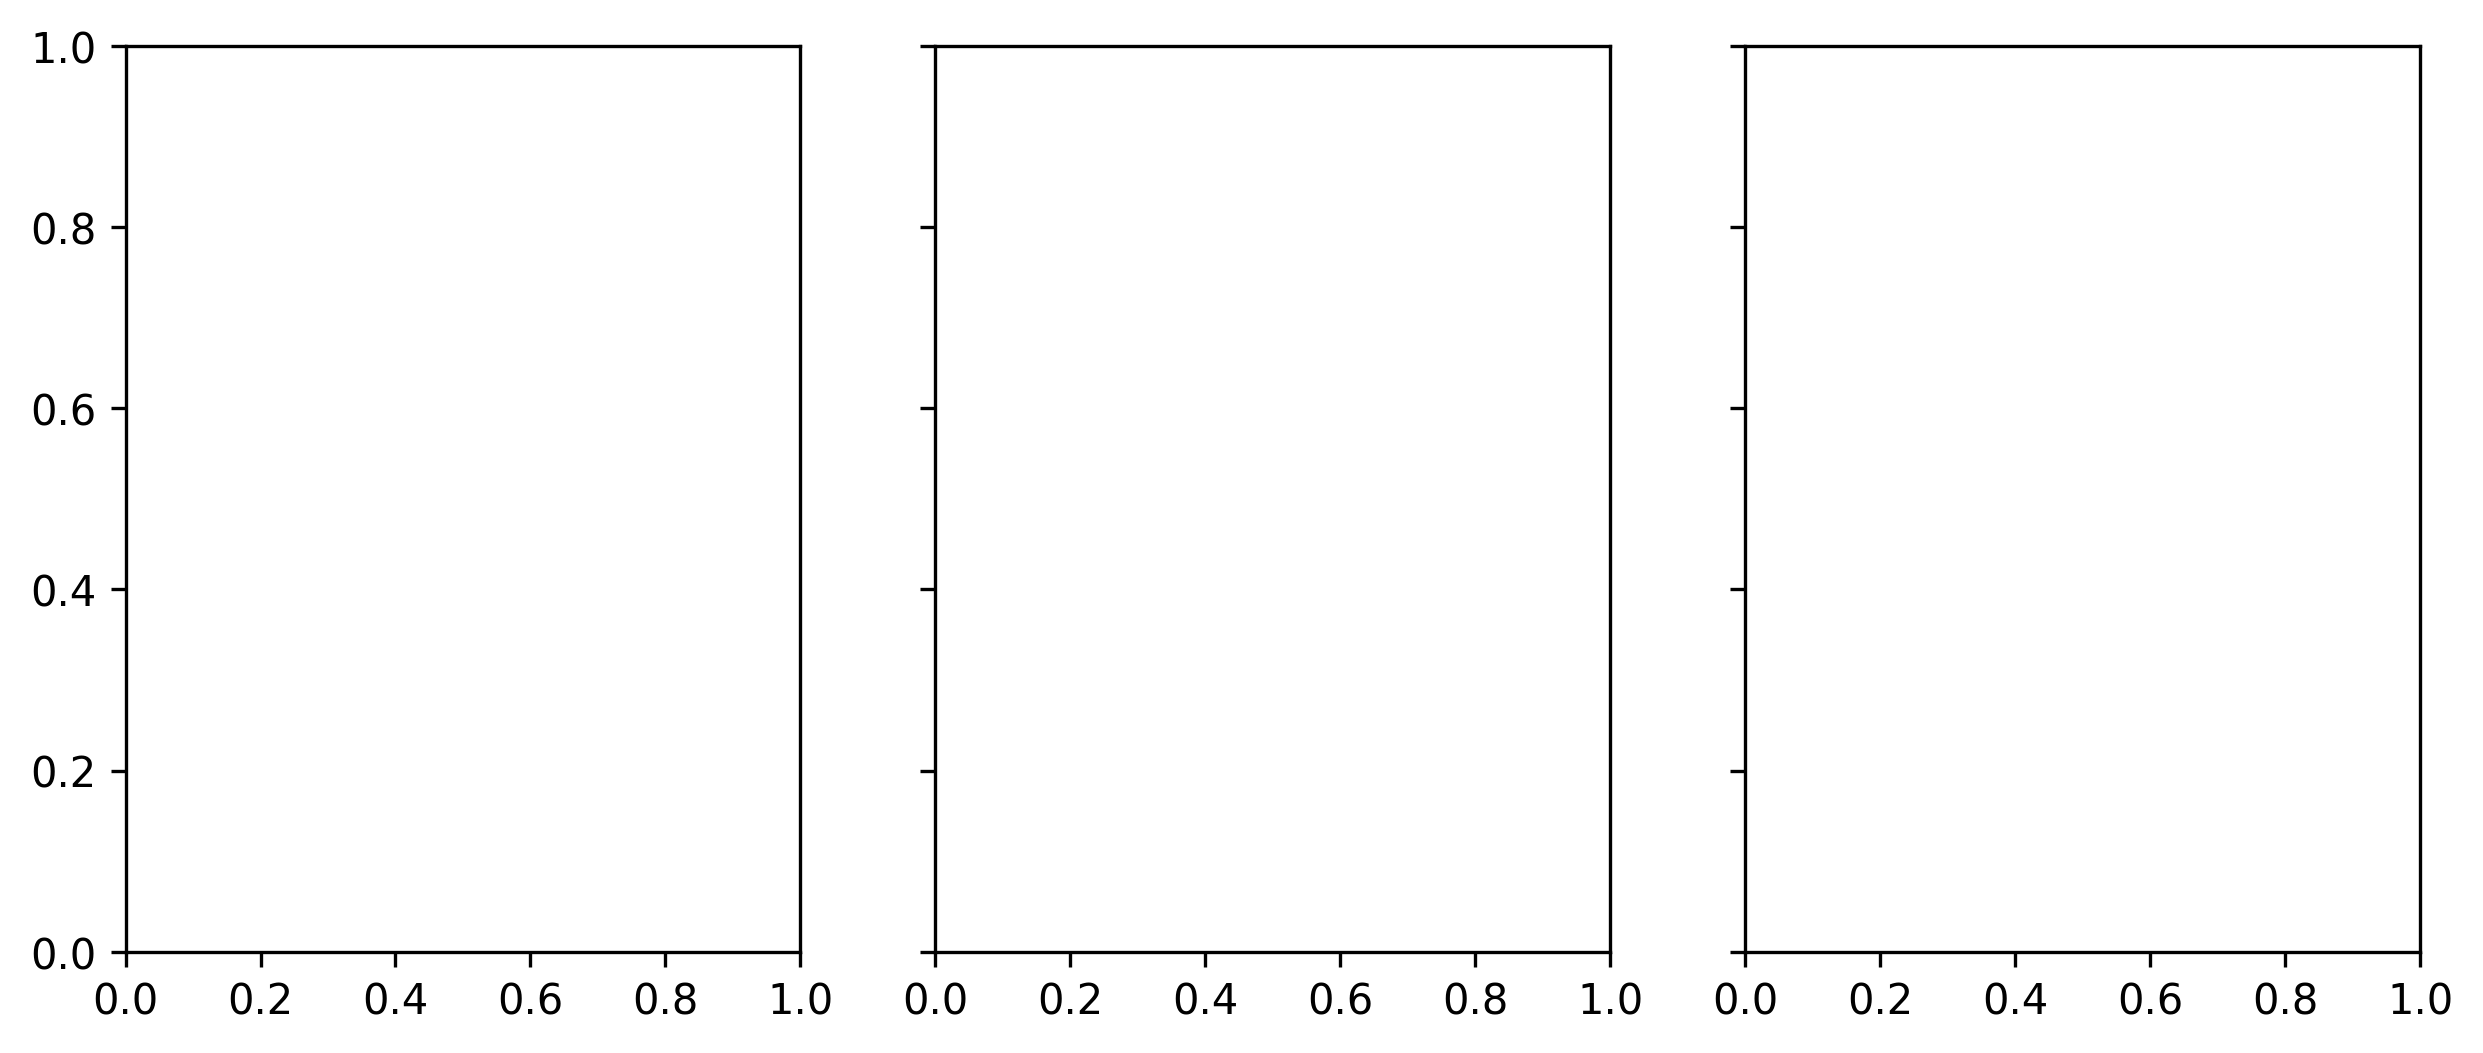

In [31]:
print(full30.time[0])
print(base_folder)
print(optimization_folder)
print(run)
for t in full30.time.values[1:10]:
#     ci_plots(full30['ci'].sel(time=t), pd.Timestamp(t), run, nc=31)
#     U_plots(full30['U'].sel(time=t), pd.Timestamp(t), run)
#     V_plots(full30['V'].sel(time=t), pd.Timestamp(t), run)
    
#     if t in truth.time.values:
#         data = [fore30['ci'].sel(time=t).values, truth.sel(time=t).values, wrf30['ci'].sel(time=t).values]
#         tp.subplots(data, truth.west_east, truth.south_north,
#                     ['Assimilation', 'Truth', 'WRF'], ['west_east', 'south_north'],
#                     cb_label='ci', cmap='Blues_r', nc=31)
        
        try:
            data = [fd_mean_30['ci'].sel(time=t).values,
                    truth_full.sel(time=t).values,
                    wrf_full_30['ci'].sel(time=t).values]
            tp.subplots(data, truth_full.west_east, truth_full.south_north,
                        ['Assimilation', f'Truth: {t}', 'WRF'], ['west_east', 'south_north'],
                        cb_label='ci', cmap='Blues_r', nc=31)
            
            data = [fd_mean_30['ci'].sel(time=t).values,
                    truth_full.sel(time=t).values,
                    opt_flow_full_30['ci'].sel(time=t).values]
            tp.subplots(data, truth_full.west_east, truth_full.south_north,
                        ['Assimilation', f'Truth: {t}', 'Opt. Flow'], ['west_east', 'south_north'],
                        cb_label='ci', cmap='Blues_r', nc=31)
            
            
            data = [fd_mean_30['U'].sel(time=t).values,
                    truth_full.sel(time=t).values,
                    wrf_full_30['U'].sel(time=t).values]
            tp.subplots(data, truth_full.west_east, truth_full.south_north,
                        ['Assimilation', f'Truth: {t}', 'WRF'], ['west_east', 'south_north'],
                        cb_label='ci', cmap='Blues_r', nc=31)
            
            data = [fd_mean_30['U'].sel(time=t).values,
                    truth_full.sel(time=t).values,
                    opt_flow_full_30['U'].sel(time=t).values]
            tp.subplots(data, truth_full.west_east, truth_full.south_north,
                        ['Assimilation', f'Truth: {t}', 'Opt. Flow'], ['west_east', 'south_north'],
                        cb_label='ci', cmap='Blues_r', nc=31)
            
            data = [fd_mean_30['V'].sel(time=t).values,
                    truth_full.sel(time=t).values,
                    wrf_full_30['V'].sel(time=t).values]
            tp.subplots(data, truth_full.west_east, truth_full.south_north,
                        ['Assimilation', f'Truth: {t}', 'WRF'], ['west_east', 'south_north'],
                        cb_label='ci', cmap='Blues_r', nc=31)
            
            data = [fd_mean_30['V'].sel(time=t).values,
                    truth_full.sel(time=t).values,
                    opt_flow_full_30['V'].sel(time=t).values]
            tp.subplots(data, truth_full.west_east, truth_full.south_north,
                        ['Assimilation', f'Truth: {t}', 'Opt. Flow'], ['west_east', 'south_north'],
                        cb_label='ci', cmap='Blues_r', nc=31)
            
        except:
            continue
        
#         error_assim = (fd_mean_30['ci'].sel(time=t) - truth_full.sel(time=t))
#         error_wrf = (wrf_full_30['ci'].sel(time=t) - truth_full.sel(time=t))
#         vmax = error_assim.max()
#         vmax = np.max([vmax, error_wrf.max()])
#         data = [error_assim, error_wrf]
#         tp.subplots(data, truth_full.west_east, truth_full.south_north,
#                     ['Assim Error', 'WRF Error'], ['west_east', 'south_north'], cmap='bwr', vmax=vmax,
#                     cb_label='ci', nc=12)
        
#         error_assim = (fd_mean_30['ci'].sel(time=t) - truth_full.sel(time=t))
#         error_opt_flow = (opt_flow_full_30['ci'].sel(time=t) - truth_full.sel(time=t))
#         vmax = error_assim.max()
#         vmax = np.max([vmax, error_opt_flow.max()])
#         data = [error_assim, error_opt_flow]
#         tp.subplots(data, truth_full.west_east, truth_full.south_north,
#                     ['Assim Error', 'Opt. Flow Error'], ['west_east', 'south_north'], cmap='bwr', vmax=vmax,
#                     cb_label='ci', nc=12)
        
#         error_assim = (fore30['ci'].sel(time=t) - truth.sel(time=t))
#         error_wrf = (wrf30['ci'].sel(time=t) - truth.sel(time=t))
#         vmax = error_assim.max()
#         vmax = np.max([vmax, error_wrf.max()])
#         data = [error_assim, error_wrf]
#         tp.subplots(data, truth.west_east, truth.south_north,
#                     ['Assim Error', 'WRF Error'], ['west_east', 'south_north'], cmap='bwr', vmax=vmax,
#                     cb_label='ci', nc=31)
    
#     data = [fd_mean_30['U'].sel(time=t).values,
#             wrf_full_30['U'].sel(time=t).values]
#     vmax = np.max(list(map(lambda x: np.abs(x).max(), data)))
#     tp.subplots(data, fd_mean_30.west_east_stag, fd_mean_30.south_north,
#                 ['Assimilation', 'WRF'], ['west_east', 'south_north'],
#                 cb_label='m/s', cmap='bwr', vmax=vmax, nc=31)
    
#     data = [fd_mean_30['V'].sel(time=t).values,
#             wrf_full_30['V'].sel(time=t).values]
#     vmax = np.max(list(map(lambda x: np.abs(x).max(), data)))
#     tp.subplots(data, fd_mean_30.west_east, fd_mean_30.south_north_stag,
#                 ['Assimilation', 'WRF'], ['west_east', 'south_north'],
#                 cb_label='m/s', cmap='bwr', vmax=vmax, nc=31)

In [ ]:
print(full30.time[0])
print(base_folder)
print(optimization_folder)
print(run)
for t in fore30.time.values[1:]:
#     ci_plots(full30['ci'].sel(time=t), pd.Timestamp(t), run, nc=31)
#     U_plots(full30['U'].sel(time=t), pd.Timestamp(t), run)
#     V_plots(full30['V'].sel(time=t), pd.Timestamp(t), run)
    
#     if t in truth.time.values:
#         data = [fore30['ci'].sel(time=t).values, truth.sel(time=t).values, wrf30['ci'].sel(time=t).values]
#         tp.subplots(data, truth.west_east, truth.south_north,
#                     ['Assimilation', 'Truth', 'WRF'], ['west_east', 'south_north'],
#                     cb_label='ci', cmap='Blues_r', nc=31)
        try:
            data = [fore30['ci'].sel(time=t).values,
                    truth.sel(time=t).values,
                    wrf30['ci'].sel(time=t).values]
            tp.subplots(data, truth.west_east, truth.south_north,
                        ['Assimilation', f'Truth: {t}', 'WRF'], ['west_east', 'south_north'],
                        cb_label='ci', cmap='Blues_r', nc=31)

            data = [fore30['ci'].sel(time=t).values,
                    truth.sel(time=t).values,
                    opt_flow_30['ci'].sel(time=t).values]
            tp.subplots(data, truth.west_east, truth.south_north,
                        ['Assimilation', f'Truth: {t}', 'Opt. Flow'], ['west_east', 'south_north'],
                        cb_label='ci', cmap='Blues_r', nc=31)
        except:
            continue
        
        error_assim = (fore30['ci'].sel(time=t) - truth.sel(time=t))
        error_wrf = (wrf30['ci'].sel(time=t) - truth.sel(time=t))
        vmax = error_assim.max()
        vmax = np.max([vmax, error_wrf.max()])
        data = [error_assim, error_wrf]
        tp.subplots(data, truth.west_east, truth.south_north,
                    ['Assim Error', 'WRF Error'], ['west_east', 'south_north'], cmap='bwr', vmax=vmax,
                    cb_label='ci', nc=12)
        
        error_assim = (fore30['ci'].sel(time=t) - truth.sel(time=t))
        error_opt_flow = (opt_flow_30['ci'].sel(time=t) - truth.sel(time=t))
        vmax = error_assim.max()
        vmax = np.max([vmax, error_opt_flow.max()])
        data = [error_assim, error_opt_flow]
        tp.subplots(data, truth.west_east, truth.south_north,
                    ['Assim Error', 'Opt. Flow Error'], ['west_east', 'south_north'], cmap='bwr', vmax=vmax,
                    cb_label='ci', nc=12)
        
#         error_assim = (fore30['ci'].sel(time=t) - truth.sel(time=t))
#         error_wrf = (wrf30['ci'].sel(time=t) - truth.sel(time=t))
#         vmax = error_assim.max()
#         vmax = np.max([vmax, error_wrf.max()])
#         data = [error_assim, error_wrf]
#         tp.subplots(data, truth.west_east, truth.south_north,
#                     ['Assim Error', 'WRF Error'], ['west_east', 'south_north'], cmap='bwr', vmax=vmax,
#                     cb_label='ci', nc=31)
    
#     data = [fd_mean_30['U'].sel(time=t).values,
#             wrf_full_30['U'].sel(time=t).values]
#     vmax = np.max(list(map(lambda x: np.abs(x).max(), data)))
#     tp.subplots(data, fd_mean_30.west_east_stag, fd_mean_30.south_north,
#                 ['Assimilation', 'WRF'], ['west_east', 'south_north'],
#                 cb_label='m/s', cmap='bwr', vmax=vmax, nc=31)
    
#     data = [fd_mean_30['V'].sel(time=t).values,
#             wrf_full_30['V'].sel(time=t).values]
#     vmax = np.max(list(map(lambda x: np.abs(x).max(), data)))
#     tp.subplots(data, fd_mean_30.west_east, fd_mean_30.south_north_stag,
#                 ['Assimilation', 'WRF'], ['west_east', 'south_north'],
#                 cb_label='m/s', cmap='bwr', vmax=vmax, nc=31)

In [ ]:
year = 2014
month = 4
day = 26

In [ ]:
truth = xr.open_dataset(
    f'/a2/uaren/travis/data/{year:04}/{month:02}/{day:02}/data.nc')
truth = truth['ci']
truth = letkf_io.add_crop_attributes(truth)
truth_full = truth.copy()
truth = ar.return_error_domain(truth)

In [ ]:
truth = truth.load()

In [ ]:
importlib.reload(letkf_io)

In [ ]:
base_folder = '/a2/uaren/travis/'
optimization_folder = None
run = 'owp_opt'

In [ ]:
full_day = letkf_io.return_day(year,
                               month,
                               day,
                               run,
                               base_folder,
                               optimization_folder)

In [ ]:
full_day = letkf_io.add_crop_attributes(full_day)
full_day = full_day.load()
full_day_ed = ar.return_error_domain(full_day)

In [ ]:
fd_mean = ar.return_ens_mean(full_day)

In [ ]:
fd_mean_30 = ar.return_horizon(fd_mean, 30)

In [ ]:
fd_ed_mean = ar.return_ens_mean(full_day_ed)

In [ ]:
fore30 = ar.return_horizon(fd_ed_mean, 30)

In [ ]:
full30 = ar.return_horizon(full_day_ed, 30)

In [ ]:
wrf = letkf_io.return_day(year,
                          month,
                          day,
                          'wrf_no_div',
                          base_folder)

In [ ]:
wrf = wrf.load()

In [ ]:
wrf = letkf_io.add_crop_attributes(wrf)
wrf_ed = ar.return_error_domain(wrf)

In [ ]:
wrf_ed_mean = ar.return_ens_mean(wrf_ed)

In [ ]:
wrf30 = ar.return_horizon(wrf_ed_mean, 30)

In [ ]:
wrf_full_30 = ar.return_horizon(wrf, 30)
wrf_full_30 = wrf_full_30.sel(ensemble_number=0)

In [ ]:
opt_flow = letkf_io.return_day(year,
                          month,
                          day,
                          'opt_flow',
                          base_folder)

In [ ]:
opt_flow = opt_flow.load()

In [ ]:
opt_flow = letkf_io.add_crop_attributes(opt_flow)
opt_flow_ed = ar.return_error_domain(opt_flow)

In [ ]:
opt_flow_ed_mean = ar.return_ens_mean(opt_flow_ed)

In [ ]:
opt_flow_30 = ar.return_horizon(opt_flow_ed_mean, 30)

In [ ]:
opt_flow_full_30 = ar.return_horizon(opt_flow, 30)
opt_flow_full_30 = opt_flow_full_30.sel(ensemble_number=0)

In [ ]:
truth_full = truth_full.sel(south_north=wrf.south_north,
                            west_east=wrf.west_east)

In [ ]:
def U_plots(ensemble, time, mod):
    hour = time.hour
    minute = time.minute
#     fig, ax = tp.var_plot(
#         ensemble[:sys_vars.U_crop_size], sys_vars.U_crop_shape, 1)
#     fig.suptitle(f'variance of U; {mod}; {hour:02}:{minute:02}')
#     plt.show()
    
#     fig, ax = tp.ensemble_stamps(
#         [], [], ensemble[:sys_vars.U_crop_size], 2, 3, 
#         sys_vars.U_crop_shape, 1.02,
#         cmap='bwr', vmin=None)
#     fig.suptitle(f'U mean and samples; {mod}; {hour:02}:{minute:02}')
#     plt.show()
    vmax = abs(ensemble).max()
    fig, ax = tp.ensemble_stamps_cdf(
        [], [], ensemble, 2, 3, 
        ensemble.isel(ensemble_number=0).shape, 1.02, cmap='bwr',
        vmin=-vmax, vmax=vmax, nc=31)
    fig.suptitle(f'U mean and samples; {mod}; {hour:02}:{minute:02}')
    plt.show()
    
def V_plots(ensemble, time, mod):
    hour = time.hour
    minute = time.minute
    fig, ax = tp.var_plot(
        ensemble[sys_vars.U_crop_size: sys_vars.wind_size],
        sys_vars.V_crop_shape, 1)
    fig.suptitle(f'variance of V; {mod}; {hour:02}:{minute:02}')
    fig.show()
    
    fig, ax = tp.ensemble_stamps(
        [], [], ensemble[sys_vars.U_crop_size: sys_vars.wind_size],
        2, 3, sys_vars.V_crop_shape, 1.02,
        cmap='bwr', vmin=None)
    fig.suptitle(f'V mean and samples; {mod}; {hour:02}:{minute:02}')
    plt.show()

def ci_plots(ensemble, time, mod, nc=11):
    hour = time.hour
    minute = time.minute
#     median = ensemble.median(dim='ensemble_number')
#     fig, ax = tp.ensemble_stamps_cdf(
#         [median], ['median'], ensemble, 2, 3, 
#         ensemble.isel(ensemble_number=0).shape, 1.02, cmap='Blues_r')
    fig, ax = tp.ensemble_stamps_cdf(
        [], [], ensemble, 2, 3, 
        ensemble.isel(ensemble_number=0).shape, 1.02, cmap='Blues_r', nc=nc)
    fig.suptitle(f'CI mean and samples; {mod}; {hour:02}:{minute:02}')
    plt.show()

In [ ]:
print(full30.time[0])
print(base_folder)
print(optimization_folder)
print(run)
for t in full30.time.values[1:]:
#     ci_plots(full30['ci'].sel(time=t), pd.Timestamp(t), run, nc=31)
#     U_plots(full30['U'].sel(time=t), pd.Timestamp(t), run)
#     V_plots(full30['V'].sel(time=t), pd.Timestamp(t), run)
    
#     if t in truth.time.values:
#         data = [fore30['ci'].sel(time=t).values, truth.sel(time=t).values, wrf30['ci'].sel(time=t).values]
#         tp.subplots(data, truth.west_east, truth.south_north,
#                     ['Assimilation', 'Truth', 'WRF'], ['west_east', 'south_north'],
#                     cb_label='ci', cmap='Blues_r', nc=31)
        
        try:
            data = [fd_mean_30['ci'].sel(time=t).values,
                    truth_full.sel(time=t).values,
                    wrf_full_30['ci'].sel(time=t).values]
            tp.subplots(data, truth_full.west_east, truth_full.south_north,
                        ['Assimilation', f'Truth: {t}', 'WRF'], ['west_east', 'south_north'],
                        cb_label='ci', cmap='Blues_r', nc=31)
            
            data = [fd_mean_30['ci'].sel(time=t).values,
                    truth_full.sel(time=t).values,
                    opt_flow_full_30['ci'].sel(time=t).values]
            tp.subplots(data, truth_full.west_east, truth_full.south_north,
                        ['Assimilation', f'Truth: {t}', 'Opt. Flow'], ['west_east', 'south_north'],
                        cb_label='ci', cmap='Blues_r', nc=31)
            
        except:
            continue
        
        error_assim = (fd_mean_30['ci'].sel(time=t) - truth_full.sel(time=t))
        error_wrf = (wrf_full_30['ci'].sel(time=t) - truth_full.sel(time=t))
        vmax = error_assim.max()
        vmax = np.max([vmax, error_wrf.max()])
        data = [error_assim, error_wrf]
        tp.subplots(data, truth_full.west_east, truth_full.south_north,
                    ['Assim Error', 'WRF Error'], ['west_east', 'south_north'], cmap='bwr', vmax=vmax,
                    cb_label='ci', nc=12)
        
        error_assim = (fd_mean_30['ci'].sel(time=t) - truth_full.sel(time=t))
        error_opt_flow = (opt_flow_full_30['ci'].sel(time=t) - truth_full.sel(time=t))
        vmax = error_assim.max()
        vmax = np.max([vmax, error_opt_flow.max()])
        data = [error_assim, error_opt_flow]
        tp.subplots(data, truth_full.west_east, truth_full.south_north,
                    ['Assim Error', 'Opt. Flow Error'], ['west_east', 'south_north'], cmap='bwr', vmax=vmax,
                    cb_label='ci', nc=12)
        
#         error_assim = (fore30['ci'].sel(time=t) - truth.sel(time=t))
#         error_wrf = (wrf30['ci'].sel(time=t) - truth.sel(time=t))
#         vmax = error_assim.max()
#         vmax = np.max([vmax, error_wrf.max()])
#         data = [error_assim, error_wrf]
#         tp.subplots(data, truth.west_east, truth.south_north,
#                     ['Assim Error', 'WRF Error'], ['west_east', 'south_north'], cmap='bwr', vmax=vmax,
#                     cb_label='ci', nc=31)
    
#     data = [fd_mean_30['U'].sel(time=t).values,
#             wrf_full_30['U'].sel(time=t).values]
#     vmax = np.max(list(map(lambda x: np.abs(x).max(), data)))
#     tp.subplots(data, fd_mean_30.west_east_stag, fd_mean_30.south_north,
#                 ['Assimilation', 'WRF'], ['west_east', 'south_north'],
#                 cb_label='m/s', cmap='bwr', vmax=vmax, nc=31)
    
#     data = [fd_mean_30['V'].sel(time=t).values,
#             wrf_full_30['V'].sel(time=t).values]
#     vmax = np.max(list(map(lambda x: np.abs(x).max(), data)))
#     tp.subplots(data, fd_mean_30.west_east, fd_mean_30.south_north_stag,
#                 ['Assimilation', 'WRF'], ['west_east', 'south_north'],
#                 cb_label='m/s', cmap='bwr', vmax=vmax, nc=31)

In [ ]:
print(full30.time[0])
print(base_folder)
print(optimization_folder)
print(run)
for t in fore30.time.values[1:]:
#     ci_plots(full30['ci'].sel(time=t), pd.Timestamp(t), run, nc=31)
#     U_plots(full30['U'].sel(time=t), pd.Timestamp(t), run)
#     V_plots(full30['V'].sel(time=t), pd.Timestamp(t), run)
    
#     if t in truth.time.values:
#         data = [fore30['ci'].sel(time=t).values, truth.sel(time=t).values, wrf30['ci'].sel(time=t).values]
#         tp.subplots(data, truth.west_east, truth.south_north,
#                     ['Assimilation', 'Truth', 'WRF'], ['west_east', 'south_north'],
#                     cb_label='ci', cmap='Blues_r', nc=31)
        try:
            data = [fore30['ci'].sel(time=t).values,
                    truth.sel(time=t).values,
                    wrf30['ci'].sel(time=t).values]
            tp.subplots(data, truth.west_east, truth.south_north,
                        ['Assimilation', f'Truth: {t}', 'WRF'], ['west_east', 'south_north'],
                        cb_label='ci', cmap='Blues_r', nc=31)

            data = [fore30['ci'].sel(time=t).values,
                    truth.sel(time=t).values,
                    opt_flow_30['ci'].sel(time=t).values]
            tp.subplots(data, truth.west_east, truth.south_north,
                        ['Assimilation', f'Truth: {t}', 'Opt. Flow'], ['west_east', 'south_north'],
                        cb_label='ci', cmap='Blues_r', nc=31)
        except:
            continue
        
        error_assim = (fore30['ci'].sel(time=t) - truth.sel(time=t))
        error_wrf = (wrf30['ci'].sel(time=t) - truth.sel(time=t))
        vmax = error_assim.max()
        vmax = np.max([vmax, error_wrf.max()])
        data = [error_assim, error_wrf]
        tp.subplots(data, truth.west_east, truth.south_north,
                    ['Assim Error', 'WRF Error'], ['west_east', 'south_north'], cmap='bwr', vmax=vmax,
                    cb_label='ci', nc=12)
        
        error_assim = (fore30['ci'].sel(time=t) - truth.sel(time=t))
        error_opt_flow = (opt_flow_30['ci'].sel(time=t) - truth.sel(time=t))
        vmax = error_assim.max()
        vmax = np.max([vmax, error_opt_flow.max()])
        data = [error_assim, error_opt_flow]
        tp.subplots(data, truth.west_east, truth.south_north,
                    ['Assim Error', 'Opt. Flow Error'], ['west_east', 'south_north'], cmap='bwr', vmax=vmax,
                    cb_label='ci', nc=12)
        
#         error_assim = (fore30['ci'].sel(time=t) - truth.sel(time=t))
#         error_wrf = (wrf30['ci'].sel(time=t) - truth.sel(time=t))
#         vmax = error_assim.max()
#         vmax = np.max([vmax, error_wrf.max()])
#         data = [error_assim, error_wrf]
#         tp.subplots(data, truth.west_east, truth.south_north,
#                     ['Assim Error', 'WRF Error'], ['west_east', 'south_north'], cmap='bwr', vmax=vmax,
#                     cb_label='ci', nc=31)
    
#     data = [fd_mean_30['U'].sel(time=t).values,
#             wrf_full_30['U'].sel(time=t).values]
#     vmax = np.max(list(map(lambda x: np.abs(x).max(), data)))
#     tp.subplots(data, fd_mean_30.west_east_stag, fd_mean_30.south_north,
#                 ['Assimilation', 'WRF'], ['west_east', 'south_north'],
#                 cb_label='m/s', cmap='bwr', vmax=vmax, nc=31)
    
#     data = [fd_mean_30['V'].sel(time=t).values,
#             wrf_full_30['V'].sel(time=t).values]
#     vmax = np.max(list(map(lambda x: np.abs(x).max(), data)))
#     tp.subplots(data, fd_mean_30.west_east, fd_mean_30.south_north_stag,
#                 ['Assimilation', 'WRF'], ['west_east', 'south_north'],
#                 cb_label='m/s', cmap='bwr', vmax=vmax, nc=31)

In [ ]:
year = 2014
month = 5
day = 29

In [ ]:
truth = xr.open_dataset(
    f'/a2/uaren/travis/data/{year:04}/{month:02}/{day:02}/data.nc')
truth = truth['ci']
truth = letkf_io.add_crop_attributes(truth)
truth_full = truth.copy()
truth = ar.return_error_domain(truth)

In [ ]:
truth = truth.load()

In [ ]:
importlib.reload(letkf_io)

In [ ]:
base_folder = '/a2/uaren/travis/'
optimization_folder = None
run = 'owp_opt'

In [ ]:
full_day = letkf_io.return_day(year,
                               month,
                               day,
                               run,
                               base_folder,
                               optimization_folder)

In [ ]:
full_day = letkf_io.add_crop_attributes(full_day)
full_day = full_day.load()
full_day_ed = ar.return_error_domain(full_day)

In [ ]:
fd_mean = ar.return_ens_mean(full_day)

In [ ]:
fd_mean_30 = ar.return_horizon(fd_mean, 30)

In [ ]:
fd_ed_mean = ar.return_ens_mean(full_day_ed)

In [ ]:
fore30 = ar.return_horizon(fd_ed_mean, 30)

In [ ]:
full30 = ar.return_horizon(full_day_ed, 30)

In [ ]:
wrf = letkf_io.return_day(year,
                          month,
                          day,
                          'wrf_no_div',
                          base_folder)

In [ ]:
wrf = wrf.load()

In [ ]:
wrf = letkf_io.add_crop_attributes(wrf)
wrf_ed = ar.return_error_domain(wrf)

In [ ]:
wrf_ed_mean = ar.return_ens_mean(wrf_ed)

In [ ]:
wrf30 = ar.return_horizon(wrf_ed_mean, 30)

In [ ]:
wrf_full_30 = ar.return_horizon(wrf, 30)
wrf_full_30 = wrf_full_30.sel(ensemble_number=0)

In [ ]:
opt_flow = letkf_io.return_day(year,
                          month,
                          day,
                          'opt_flow',
                          base_folder)

In [ ]:
opt_flow = opt_flow.load()

In [ ]:
opt_flow = letkf_io.add_crop_attributes(opt_flow)
opt_flow_ed = ar.return_error_domain(opt_flow)

In [ ]:
opt_flow_ed_mean = ar.return_ens_mean(opt_flow_ed)

In [ ]:
opt_flow_30 = ar.return_horizon(opt_flow_ed_mean, 30)

In [ ]:
opt_flow_full_30 = ar.return_horizon(opt_flow, 30)
opt_flow_full_30 = opt_flow_full_30.sel(ensemble_number=0)

In [ ]:
truth_full = truth_full.sel(south_north=wrf.south_north,
                            west_east=wrf.west_east)

In [ ]:
def U_plots(ensemble, time, mod):
    hour = time.hour
    minute = time.minute
#     fig, ax = tp.var_plot(
#         ensemble[:sys_vars.U_crop_size], sys_vars.U_crop_shape, 1)
#     fig.suptitle(f'variance of U; {mod}; {hour:02}:{minute:02}')
#     plt.show()
    
#     fig, ax = tp.ensemble_stamps(
#         [], [], ensemble[:sys_vars.U_crop_size], 2, 3, 
#         sys_vars.U_crop_shape, 1.02,
#         cmap='bwr', vmin=None)
#     fig.suptitle(f'U mean and samples; {mod}; {hour:02}:{minute:02}')
#     plt.show()
    vmax = abs(ensemble).max()
    fig, ax = tp.ensemble_stamps_cdf(
        [], [], ensemble, 2, 3, 
        ensemble.isel(ensemble_number=0).shape, 1.02, cmap='bwr',
        vmin=-vmax, vmax=vmax, nc=31)
    fig.suptitle(f'U mean and samples; {mod}; {hour:02}:{minute:02}')
    plt.show()
    
def V_plots(ensemble, time, mod):
    hour = time.hour
    minute = time.minute
    fig, ax = tp.var_plot(
        ensemble[sys_vars.U_crop_size: sys_vars.wind_size],
        sys_vars.V_crop_shape, 1)
    fig.suptitle(f'variance of V; {mod}; {hour:02}:{minute:02}')
    fig.show()
    
    fig, ax = tp.ensemble_stamps(
        [], [], ensemble[sys_vars.U_crop_size: sys_vars.wind_size],
        2, 3, sys_vars.V_crop_shape, 1.02,
        cmap='bwr', vmin=None)
    fig.suptitle(f'V mean and samples; {mod}; {hour:02}:{minute:02}')
    plt.show()

def ci_plots(ensemble, time, mod, nc=11):
    hour = time.hour
    minute = time.minute
#     median = ensemble.median(dim='ensemble_number')
#     fig, ax = tp.ensemble_stamps_cdf(
#         [median], ['median'], ensemble, 2, 3, 
#         ensemble.isel(ensemble_number=0).shape, 1.02, cmap='Blues_r')
    fig, ax = tp.ensemble_stamps_cdf(
        [], [], ensemble, 2, 3, 
        ensemble.isel(ensemble_number=0).shape, 1.02, cmap='Blues_r', nc=nc)
    fig.suptitle(f'CI mean and samples; {mod}; {hour:02}:{minute:02}')
    plt.show()

In [ ]:
print(full30.time[0])
print(base_folder)
print(optimization_folder)
print(run)
for t in full30.time.values[1:]:
#     ci_plots(full30['ci'].sel(time=t), pd.Timestamp(t), run, nc=31)
#     U_plots(full30['U'].sel(time=t), pd.Timestamp(t), run)
#     V_plots(full30['V'].sel(time=t), pd.Timestamp(t), run)
    
#     if t in truth.time.values:
#         data = [fore30['ci'].sel(time=t).values, truth.sel(time=t).values, wrf30['ci'].sel(time=t).values]
#         tp.subplots(data, truth.west_east, truth.south_north,
#                     ['Assimilation', 'Truth', 'WRF'], ['west_east', 'south_north'],
#                     cb_label='ci', cmap='Blues_r', nc=31)
        
        try:
            data = [fd_mean_30['ci'].sel(time=t).values,
                    truth_full.sel(time=t).values,
                    wrf_full_30['ci'].sel(time=t).values]
            tp.subplots(data, truth_full.west_east, truth_full.south_north,
                        ['Assimilation', 'Truth', 'WRF'], ['west_east', 'south_north'],
                        cb_label='ci', cmap='Blues_r', nc=31)
            
            data = [fd_mean_30['ci'].sel(time=t).values,
                    truth_full.sel(time=t).values,
                    opt_flow_full_30['ci'].sel(time=t).values]
            tp.subplots(data, truth_full.west_east, truth_full.south_north,
                        ['Assimilation', 'Truth', 'Opt. Flow'], ['west_east', 'south_north'],
                        cb_label='ci', cmap='Blues_r', nc=31)
            
        except:
            continue
        
        error_assim = (fd_mean_30['ci'].sel(time=t) - truth_full.sel(time=t))
        error_wrf = (wrf_full_30['ci'].sel(time=t) - truth_full.sel(time=t))
        vmax = error_assim.max()
        vmax = np.max([vmax, error_wrf.max()])
        data = [error_assim, error_wrf]
        tp.subplots(data, truth_full.west_east, truth_full.south_north,
                    ['Assim Error', 'WRF Error'], ['west_east', 'south_north'], cmap='bwr', vmax=vmax,
                    cb_label='ci', nc=12)
        
        error_assim = (fd_mean_30['ci'].sel(time=t) - truth_full.sel(time=t))
        error_opt_flow = (opt_flow_full_30['ci'].sel(time=t) - truth_full.sel(time=t))
        vmax = error_assim.max()
        vmax = np.max([vmax, error_opt_flow.max()])
        data = [error_assim, error_opt_flow]
        tp.subplots(data, truth_full.west_east, truth_full.south_north,
                    ['Assim Error', 'Opt. Flow Error'], ['west_east', 'south_north'], cmap='bwr', vmax=vmax,
                    cb_label='ci', nc=12)
        
#         error_assim = (fore30['ci'].sel(time=t) - truth.sel(time=t))
#         error_wrf = (wrf30['ci'].sel(time=t) - truth.sel(time=t))
#         vmax = error_assim.max()
#         vmax = np.max([vmax, error_wrf.max()])
#         data = [error_assim, error_wrf]
#         tp.subplots(data, truth.west_east, truth.south_north,
#                     ['Assim Error', 'WRF Error'], ['west_east', 'south_north'], cmap='bwr', vmax=vmax,
#                     cb_label='ci', nc=31)
    
#     data = [fd_mean_30['U'].sel(time=t).values,
#             wrf_full_30['U'].sel(time=t).values]
#     vmax = np.max(list(map(lambda x: np.abs(x).max(), data)))
#     tp.subplots(data, fd_mean_30.west_east_stag, fd_mean_30.south_north,
#                 ['Assimilation', 'WRF'], ['west_east', 'south_north'],
#                 cb_label='m/s', cmap='bwr', vmax=vmax, nc=31)
    
#     data = [fd_mean_30['V'].sel(time=t).values,
#             wrf_full_30['V'].sel(time=t).values]
#     vmax = np.max(list(map(lambda x: np.abs(x).max(), data)))
#     tp.subplots(data, fd_mean_30.west_east, fd_mean_30.south_north_stag,
#                 ['Assimilation', 'WRF'], ['west_east', 'south_north'],
#                 cb_label='m/s', cmap='bwr', vmax=vmax, nc=31)

In [ ]:
print(full30.time[0])
print(base_folder)
print(optimization_folder)
print(run)
for t in fore30.time.values[1:]:
#     ci_plots(full30['ci'].sel(time=t), pd.Timestamp(t), run, nc=31)
#     U_plots(full30['U'].sel(time=t), pd.Timestamp(t), run)
#     V_plots(full30['V'].sel(time=t), pd.Timestamp(t), run)
    
#     if t in truth.time.values:
#         data = [fore30['ci'].sel(time=t).values, truth.sel(time=t).values, wrf30['ci'].sel(time=t).values]
#         tp.subplots(data, truth.west_east, truth.south_north,
#                     ['Assimilation', 'Truth', 'WRF'], ['west_east', 'south_north'],
#                     cb_label='ci', cmap='Blues_r', nc=31)
        try:
            data = [fore30['ci'].sel(time=t).values,
                    truth.sel(time=t).values,
                    wrf30['ci'].sel(time=t).values]
            tp.subplots(data, truth.west_east, truth.south_north,
                        ['Assimilation', f'Truth: {t}', 'WRF'], ['west_east', 'south_north'],
                        cb_label='ci', cmap='Blues_r', nc=31)

            data = [fore30['ci'].sel(time=t).values,
                    truth.sel(time=t).values,
                    opt_flow_30['ci'].sel(time=t).values]
            tp.subplots(data, truth.west_east, truth.south_north,
                        ['Assimilation', f'Truth: {t}', 'Opt. Flow'], ['west_east', 'south_north'],
                        cb_label='ci', cmap='Blues_r', nc=31)
        except:
            continue
        
        error_assim = (fore30['ci'].sel(time=t) - truth.sel(time=t))
        error_wrf = (wrf30['ci'].sel(time=t) - truth.sel(time=t))
        vmax = error_assim.max()
        vmax = np.max([vmax, error_wrf.max()])
        data = [error_assim, error_wrf]
        tp.subplots(data, truth.west_east, truth.south_north,
                    [f'Assim Error: {t}', 'WRF Error'], ['west_east', 'south_north'], cmap='bwr', vmax=vmax,
                    cb_label='ci', nc=12)
        
        error_assim = (fore30['ci'].sel(time=t) - truth.sel(time=t))
        error_opt_flow = (opt_flow_30['ci'].sel(time=t) - truth.sel(time=t))
        vmax = error_assim.max()
        vmax = np.max([vmax, error_opt_flow.max()])
        data = [error_assim, error_opt_flow]
        tp.subplots(data, truth.west_east, truth.south_north,
                    [f'Assim Error: {t}', 'Opt. Flow Error'], ['west_east', 'south_north'], cmap='bwr', vmax=vmax,
                    cb_label='ci', nc=12)
        
#         error_assim = (fore30['ci'].sel(time=t) - truth.sel(time=t))
#         error_wrf = (wrf30['ci'].sel(time=t) - truth.sel(time=t))
#         vmax = error_assim.max()
#         vmax = np.max([vmax, error_wrf.max()])
#         data = [error_assim, error_wrf]
#         tp.subplots(data, truth.west_east, truth.south_north,
#                     ['Assim Error', 'WRF Error'], ['west_east', 'south_north'], cmap='bwr', vmax=vmax,
#                     cb_label='ci', nc=31)
    
#     data = [fd_mean_30['U'].sel(time=t).values,
#             wrf_full_30['U'].sel(time=t).values]
#     vmax = np.max(list(map(lambda x: np.abs(x).max(), data)))
#     tp.subplots(data, fd_mean_30.west_east_stag, fd_mean_30.south_north,
#                 ['Assimilation', 'WRF'], ['west_east', 'south_north'],
#                 cb_label='m/s', cmap='bwr', vmax=vmax, nc=31)
    
#     data = [fd_mean_30['V'].sel(time=t).values,
#             wrf_full_30['V'].sel(time=t).values]
#     vmax = np.max(list(map(lambda x: np.abs(x).max(), data)))
#     tp.subplots(data, fd_mean_30.west_east, fd_mean_30.south_north_stag,
#                 ['Assimilation', 'WRF'], ['west_east', 'south_north'],
#                 cb_label='m/s', cmap='bwr', vmax=vmax, nc=31)

In [ ]:
print(full30.time[0])
print(base_folder)
print(optimization_folder)
print(run)
for t in full30.time.values:
    ci_plots(full30['ci'].sel(time=t), pd.Timestamp(t), run)
    U_plots(full30['U'].sel(time=t), pd.Timestamp(t), run)
    
    if t in truth.time.values:
        data = [fore30['ci'].sel(time=t).values, truth.sel(time=t).values, wrf30['ci'].sel(time=t).values]
        tp.subplots(data, truth.west_east, truth.south_north,
                    ['Assimilation', 'Truth', 'WRF'], ['west_east', 'south_north'],
                    cb_label='ci', cmap='Blues_r')
        
        
        data = [fd_mean_30['ci'].sel(time=t).values,
                truth_full.sel(time=t).values,
                wrf_full_30['ci'].sel(time=t).values]
        tp.subplots(data, truth_full.west_east, truth_full.south_north,
                    ['Assimilation', 'Truth', 'WRF'], ['west_east', 'south_north'],
                    cb_label='ci', cmap='Blues_r')
        
        error_assim = (fore30['ci'].sel(time=t) - truth.sel(time=t))
        error_wrf = (wrf30['ci'].sel(time=t) - truth.sel(time=t))
        vmax = error_assim.max()
        vmax = np.max([vmax, error_wrf.max()])
        data = [error_assim, error_wrf]
        tp.subplots(data, truth.west_east, truth.south_north,
                    ['Assim Error', 'WRF Error'], ['west_east', 'south_north'], cmap='bwr', vmax=vmax,
                    cb_label='ci')
    
    data = [fd_mean_30['U'].sel(time=t).values,
            wrf_full_30['U'].sel(time=t).values]
    vmax = np.max(list(map(lambda x: np.abs(x).max(), data)))
    tp.subplots(data, fd_mean_30.west_east_stag, fd_mean_30.south_north,
                ['Assimilation', 'WRF'], ['west_east', 'south_north'],
                cb_label='m/s', cmap='bwr', vmax=vmax, nc=31)
    
    data = [fd_mean_30['V'].sel(time=t).values,
            wrf_full_30['V'].sel(time=t).values]
    vmax = np.max(list(map(lambda x: np.abs(x).max(), data)))
    tp.subplots(data, fd_mean_30.west_east, fd_mean_30.south_north_stag,
                ['Assimilation', 'WRF'], ['west_east', 'south_north'],
                cb_label='m/s', cmap='bwr', vmax=vmax, nc=31)

In [ ]:
print(full30.time[0])
print(base_folder)
print(optimization_folder)
print(run)
for t in full30.time.values:
    ci_plots(full30['ci'].sel(time=t), pd.Timestamp(t), run)
    U_plots(full30['U'].sel(time=t), pd.Timestamp(t), run)
    
    if t in truth.time.values:
        data = [fore30['ci'].sel(time=t).values, truth.sel(time=t).values, wrf30['ci'].sel(time=t).values]
        tp.subplots(data, truth.west_east, truth.south_north,
                    ['Assimilation', 'Truth', 'WRF'], ['west_east', 'south_north'],
                    cb_label='ci', cmap='Blues_r')
        
        
        data = [fd_mean_30['ci'].sel(time=t).values,
                truth_full.sel(time=t).values,
                wrf_full_30['ci'].sel(time=t).values]
        tp.subplots(data, truth_full.west_east, truth_full.south_north,
                    ['Assimilation', 'Truth', 'WRF'], ['west_east', 'south_north'],
                    cb_label='ci', cmap='Blues_r')
        
        error_assim = (fore30['ci'].sel(time=t) - truth.sel(time=t))
        error_wrf = (wrf30['ci'].sel(time=t) - truth.sel(time=t))
        vmax = error_assim.max()
        vmax = np.max([vmax, error_wrf.max()])
        data = [error_assim, error_wrf]
        tp.subplots(data, truth.west_east, truth.south_north,
                    ['Assim Error', 'WRF Error'], ['west_east', 'south_north'], cmap='bwr', vmax=vmax,
                    cb_label='ci')
    
    data = [fd_mean_30['U'].sel(time=t).values,
            wrf_full_30['U'].sel(time=t).values]
    vmax = np.max(list(map(lambda x: np.abs(x).max(), data)))
    tp.subplots(data, fd_mean_30.west_east_stag, fd_mean_30.south_north,
                ['Assimilation', 'WRF'], ['west_east', 'south_north'],
                cb_label='m/s', cmap='bwr', vmax=vmax, nc=31)
    
    data = [fd_mean_30['V'].sel(time=t).values,
            wrf_full_30['V'].sel(time=t).values]
    vmax = np.max(list(map(lambda x: np.abs(x).max(), data)))
    tp.subplots(data, fd_mean_30.west_east, fd_mean_30.south_north_stag,
                ['Assimilation', 'WRF'], ['west_east', 'south_north'],
                cb_label='m/s', cmap='bwr', vmax=vmax, nc=31)

In [ ]:
print(full30.time[0])
for t in full30.time.values:
    ci_plots(full30['ci'].sel(time=t), pd.Timestamp(t), 'ow_15')
    
    if t in truth.time.values:
        data = [fore30['ci'].sel(time=t).values, truth.sel(time=t).values, wrf30['ci'].sel(time=t).values]
        tp.subplots(data, truth.west_east, truth.south_north,
                    ['Assimilation', 'Truth', 'WRF'], ['west_east', 'south_north'],
                    cb_label='ci', cmap='Blues_r')
        
        error_assim = (fore30['ci'].sel(time=t) - truth.sel(time=t))
        error_wrf = (wrf30['ci'].sel(time=t) - truth.sel(time=t))
        vmax = error_assim.max()
        vmax = np.max([vmax, error_wrf.max()])
        data = [error_assim, error_wrf]
        tp.subplots(data, truth.west_east, truth.south_north,
                    ['Assim Error', 'WRF Error'], ['west_east', 'south_north'], cmap='bwr', vmax=vmax,
                    cb_label='ci')
        
#         plt.figure()
#         truth.sel(time=t).plot(
#             cmap='Blues_r', vmin=0, vmax=1)
#         plt.axis('equal')
        
#         plt.figure()
#         fore30['ci'].sel(time=t).plot(
#             cmap='Blues', vmin=0, vmax=1)
#         plt.axis('equal')
        
#         error = (fore30['ci'].sel(time=t) - truth.sel(time=t))
#         plt.figure()
#         error.plot(
#             cmap='bwr')
#         plt.axis('equal')
        
#         plt.figure()
#         wrf30['ci'].sel(time=t).plot(
#             cmap='Blues_r', vmin=0, vmax=1)
#         plt.axis('equal')
        
#         error = (wrf30['ci'].sel(time=t) - truth.sel(time=t))
#         plt.figure()
#         error.plot(
#             cmap='bwr')
#         plt.axis('equal')

In [ ]:
pos = np.array(np.unravel_index(u_flat_pos, sys_vars.U_crop_shape))
tp.wrf_opt_flow_plot(ensemble_no_opt_flow, sys_vars.U_crop_shape, sys_vars.V_crop_shape,
               u_opt_flow, v_opt_flow, pos[::-1].T, 1)
tp.wrf_opt_flow_plot(ensemble, sys_vars.U_crop_shape, sys_vars.V_crop_shape,
               u_opt_flow, v_opt_flow, pos[::-1].T, 1)
tp.opt_flow_sd_plot(ensemble_no_opt_flow, sys_vars.U_crop_shape, sys_vars.V_crop_shape,
               u_opt_flow, v_opt_flow, pos[::-1].T, 1)
tp.opt_flow_sd_plot(ensemble, sys_vars.U_crop_shape, sys_vars.V_crop_shape,
               u_opt_flow, v_opt_flow, pos[::-1].T, 1)

In [ ]:
U_plots(ensemble, sat_time, 'opt_flow')
V_plots(ensemble, sat_time, 'opt_flow')
ci_plots(ensemble, sat_time, 'opt_flow')

In [ ]:
U_plots(ensemble, sat_time, 'remove_div')
V_plots(ensemble, sat_time, 'remove_div')
ci_plots(ensemble, sat_time, 'remove_div')

In [ ]:
for ii in range(ensemble_array.shape[0]):
    ci_plots(ensemble_array[ii], save_times[ii], 'forecasts')

In [ ]:
U_plots(ensemble, sat_times[0], 'ens_creation')
V_plots(ensemble, sat_times[0], 'ens_creation')
ci_plots(ensemble, sat_times[0], 'ens_creation')